In [ ]:
import numpy as np
import pandas as pd
from scipy import optimize, stats, linalg, sparse
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# <center> Black \& Scholes</center>

## Class for BS Pricing

In [ ]:
class BS(object):
    ''' Classe de pricing pour formule explicite de Black & Scholes. Avec ou sans dividendes continues.
        Contient les principales greeks.
        La maturité T est a rentrer soit en fraction d'année soit en str %y | %d | %m, convertie en fraction d'année dans ce cas.'''
                                                        # dividendes -> a=0 pour BS sans dividendes
    def __init__(self, St=100, K=100, T="90d", t=0, sigma=0.25, r=0.05, a=0):
        self.St = float(St)
        self.K = float(K)
        self.t = float(t)
        self.sigma = float(sigma)
        self.r = float(r)
        self.a = a
        if type(T) is str: 
          if T.endswith("y"):
              self.T = float(T.split("y")[0])
          elif T.endswith("m"):
              self.T = float(T.split("m")[0]) / 8.2849 # trading days
          elif T.endswith("d"):
              T = float(T.split("d")[0])
              self.T = T / 365 
        else:
          self.T = T
        if St < 0 or K < 0 or t < 0 or sigma < 0 or a < 0 or self.T < 0: # On laisse r possiblement négatif
          raise ValueError("Les paramètres ne peuvent pas être négatifs")


    def d1(self):
      if self.a == 0:
        return (1 / (self.sigma * np.sqrt(self.T-self.t)))*(np.log(self.St/self.K) + (self.r + 0.5*self.sigma**2)*(self.T-self.t))
      else:
        return (1 / (self.sigma * np.sqrt(self.T-self.t)))*(np.log(self.St/self.K) + (self.r - self.a + 0.5*self.sigma**2)*(self.T-self.t))

    def d2(self):
      return self.d1() - self.sigma*np.sqrt(self.T-self.t)

    # fonction de répartition loi normale centrée (mu = 0) réduite (sigma = 1)
    def Phi(self, x):
      return stats.norm.cdf(x, loc=0, scale=1)

    # fonction de densité, dérivée de la fonction de répartition
    def Phiprim(self,x):
      return stats.norm.pdf(x, loc=0, scale=1)

class Call(BS):
    """ Call européen : payoff, price et greeks"""
    def payoff(self):
      return np.maximum(self.St-self.K, 0)

    def price(self):
      if self.a == 0:
        return self.St*self.Phi(self.d1()) - self.K * np.exp(-self.r*(self.T-self.t))*self.Phi(self.d2())
      else:
        return self.St*np.exp(-self.a*(self.T-self.t))*self.Phi(self.d1()) - self.K * np.exp(-self.r*(self.T-self.t))*self.Phi(self.d2())

    def delta(self):
      return self.Phi(self.d1())

    def gamma(self):
      return self.Phiprim(self.d1()) / (self.St*self.sigma*np.sqrt(self.T-self.t))

    def theta(self):
      return -(self.sigma*self.St/(2*np.sqrt(self.T-self.t)))*self.Phiprim(self.d1()) - self.r*self.K*np.exp(-self.r*(self.T-self.t))*self.Phi(self.d2())

    def vega(self): 
      return self.St*np.sqrt(self.T-self.t)*self.Phiprim(self.d1())

    def rho(self): 
      return self.K*(self.T-self.t)*np.exp(-self.r*(self.T-self.t))*self.Phi(self.d2())


class Put(BS):
    """ Put européen : payoff, price et greeks"""
    def payoff(self):
      return np.maximum(self.K-self.St, 0)

    def price(self):
      if self.a == 0:
        return - self.St*self.Phi(-self.d1()) + self.K * np.exp(-self.r*(self.T-self.t))*self.Phi(-self.d2())
      else:
        return - self.St*np.exp(-self.a*(self.T-self.t))*self.Phi(-self.d1()) + self.K * np.exp(-self.r*(self.T-self.t))*self.Phi(-self.d2())

    def delta(self): 
      return -self.Phi(-self.d1())

    # Same as call
    def gamma(self): 
      return self.Phiprim(self.d1()) / (self.So*self.sigma*np.sqrt(self.T-self.t))

    def theta(self): 
      return -(self.sigma*self.St/(2*np.sqrt(self.T-self.t)))*self.Phiprim(self.d1()) + self.r*self.K*np.exp(-self.r*(self.T-self.t))*self.Phi(-self.d2())

    # Same as call
    def vega(self): 
      return self.St*np.sqrt(self.T-self.t)*self.Phiprim(self.d1())

    def rho(self): 
      return -self.K*(self.T-self.t)*np.exp(-self.r*(self.T-self.t))*self.Phi(-self.d2())

## Call & Put prices evolution for So = \[0,200\] and K = 100

In [ ]:
# Fonction permettant d'afficher les figures de cette partie
def display_figure(prices, val, col, ax, leglabel, K=100, xlabel="Prices", ylabel="Prices & payoff", title=None, linestyle=None, linewidth=1, xlim=(None,None), hliney=0):
    if linestyle != None:
      ax.plot(prices, val, color=col, label=leglabel, linestyle=linestyle, linewidth = linewidth)
    else:
      ax.plot(prices, val, color=col, label=leglabel)
    fig.tight_layout()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.axvline(x=K, color="black", linestyle="--", linewidth = 0.5)
    ax.axhline(y=hliney, color="black", linestyle="--", linewidth = 0.5)
    if xlim != None:
        ax.set_xlim(xmin=xlim[0], xmax=xlim[1])
    if title != None:
        ax.title.set_text(title)
    leg = ax.legend()

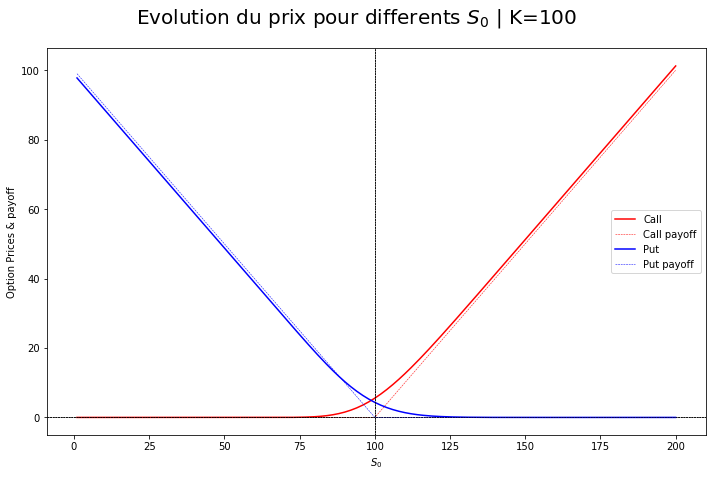

In [ ]:
call_p = list()
Z_c = list()
put_p = list()
Z_p = list()
prices = np.linspace(1, 200, 200)
for S in prices:
  call_p.append(Call(St=S).price())
  Z_c.append(Call(St=S).payoff())
  put_p.append(Put(St=S).price())
  Z_p.append(Put(St=S).payoff())

fig, ax = plt.subplots(figsize=(10,7))
display_figure(prices, call_p, "red", ax, ylabel="Option Prices", leglabel="Call")
display_figure(prices, Z_c, "red", ax, leglabel="Call payoff", linestyle="--", linewidth=0.5)

display_figure(prices, put_p, "blue", ax, leglabel="Put")
display_figure(prices, Z_p, "blue", ax, xlabel="$S_0$", leglabel="Put payoff", linestyle="--", linewidth=0.5)

plt.figtext(.5,.9,r"Evolution du prix pour differents $S_{0}$ | K=100", fontsize=20, ha='center')
fig.subplots_adjust(top=0.85)

## Payoff & Call Price Evolution | $S_0 = 187$, $K=[140,240]$, $T= \{4d, 95d, 340d\}$

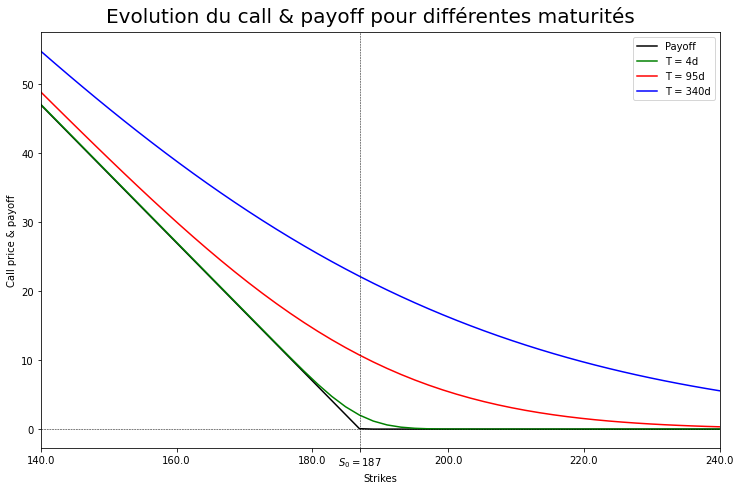

In [ ]:
Z = list()
call_T4 = list()
call_T95 = list()
call_T340 = list()
strikes = np.linspace(140, 240, 50)
for K in strikes:
    call_T4.append(Call(St = 187,K = K,T = "4d").price()) 
    call_T95.append(Call(St = 187,K = K,T = "95d").price())
    call_T340.append(Call(St = 187,K = K,T = "340d").price())
    Z.append(Call(St = 187,K = K,T = "95d").payoff()) # Payoff for T=95d
fig, ax = plt.subplots(figsize = (10,7))
ax.plot(strikes, Z, color="black", label="Payoff")
ax.plot(strikes, call_T4, color="green", label="T = 4d")
ax.plot(strikes, call_T95, color="red", label="T = 95d")
ax.plot(strikes, call_T340, color="blue", label="T = 340d")
fig.tight_layout()
plt.figtext(.5,.9,"Evolution du call & payoff pour différentes maturités", fontsize=20, ha='center')
plt.xlabel("Strikes")
plt.ylabel("Call price & payoff")
xt = ax.get_xticks()
xt=np.append(xt,187)
xtl=xt.tolist()
xtl[-1] = r"$S_0 = 187$"
ax.set_xticks(xt)
ax.set_xticklabels(xtl)
ax.set_xlim(xmin=140, xmax=240)
ax.axvline(x=187, color="black", linestyle="--", linewidth = 0.5)
ax.axhline(y=0, color="black", linestyle="--", linewidth = 0.5)
leg = ax.legend()
fig.subplots_adjust(top=0.88)
plt.show()

## Profit & Payoff | Long/Short Call & Long/Short Put | $K = 100$, $S_0 =[0,200]$, $T = 90d$

In [ ]:
# Fonction permettant d'afficher les payoffs et proft pour cette sous-partie
def display_profit_payoff(prices, payoff, profit, p, ax, title, long=True):
    ax.plot(prices, payoff, color="black", label="Payoff")
    ax.plot(prices, profit, color="red", label="Profit", linestyle="--")
    fig.tight_layout()
    ax.title.set_text(title)
    ax.set_xlabel("$S_T$")
    ax.set_ylabel("Payoff & profits")
    xt = ax.get_xticks()
    xt = np.delete(xt, np.where(xt==100))
    xt=np.append(xt,100)
    xtl=xt.tolist()
    xtl[-1]="So = 100"
    ax.set_xticks(xt)
    ax.set_xticklabels(xtl)
    yt = ax.get_yticks()
    if long:
      yt=np.append(yt,-p)
    else:
      yt=np.append(yt,p)
    ytl=yt.tolist()
    if long:
      ytl[-1]="- p"
    else:
      ytl[-1]="p"
    ax.set_yticks(yt)
    ax.set_yticklabels(ytl)
    ax.axvline(x=100, color="black", linestyle="--", linewidth = 0.5)
    ax.axhline(y=0, color="black", linestyle="--", linewidth = 0.5)
    ax.set_xlim(xmin=0, xmax=200)
    leg = ax.legend()

## Long/Short Call

In [ ]:
Z_long_call = list()
prices = np.linspace(1, 200, 100)
call_So = Call().price() # Call price for So = 100
for S in prices:
    call = Call(St = S)
    Z_long_call.append(call.payoff())

profit_long_call = np.array(Z_long_call) - call_So # Le profit est le payoff moins la prime payée au début 
Z_short_call = -np.array(Z_long_call) # Le payoff vendeur est l'opposé du acheteur
profit_short_call = Z_short_call + call_So# le vendeur recoit la prime au début

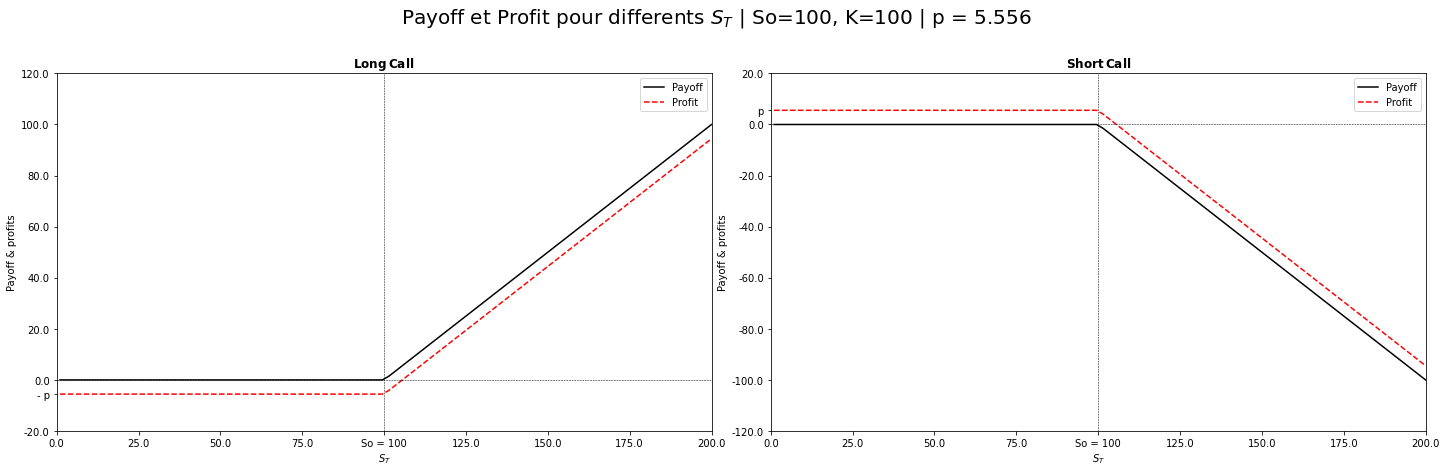

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(20,7))
display_profit_payoff(prices, Z_long_call, profit_long_call, call_So, ax[0], r"$\bf{Long \, Call}$")
display_profit_payoff(prices, Z_short_call, profit_short_call, call_So, ax[1], r"$\bf{Short \, Call}$", long=False)
plt.figtext(.5,.9,f"Payoff et Profit pour differents $S_T$ | So=100, K=100 | p = {round(call_So,3)}", fontsize=20, ha='center')
fig.subplots_adjust(top=0.80)
plt.show()

## Long/Short Put

In [ ]:
Z_long_put = list()
prices = np.linspace(1, 200, 100)
put_So = Put().price() 
for S in prices:
    put = Put(St = S)
    Z_long_put.append(put.payoff())

profit_long_put = np.array(Z_long_put) - put_So
Z_short_put = -np.array(Z_long_put)
profit_short_put = Z_short_put + put_So

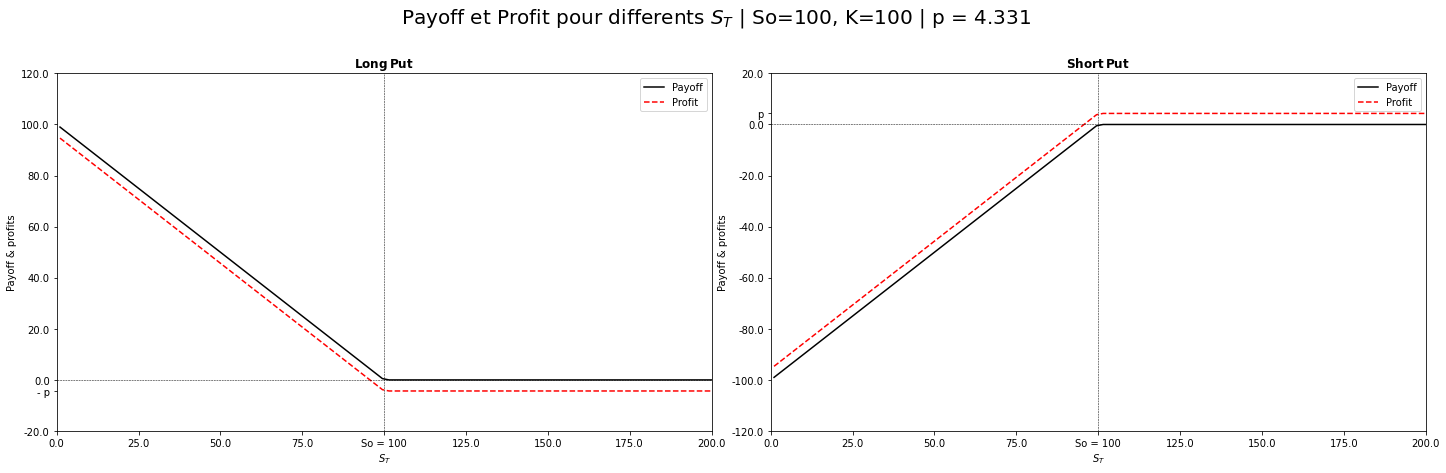

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(20,7))
display_profit_payoff(prices, Z_long_put, profit_long_put, put_So, ax[0], r"$\bf{Long \, Put}$")
display_profit_payoff(prices, Z_short_put, profit_short_put, put_So, ax[1], r"$\bf{Short \, Put}$", long=False)
plt.figtext(.5,.9,f"Payoff et Profit pour differents $S_T$ | So=100, K=100 | p = {round(put_So,3)}", fontsize=20, ha='center')
fig.subplots_adjust(top=0.80)
plt.show()

## Evolution des Greeks pour un Call avec $S_0 = [0,200]$

#### Delta et $T = \{5d, 90d, 340d\}$


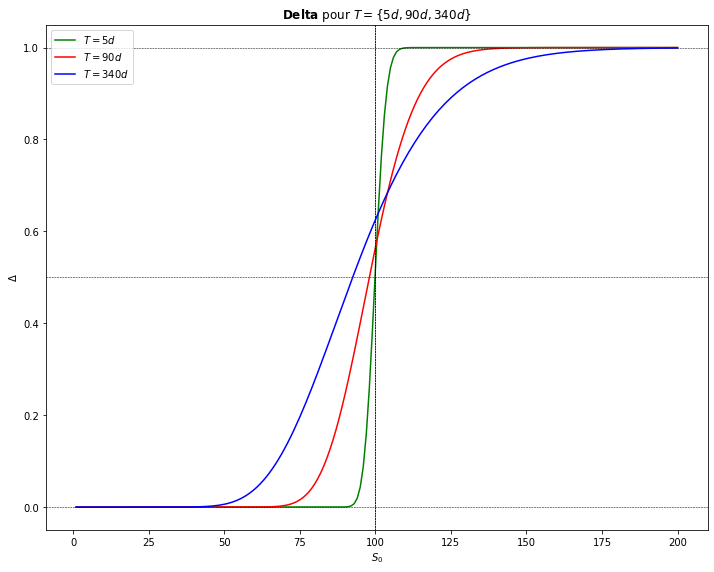

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
deltas_T5 = []
deltas_T90 = []
deltas_T350 = []
prices = np.linspace(1, 200, 200)
for S in prices:
    deltas_T5.append(Call(St=S, T="5d").delta())
    deltas_T90.append(Call(St=S, T="90d").delta())
    deltas_T350.append(Call(St=S, T="350d").delta())
display_figure(prices, deltas_T5, "green", ax, leglabel=r"$T=5d$", title=r"$\bf{Delta}$ pour $T = \{5d, 90d, 340d\}$", hliney=0.5)
display_figure(prices, deltas_T90, "red", ax, leglabel=r"$T=90d$", hliney=1)
display_figure(prices, deltas_T350, "blue", ax, xlabel="$S_0$", leglabel=r"$T=340d$", ylabel="$\Delta$")

#### Gamma et $T = \{5d, 90d, 340d\}$

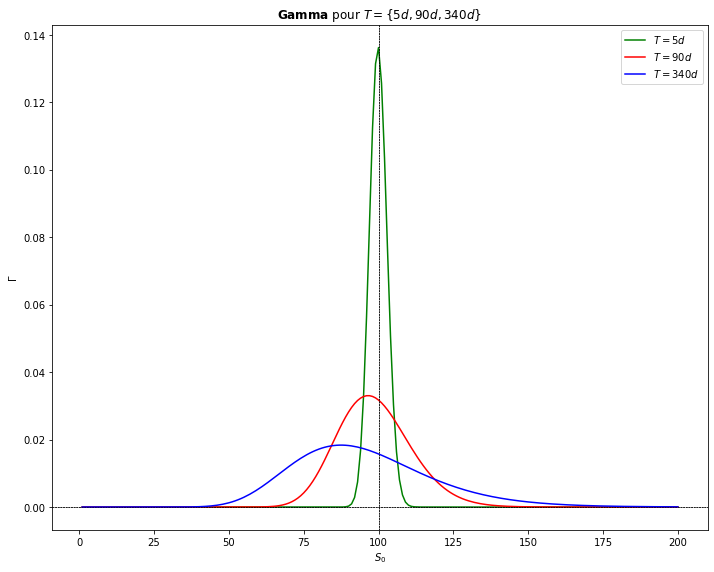

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
gammas_T5 = []
gammas_T90 = []
gammas_T350 = []
prices = np.linspace(1, 200, 200)
for S in prices:
    gammas_T5.append(Call(St=S, T="5d").gamma())
    gammas_T90.append(Call(St=S, T="90d").gamma())
    gammas_T350.append(Call(St=S, T="340d").gamma())
display_figure(prices, gammas_T5, "green", ax, leglabel=r"$T=5d$", title=r"$\bf{Gamma}$ pour $T = \{5d, 90d, 340d\}$")
display_figure(prices, gammas_T90, "red", ax, leglabel=r"$T=90d$")
display_figure(prices, gammas_T350, "blue", ax, xlabel="$S_0$", leglabel=r"$T=340d$", ylabel="$\Gamma$")

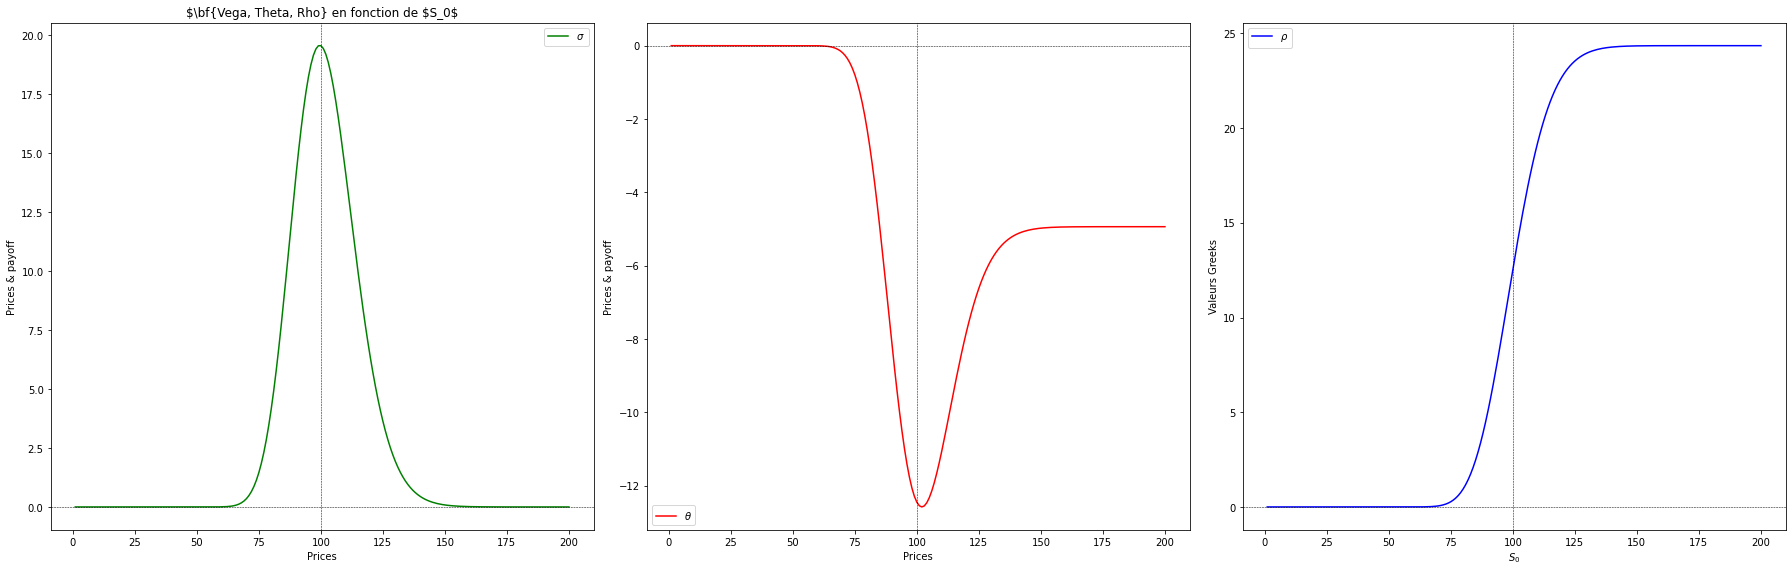

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(25,8))
vega = []
theta = []
rho = []
prices = np.linspace(1, 200, 200)
for S in prices:
    vega.append(Call(St=S).vega())
    theta.append(Call(St=S).theta())
    rho.append(Call(St=S).rho())
display_figure(prices, vega, "green", ax[0], leglabel=r"Vega", title=r"$\bf{Vega, Theta, Rho} en fonction de $S_0$")
display_figure(prices, theta, "red", ax[1], leglabel=r"$\theta$")
display_figure(prices, rho, "blue", ax[2], xlabel=r"$S_0$", leglabel=r"$\rho$", ylabel="Valeurs Greeks")

# <center> Classes de Monte Carlo <center/>

In [ ]:
class MonteCarloBS(object):
    """ Classe d'initialisation et des principales fonctions servant aux classes filles de pricing d'options par MonteCarlo."""

    # Initialisation de nos paramètres 
    def __init__(self, N, So, K, T, sigma, r, var_antithetic, var_control, display_text, call=True, put=False):
        self.N = N
        self.So = So
        self.K = K
        self.T = T
        self.sigma = sigma
        self.r = r
        self.h_x = np.zeros(self.N)
        self.iscall = call
        self.isput = put
        self.cum_var = np.zeros(self.N)
        self.display_text = display_text
        if var_antithetic:
          # On va utiliser N/2 comme nombre d'échantillons dans le cas des variables antithétiques
          self.split = int(self.N/2)
        if self.display_text:
          self.display_init(var_antithetic, var_control)

    def display_init(self, var_antithetic, var_control):
      """Affichage de l'initialisation"""
      reduct_var = "Aucune réduction de variance."
      if "Asian" or "Barrier" in self.__class__.__name__:
        sim_str = "Nombre de simulations de trajectoires :"
      else:
        sim_str = "Nombres de simulations : "
      if var_antithetic and var_control:
        reduct_var = " Réduction de variance par variables antithétiques et de controle."
      elif var_antithetic:
        reduct_var = "Réduction de variance par variables antithétiques."
      elif var_control:
        reduct_var = "Réduction de variance par variables de controles."
      elif "DownAndIn" in self.__class__.__name__:
        if self.mc_cond:
          reduct_var = "Réduction de variance par Monte Carlo conditionnel."
      if self.iscall and self.isput==False:
        print(f"{'-'*15} {self.__class__.__name__}(Call) {'-'*15}\n{sim_str} {self.N}. {reduct_var}")
      elif self.iscall==False and self.isput:
        print(f"{'-'*15} {self.__class__.__name__} (Put){'-'*15}\n{sim_str} {self.N}. {reduct_var}")
      elif self.iscall and self.isput:
        print(f"{'-'*15} {self.__class__.__name__} (Call & Put){'-'*15}\n{sim_str} {self.N}. {reduct_var}")
      if "European" in self.__class__.__name__ and var_control:
        print("La reduction de variance dans le cadre du call européen n'a pas encore été implémentée.")

    def display_results(self, h_x, res, var_anth=False):
      """Affichage des résultats à l'instanciation"""
      if self.display_text:
        if var_anth:
          print(f"Avec variale anthithétiques, {self.split} simulations.")
          print(f"Ecart-type m1(X) : {np.sqrt(self.var_est(self.m1))}")
          print(f"Ecart-type m2(X) : {np.sqrt(self.var_est(self.m2))}")
          print(f"Cov(m1,m2) = {np.cov(self.m1, self.m2)[0,1]}")
        print(f"Ecart-type h(X): {np.round(np.sqrt(self.var_est(h_x)),3)}")
        print(f"Estimation : {res}")
        print(f"Intervalle de confiance (95%) : [{np.round(self.IC(0.05, h_x, res)[0],3)},{np.round(self.IC(0.05, h_x, res)[1],3)}]")
        print("\n")

    def var_est(self, h_x): # cohérent avec np.var
        """Fonction utilisant l'algorithme stable pour déterminer la variance de notre estimateur"""
        m = h_x[0]
        d = 0
        for i in range(2, len(h_x)+1):
            delta = h_x[i-1] - m
            m += delta/(i)
            d += ((i)-1)/(i)*(delta**2)
        s_square = d/(len(h_x) - 1)
        return s_square

    def IC(self, alpha, h_x, res): # alpha = 0.05 -> 95%
        """Fonction déterminant l'intervalle de confiance pour un C_n"""
        lower = res - (stats.norm.ppf(1-(alpha/2), loc=0, scale=1) * np.sqrt(self.var_est(h_x)/self.N))
        upper = res + (stats.norm.ppf(1-(alpha/2), loc=0, scale=1) * np.sqrt(self.var_est(h_x)/self.N))
        return lower, upper

#-------------------------------------------------------------------------------------------------------------------------------------------------------------------
class MonteCarloBSPathDependant(MonteCarloBS):
  """Classe fille prenant en compte les dates discrètes en entrée (date >= aujourd'hui et <= maturité obligatoire).
     Changements : - Le nombre de simulations N est désormais "nb_sim_path" : self.N = nb_sim_path
                   - Dates et maturité T est à donner soit en date (ex:"25/12/2020") soit en fraction d'année (ex:0.5 pour 6mois)"""

  def __init__(self, dates, nb_sim_path, So, K, T, sigma, r, var_antithetic, var_control, display_text, fix_seed, all_days, kind_pandas): 
    # Date d'aujourd'hui et .normalize() pour ne pas prendre en compte les heures,minutes,secondes
    today = pd.to_datetime("today").normalize()

    # On retourne une erreur si on ne veut pas de DataFrame mais que l'utilisateur donne de "vraies" dates
    if ((any(type(x) is str or "Timestamp" in str(type(x)) for x in dates)) or (type(T) is str or "Timestamp" in str(type(T)))) and kind_pandas==False:
      raise TypeError("Arugment kind_pandas mis à False : pas possible d'avoir de dates/maturité en Timestamp/string.")

    if kind_pandas:
      # Dates en Timestamp -> fraction d'années le cas échéant
      if any(type(x) is str or "Timestamp" in str(type(x)) for x in dates):
        self.dates = np.unique([(pd.to_datetime(date,dayfirst=True) - today).total_seconds()/pd.Timedelta(days=365).total_seconds() if type(date)==str or "Timestamp" in str(type(date)) else date for date in dates])
      else:
        self.dates = np.unique(dates)

      # Dates en fraction d'années -> Timestamp le cas échéant
      if any(type(x) is float or type(x) is int or "float" in str(type(x)) for x in dates):
        self.dates_tsp = [today + pd.Timedelta(days=date*365) if type(date)==float or type(date)==int or "float" in str(type(date)) else date for date in dates]
      else:
        self.dates_tsp = dates
      # dayfirst pour dates européennes, on trie et supprime les doublons
      self.dates_tsp = pd.to_datetime(self.dates_tsp, dayfirst=True).unique().sort_values()

      # On enleve la date So si donnée en date d'observation car ne peut pas être comprise dans la moyenne
      if today in self.dates_tsp.normalize(): 
        self.dates_tsp = self.dates_tsp.drop(today)
      if self.dates_tsp.min() < today: raise ValueError("Une date rentrée est inférieure à aujourd'hui.")
    else:
      self.dates = np.array(dates)

    # Convertion de T (str/Timestamp <-> fraction d'années)
    if type(T) is str or "Timestamp" in str(type(T)):
      self.T_tsp = pd.to_datetime(T, dayfirst=True) # pour avoir la date de maturité
      T = (self.T_tsp - today).total_seconds()/pd.Timedelta(days=365).total_seconds() # On calcule T en temps que fraction d'année par rapport à auj
    else:
      self.T_tsp = today + pd.Timedelta(days=T*365) # pour avoir la date de maturité
    if pd.to_datetime(dates, dayfirst=True).max() > self.T_tsp or max(self.dates) > T: raise ValueError("Date entrée supérieure à la maturité") 

    # Initialisation de la classe parent
    super().__init__(nb_sim_path, So, K, T, sigma, r, var_antithetic, var_control, display_text)

    # Création de l'index de dates | initialisation de l'array de différence de jours de dates en fraction d'années
    if kind_pandas:
      if all_days==False:
        # On trie les dates par ordre croissant en y rajoutant le So d'aujourd'hui
        self.index = self.dates_tsp.insert(0, today).sort_values()
        # On rajoute le S_T s'il n'est pas déja donné en dates d'observations (oblige à rajouter une date pour l'option asiatique mais faible coût)
        self.index = self.index.insert(-1, self.T_tsp).sort_values() if self.T_tsp not in self.dates_tsp else self.index.sort_values() 
        self.diffdays = np.array([(self.index[i] - self.index[i-1]).total_seconds()/pd.Timedelta(days=365).total_seconds() for i in range(1, self.index.shape[0])])
        # On cherche à avoir les index de nos dates discrètes dans l'array numpy de simulations de trajectoires
        self.loc_dates = [self.index.get_loc(self.dates_tsp[i]) for i in range(len(self.dates_tsp))]  
      else: 
        # On simule tous les jours (seulement les jours sont pris en compte)
        self.index = pd.date_range(start=today, end=self.T_tsp)
        self.diffdays = np.array([1/365 for i in range(1, self.index.shape[0])])
        # Index des dates correspondant seulement aux jours d'observations -> Permet d'isoler les dates d'observations de S_0 et S_T (si non donnée en date)
        self.loc_dates = [self.index.get_loc(self.dates_tsp[i].normalize()) for i in range(len(self.dates_tsp))]  
    else:
      # Si seulement des dates en fraction d'années données en entrée
      dates = np.insert(dates,0,0,axis=0) # On ajoute aujourd'hui comme étant t=0
      dates = np.insert(dates, -1, T, axis=0) # On ajoute la date de maturité (oblige à rajouter une date pour l'option asiatique mais faible coût)
      dates = np.unique(dates) # Trie et supprime les doublons
      self.index = dates
      self.diffdays = np.array([dates[i] - dates[i-1] for i in range(1,len(dates))])
      # On selectionne les dates d'observations
      if self.T in self.dates:
        self.loc_dates = np.arange(1,len(self.index))
      else:
        self.loc_dates = np.arange(1,len(self.index)-1)

    # Initialisation de l'array de trajectoires SPath
    self.Spath = np.zeros((len(self.index),nb_sim_path))

    # On print l'initialisation de l'instance
    if display_text and kind_pandas: print(f"Pour les dates d'observations : {list(self.dates_tsp.strftime('%d/%m/%Y'))}. Maturité: {self.T_tsp.strftime('%d/%m/%Y')}")

    # Calcul de notre estimation dans le cas classique (dans __init__ pour avoir une estimation par instance)
    if var_antithetic==False and var_control==False:
      if fix_seed: np.random.seed(25);
      x = np.random.normal(0,1,size=(len(self.index), nb_sim_path))
      for sim in range(nb_sim_path):
        self.Spath[:,sim] = self.simule_path(x[:,sim])
      self.h_x = self.compute_h_x(self.Spath)
      self.res = np.average(self.h_x)
      self.display_results(self.h_x, self.res)

  def simule_path(self, x):
    """ Simulation de trajectoire (brownien géométrique) entre [S_0, S_T] avec S_1,...,S_N. (on peut avoir S_N=S_T)."""
    path = np.zeros(len(self.index))
    path[0] = self.So
    for i in range(1,len(self.index)):                                                          # (Bti - Bti-1) ~ N(0, ti - ti-1)
        path[i] = path[i-1]*np.exp((self.r-0.5*self.sigma**2)*self.diffdays[i-1] + self.sigma*(np.sqrt(self.diffdays[i-1])*x[i]))  
    return path

#--------------------------------------------------------------------------------------------------------------------------------------------------------------------
#------------------------------------------------------------- EUROPEAN OPTION MC -----------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------
class MonteCarloBS_European(MonteCarloBS):
  """Monte Carlo classique pour option européenne. N représente le nombre de simulations."""

  def __init__(self, N=1000, So=100, K=100, T=90/365, sigma=0.25, r=0.05, var_antithetic=False, display_text=False, fix_seed=False, call=True, put=False):
    super().__init__(N, So, K, T, sigma, r, var_antithetic, False, display_text, call, put)
    if var_antithetic==False:
      if fix_seed: np.random.seed(25)
      x = np.random.normal(0,1, size=self.N)
      # Fonction mise ici pour avoir une seule estimation par objet
      if self.iscall: 
        # On estime notre vecteur de payoff et sa moyenne -> estimation
        self.h_x, self.res = self.estimate(self.N, x, iscall=True)
        if display_text:
          if self.iscall and self.isput: print("Call :")
          # On affiche nos résultats
          self.display_results(self.h_x, self.res)
      if self.isput: 
        self.h_x_p, self.res_p = self.estimate(self.N, x, iscall=False)
        if display_text:
          if self.iscall and self.isput: print("Put :")
          # on affciche nos résultats
          self.display_results(self.h_x_p, self.res_p)

    # Variable antithétiques (voir asiatique pour commentaires)
    elif var_antithetic:
      if fix_seed: np.random.seed(25)
      x = np.random.normal(0,1,size=self.N)
      self.m1 = np.zeros(self.split)
      self.m2 = np.zeros(self.split)
      if self.iscall:
        self.h_x , self.res = self.estimate(self.N, x, iscall=True)
        self.m1, self.resm1 = self.estimate(self.split, x[:self.split], iscall=True)
        self.m2, self.resm2 = self.estimate(self.split, -x[:self.split], iscall=True)
        self.h_x_m1m2 = (self.m1+self.m2)/2
        self.res_m1m2 = np.average(self.h_x_m1m2)
        if display_text:
          if self.iscall and self.isput: print("Call :")
          self.display_results(self.h_x_m1m2, self.res_m1m2, var_anth=True)
          print(f"Cas sans réduction (avec {self.N} simulations):")
          self.display_results(self.h_x, self.res)
      if self.isput:
        self.h_x_p , self.res_p = self.estimate(self.N, x, iscall=False)
        self.m1_p, self.resm1_p = self.estimate(self.split, x[:self.split], iscall=False)
        self.m2_p, self.resm2_p = self.estimate(self.split, -x[:self.split], iscall=False)
        self.h_x_p_m1m2 = (self.m1_p+self.m2_p)/2
        self.res_p_m1m2 = np.average(self.h_x_p_m1m2)
        if display_text:
          if self.iscall and self.isput: print("Put :")
          self.display_results(self.h_x_p_m1m2, self.res_p_m1m2, var_anth=True)
          print(f"Cas sans réduction (avec {self.N} simulations):")
          self.display_results(self.h_x_p, self.res_p)

  def estimate(self, N, x, iscall):
    """Fonction retournant l'estimation de Monte-Carlo"""
    h_x = np.zeros(N)
    if iscall:
      h_x = np.exp(-self.r*self.T)*np.maximum((self.So*np.exp((self.r-0.5*self.sigma**2)*self.T + self.sigma*np.sqrt(self.T)*x) - self.K),0)
      return h_x, np.average(h_x)
    else:
      h_x = np.exp(-self.r*self.T)*np.maximum(self.K - (self.So*np.exp((self.r-0.5*self.sigma**2)*self.T + self.sigma*np.sqrt(self.T)*x)),0)
      return h_x, np.average(h_x)

  def plot_convergence(self, alpha):
      """Convergence de l'estimateur de montecarlo actuel par somme cummulée de h(Xi) (donc seulement pour une estimation)"""
      conv = np.cumsum(self.h_x)/(np.arange(self.N)+1) # cumsum pour somme cummulée
      fig, ax = plt.subplots(1,1,figsize=(20,8))
      p_dll = Call(St=self.So,K=self.K,T="90d",t=0,sigma=self.sigma,r=self.r).price() # Le prix du call avec formule fermée
      plt.plot(np.linspace(1,self.N, self.N), conv, label=r'$h(X_n)/n$')
      # Intervalle de confiance général de notre estimateur
      conv_lower = conv - (stats.norm.ppf(1-(alpha/2), loc=0, scale=1) * np.sqrt(self.var_est(self.h_x)/self.N))
      conv_upper = conv + (stats.norm.ppf(1-(alpha/2), loc=0, scale=1) * np.sqrt(self.var_est(self.h_x)/self.N))
      ax.set_ylim(p_dll-1,p_dll+1)
      plt.fill_between(np.linspace(1,self.N, self.N), conv_lower, conv_upper,color='#91DAC3') # On affiche les intervalles de confiance
      plt.hlines(p_dll, 1, self.N, label=r'$BS_{call}$', color="red") # Ligne horizontale représentant le prix du "vrai" call
      ax.set(title=f"Convergence du calcul du call par la méthode de Monte Carlo, N = {self.N}", xlabel='N', ylabel="Call price")
      plt.legend()
      plt.show()


#-------------------------------------------------------------------------------------------------------------------------------------------------------------------
#------------------------------------------------------------- BASKET OPTION MC -----------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------------------------------------------------------------------
class MonteCarloBS_Basket(MonteCarloBS):
  def __init__(self, N=1000, eval = "Max", So=[100,100], K=100, sigma=[0.25, 0.25], r=0.05, T=1, rho=-0.5, display_text=False, call=True, put=False):
    # On traite le cas de la matrice de corrélation
    if type(rho) == float or type(rho) == int:
      if np.array([So]).shape[1] == 2 and np.array([rho]).shape[0] == 1:
        self.Mcov = np.array([1,rho,rho,1]).reshape((2,2))
      else:
        raise ValueError("La panier ne contient pas 2 actifs.")
    else:
      if rho.shape[0] != np.array([So]).shape[1] or np.array([So]).shape[1] == 1:
        raise ValueError("La dimension de la matrice de corrélation ne correspond pas au nombre d'actifs.")
      elif np.array([So]).shape[1] > 2 and rho.shape[0] == np.array([So]).shape[1]:
        self.Mcov = rho

    # Initialisation des arguments
    super().__init__(N, So, K, T, sigma, r, False, False, display_text, call, put)
    self.eval = eval 
    self.assets_ST = np.zeros((len(self.So),self.N))
    self.h_x = np.zeros(self.N)
    B = np.random.normal(0,1,(len(self.So),self.N))
    L = np.linalg.cholesky(self.Mcov)
    W = L@B
    # Peut se calculer directement en vectoriel aussi
    for i in range(self.N):
      for asset in range(len(self.So)):
        self.assets_ST[asset,i] = self.So[asset]*np.exp((self.r-0.5*sigma[asset]**2)*self.T + sigma[asset]*np.sqrt(self.T)*W[asset,i])

    # On calcule et affiche nos résultats
    if self.iscall:
      self.compute_h_x(self.assets_ST, True)
      if display_text:
        if self.iscall and self.isput: print("Call :")
        self.display_results(self.h_x, self.res)
    if self.isput:
      self.compute_h_x(self.assets_ST, False)
      if display_text:
        if self.iscall and self.isput: print("Put :")
        self.display_results(self.h_x, self.res)

  def compute_h_x(self, assets_ST, iscall):
    if iscall:
      if "max" in self.eval.lower():
        self.h_x = np.exp(-self.r*self.T)*np.maximum(np.apply_along_axis(np.max, 0, assets_ST) - self.K, 0)
      elif "min" in self.eval.lower():
        self.h_x = np.exp(-self.r*self.T)*np.maximum(np.apply_along_axis(np.min, 0, assets_ST) - self.K, 0)
      elif "mean" in self.eval.lower() or "moy" in self.eval.lower():
        self.h_x = np.exp(-self.r*self.T)*np.maximum(np.apply_along_axis(np.mean,0, assets_ST) - self.K, 0)
    else:
      if "max" in self.eval.lower():
        self.h_x = np.exp(-self.r*self.T)*np.maximum(self.K - np.apply_along_axis(np.max, 0, assets_ST), 0)
      elif "min" in self.eval.lower():
        self.h_x = np.exp(-self.r*self.T)*np.maximum(self.K - np.apply_along_axis(np.min, 0, assets_ST), 0)
      elif "mean" in self.eval.lower() or "moy" in self.eval.lower():
        self.h_x = np.exp(-self.r*self.T)*np.maximum(self.K - np.apply_along_axis(np.mean,0, assets_ST), 0)
    self.res = np.average(self.h_x)

#-------------------------------------------------------------------------------------------------------------------------------------------------------------------
#------------------------------------------------------------- ASIAN OPTION MC -----------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------------------------------------------------------------------
# POUR LINSTANT ON FAIT QUE LE CALL ICI 
class MonteCarloBS_Asian(MonteCarloBSPathDependant): 
  """Estimateur de MonteCarlo pour les options asiatiques. 
     Estimation classique calculée dans classe parente."""

  def __init__(self, dates, So=100, K=100, T=1, sigma=0.25, r=0.05, nb_sim_path=1000, var_antithetic=False, var_control=False, display_text=False, 
               known_Zesp = False, fix_seed=False, all_days=False, kind_pandas=True):
        super().__init__(dates, nb_sim_path, So, K, T, sigma, r, var_antithetic, var_control, display_text, fix_seed, all_days, kind_pandas)

      # Estimation classique dans la classe parente

      # Variables antithétiques
        if var_antithetic:
          # On créé les deux arrays de trajectoires pour m1 et m2
          Spath1 = np.zeros((len(self.index), self.split)) 
          Spath2 = np.zeros((len(self.index), self.split))
          # Les vecteurs de payoff correspondants à m1 et m2
          self.m1 = np.zeros(self.split)
          self.m2 = np.zeros(self.split)
          if fix_seed: np.random.seed(25);
          x = np.random.normal(0,1,size=(len(self.index), nb_sim_path))
          # Trajectoires pour h_x, m1 et m2
          for sim in range(nb_sim_path):
            self.Spath[:, sim] = self.simule_path(x[:,sim])
            if sim <= self.split - 1: # On s'arrête à N/2
              Spath1[:,sim] = self.simule_path(x[:,sim])
              Spath2[:,sim] = self.simule_path(-x[:,sim])
          # On calcule nos vecteurs m1 et m2
          self.m1 = self.compute_h_x_anth(Spath1)
          self.m2 = self.compute_h_x_anth(Spath2)
          # Estimateur avec variance réduite et affichage des résultats
          self.h_x_m1m2 = (self.m1+self.m2)/2 
          self.res_m1m2 = np.average(self.h_x_m1m2)
          self.display_results(self.h_x_m1m2, self.res_m1m2, var_anth=True)
          # Cas sans réduction et affichage des résultats
          if display_text: print(f"Cas sans réduction : (avec {self.N} simulations):")
          self.h_x = self.compute_h_x(self.Spath)
          self.res = np.average(self.h_x)
          self.display_results(self.h_x, self.res)

      # Variables de controle
        elif var_control:
          if known_Zesp and display_text: print("Avec E[Z_1], E[Z_2] et E[Z_3] connues.")
          if fix_seed: np.random.seed(25);
          x = np.random.normal(0,1,size=(len(self.index), nb_sim_path))
          # Trajectoires
          for sim in range(nb_sim_path):
            self.Spath[:,sim] = self.simule_path(x[:,sim])
          # On calcule les Zi
          self.Z1 = np.array([self.Spath[-1, sim] for sim in range(self.N)]) # S_T
          self.Z2 = np.array([np.average(self.Spath[self.loc_dates, sim]) for sim in range(self.N)]) # 1/N(sum St_i)
          self.Z3 = np.array([np.exp(-self.r*self.T)*np.maximum(self.Spath[-1, sim]-self.K, 0) for sim in range(self.N)]) # exp(-rT)(S_T - K)+
          # On calcule notre vecteur de payoffs classiques
          self.h_x = self.compute_h_x(self.Spath)
          # Pour Z1
          if known_Zesp:
            espZ1 = self.So*np.exp(self.r*self.T) # On connait E[Z1]
          else:
            espZ1 = np.average(self.Z1) # revient a faire un MonteCarlo
          cov_h_Z1 = np.cov(self.h_x, self.Z1)[0,1]
          c1 = -(cov_h_Z1/self.var_est(self.Z1))
          self.h_Z1 = self.h_x + c1*(self.Z1 - espZ1)
          self.resZ1 = np.average(self.h_Z1)
          self.display_results_Z(1, "S_T", espZ1, cov_h_Z1, c1, self.h_Z1, self.resZ1)
          # Pour Z2
          if known_Zesp:
            if 0 in self.dates:
              dates = np.delete(self.dates,0) # on supprime S_0 qui n'est pas compris dans les dates d'observations
            else:
              dates = self.dates
            espZ2 = self.So*np.average(np.exp(self.r*dates)) # self.dates contient les ti
          else:
            espZ2 = np.average(self.Z2)
          cov_h_Z2 = np.cov(self.h_x, self.Z2)[0,1]
          c2 = -(cov_h_Z2/self.var_est(self.Z2))
          self.h_Z2 = self.h_x + c2*(self.Z2 - espZ2)
          self.resZ2 = np.average(self.h_Z2)
          self.display_results_Z(2, "1/N(sum St_i)", espZ2, cov_h_Z2, c2, self.h_Z2, self.resZ2)
          # Pour Z3
          if known_Zesp:
            espZ3 = Call(St=self.So, K=self.K, T=self.T, r=self.r, sigma=self.sigma).price()
          else:
            espZ3 = np.average(self.Z3)
          cov_h_Z3 = np.cov(self.h_x, self.Z3)[0,1]
          c3 = -(cov_h_Z3/self.var_est(self.Z3))
          self.h_Z3 = self.h_x + c3*(self.Z3 - espZ3)
          self.resZ3 = np.average(self.h_Z3)
          self.display_results_Z(3, "exp(-rT)(S_T - K)+)", espZ3, cov_h_Z3, c3, self.h_Z3, self.resZ3)

          # Cas sans réduction et affichage des résultats
          if display_text: print("Cas sans réduction : ")
          self.res = np.average(self.h_x)
          self.display_results(self.h_x, self.res)

        # On transforme notre Spath en dataframe pandas (seulelemnt à la fin pour gain de temps de calcul)
        if kind_pandas: self.Spath = pd.DataFrame(self.Spath, index=self.index, columns=[f"sim_{sim+1}" for sim in range(nb_sim_path)])

  def display_results_Z(self, i, strfunc, esp, cov, c, h_Z, res_Z):
    """ Afficher les résultats pour les variables de controle"""
    if self.display_text:
      print(f"Pour Z{i} : {strfunc}:")
      print(f"E[Z{i}] = {esp}")
      print(f"Cov(h_x,Z{i}) = {cov}")
      print(f"c{i} = {c}")  
      self.display_results(h_Z, res_Z)

  def compute_h_x(self, Spath):                                 # loc_dates pour les dates d'observations seulement
    return np.array([np.exp(-self.r*self.T)*np.maximum(np.average(Spath[self.loc_dates, sim]) - self.K,0) for sim in range(self.N)]) 

  def compute_h_x_anth(self, Spath):                                                                            # On ne prend que le cas N/2 
    return np.array([np.exp(-self.r*self.T)*np.maximum(np.average(Spath[self.loc_dates, sim]) - self.K,0) for sim in range(self.split)]) 

#--------------------------------------------------------------------------------------------------------------------------------------------------------------------
#------------------------------------------------------------- UpAndOut OPTION MC ------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------
class MonteCarloBS_UpAndOut(MonteCarloBSPathDependant):
  """Classe pour option Up&Out avec dates discrètes.
     Estimation classique calculée dans classe parente PathDependant."""

                          # On ajoute notre variable M : barrière désactivante
  def __init__(self, dates, So=100, K=100, M=120, T=1, sigma=0.25, r=0.05, nb_sim_path=1000, display_text=False, 
               fix_seed=False, all_days=False, kind_pandas=True):
        self.M = M
        super().__init__(dates, nb_sim_path, So, K, T, sigma, r, False, False, display_text, fix_seed, all_days, kind_pandas) 

        # On transforme notre Spath en dataframe pandas
        if kind_pandas: self.Spath = pd.DataFrame(self.Spath, index=self.index, columns=[f"sim_{sim+1}" for sim in range(nb_sim_path)])
  
  def compute_h_x(self, Spath):                                                      # On ajoute la condition de la barrière                # nb_sim_path = self.N
    return np.array([np.exp(-self.r*self.T)*np.maximum(Spath[-1,sim] - self.K,0) if Spath[self.loc_dates, sim].max() < self.M else 0 for sim in range(self.N)]) 

#--------------------------------------------------------------------------------------------------------------------------------------------------------------------
#------------------------------------------------------------- DownAndIn OPTION MC ------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------
class MonteCarloBS_DownAndIn(MonteCarloBSPathDependant):
  """Classe pour option Down&In avec dates discrètes.
     Estimation classique calculée dans classe parente PathDependant."""

                          # On ajoute notre variable B : barrière activante      # mc_cond pour MonteCarlo conditionnel
  def __init__(self, dates, So=100, K=100, B=90, T=1, sigma=0.25, r=0.05, nb_sim_path=1000, mc_cond=False, display_text=False, 
               fix_seed=False, all_days=False, kind_pandas=True):
        self.B = B
        # On ne peut pas simuler tous les jours si notre but est d'utiliser MC conditionnel
        if all_days and mc_cond:
          raise AttributeError("Les arguments all_days et mc_cond ne peuvent pas être utilisés en même temps : on ne simulera jamais tous les jours dans le cas du MC conditionnel.")
        self.mc_cond = mc_cond

        if self.mc_cond: 
          self.index_p_cond = 0 # Permet de calculer directement h_x dans simule_path (équivalent à l'itération "sim")
          if 0 in dates:
            dates = np.delete(dates,0) # on supprime S_0 qui n'est pas compris dans les dates d'observations

        super().__init__(dates, nb_sim_path, So, K, T, sigma, r, False, False, display_text, fix_seed, all_days, kind_pandas)

        # On enleve les lignes correspondantes aux S_T dans l'array de trajectoires si on utilise MonteCarlo conditionnel
        if self.mc_cond: 
          self.Spath = self.Spath[:-1,:]
          self.index = self.index[:-1]
        # On transforme notre Spath en dataframe pandas
        if kind_pandas: self.Spath = pd.DataFrame(self.Spath, index=self.index, columns=[f"sim_{sim+1}" for sim in range(nb_sim_path)])
  
  def simule_path(self, x):
    if self.mc_cond:
      path = np.zeros(len(self.index))
      path[0] = self.So
      for i in range(1,len(self.index)-1):
          path[i] = path[i-1]*np.exp((self.r-0.5*self.sigma**2)*self.diffdays[i-1] + self.sigma*(np.sqrt(self.diffdays[i-1])*x[i])) # (Bti - Bti-1) ~ N(0, ti - ti-1) 
          if path[i] <= self.B:
            # On calcule directement le prix du Call(T - ti) actualisé à aujourd'hui (t=0)
            self.h_x[self.index_p_cond]  = np.exp(-self.r*self.dates[i-1])*Call(St=path[i], K=self.K, T=self.T, t=self.dates[i-1], sigma=self.sigma, r=self.r).price()
            break # On arrete de simuler les dates d'observations suivante
      self.index_p_cond += 1
      path[len(self.index)-1] = 0 # On met le ST à 0 dans le cas du MC conditionnel car il n'est pas utile de le simuler
      return path
    else:
      # On utilise la méthode de la classe parente si on est pas en MC conditionnel
      return super().simule_path(x)


  def compute_h_x(self, Spath):
    if self.mc_cond==False:                                                       # On ajoute la condition de la barrière                # nb_sim_path = self.N
      return np.array([np.exp(-self.r*self.T)*np.maximum(Spath[-1,sim] - self.K,0) if Spath[self.loc_dates, sim].min() <= self.B else 0 for sim in range(self.N)]) 
    else:
      return self.h_x # On retourne directement h_x car déja estimé dans la fonction simule_path (cela permet de ne pas changer le code de la classe parente)

## Détails pour Option Européénnes

### Comparaison

In [ ]:
p_dll = Call(St=100,K=100,T="90d",t=0,sigma=0.25,r=0.05).price() # Vrai prix du call
print(f"On rappelle la valeur trouvée avec notre librairie est : {p_dll}")

MC = MonteCarloBS_European(N=1000000, So=100, K=100, T=90/365, sigma=0.25, r=0.05, display_text=True)
c_est = MC.res

On rappelle la valeur trouvée avec notre librairie est : 5.555864832239791
--------------- MonteCarloBS_European(Call) ---------------
Nombre de simulations de trajectoires : 1000000. Aucune réduction de variance.
Ecart-type h(X): 8.206
Estimation : 5.5589230669366625
Intervalle de confiance (95%) : [5.543,5.575]




### $\sigma^{2}_{h(x)}$ (Algo stable) - Intervalle de confiance

In [ ]:
# Valeurs présentées sans arondis ici
s_square = MC.var_est(MC.h_x)
print(f"Notre variance à la volée est de {s_square}")
print(f"Notre écart type à la volée est {np.sqrt(s_square)}")
alpha = 0.05 # 95%
lower, upper = MC.IC(alpha, MC.h_x, MC.res)
print(f"Notre intervalle de confiance est de : \n[ {lower} ; {upper} ]")

Notre variance à la volée est de 67.22442711440455
Notre écart type à la volée est 8.199050378818546
Notre intervalle de confiance est de : 
[ 5.500301408288591 ; 5.601936022176723 ]


### Convergence vers le prix du call

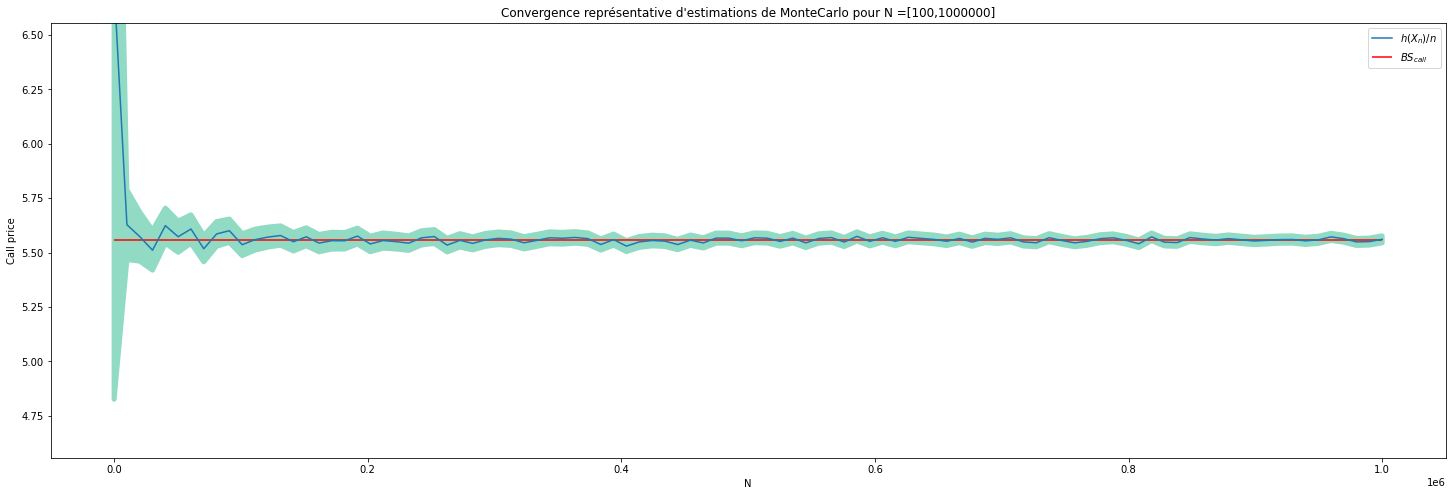

In [ ]:
# AVEC INTERVALLES DE CONFIANCE POUR CHAQUE N 
N = 1000000
alpha = 0.05
mcconv = list()
mcconv_lower = list()
mcconv_upper = list()
k = 0
for i in tqdm(np.linspace(100,N,100)): # On part de N = 100
    mc = MonteCarloBS_European(N=int(i))
    mcconv.append(mc.res) # Définition de notre liste pour chaque N
    # On aurait pu prendre directement la fonction IC de la classe
    mcconv_lower.append(mcconv[k] - (stats.norm.ppf(1-(alpha/2), loc=0, scale=1) * np.sqrt(mc.var_est(mc.h_x)/mc.N)))
    mcconv_upper.append(mcconv[k] + (stats.norm.ppf(1-(alpha/2), loc=0, scale=1) * np.sqrt(mc.var_est(mc.h_x)/mc.N)))
    k += 1

fig, ax = plt.subplots(1,1,figsize=(25,8))
p_dll = Call(St=100,K=100,T="90d",t=0,sigma=0.25,r=0.05).price()
plt.plot(np.linspace(100,N, 100), mcconv, label=r'$h(X_n)/n$')
ax.set_ylim(p_dll-1,p_dll+1)
plt.fill_between(np.linspace(100,N, 100), mcconv_lower, mcconv_upper,color='#91DAC3', linewidth=5) # Intervalles de confiance
plt.hlines(p_dll, 1, mc.N, label=r'$BS_{call}$', color="red") # Ligne horizontale représentant le prix du "vrai" call
ax.set(title=f"Convergence représentative d'estimations de MonteCarlo pour N =[100,{mc.N}]", xlabel='N', ylabel="Call price")
plt.legend()
plt.show()

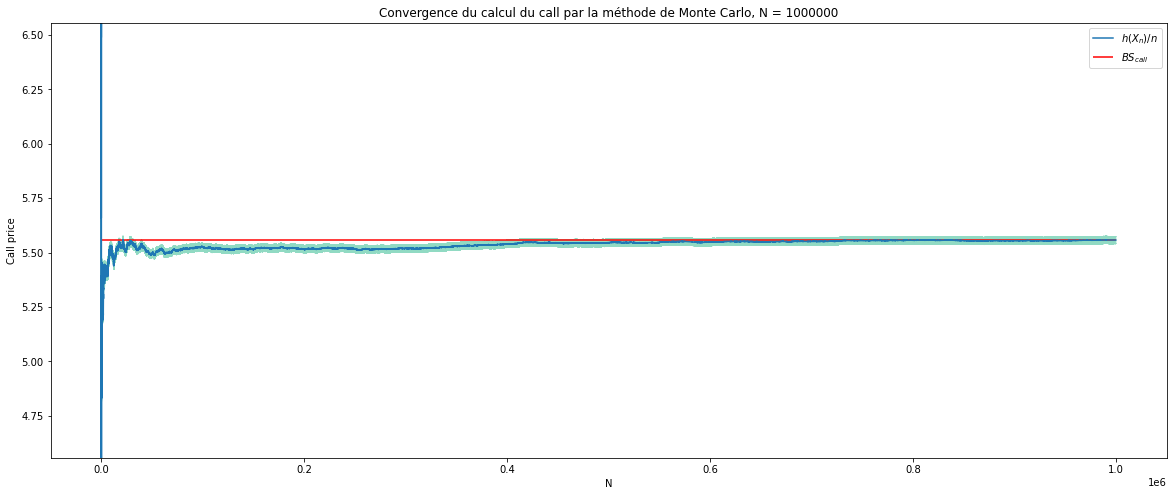

In [ ]:
# Intervalle de confiance général ajouté ici
MC.plot_convergence(alpha=0.05)

### Normalité asymptotique

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


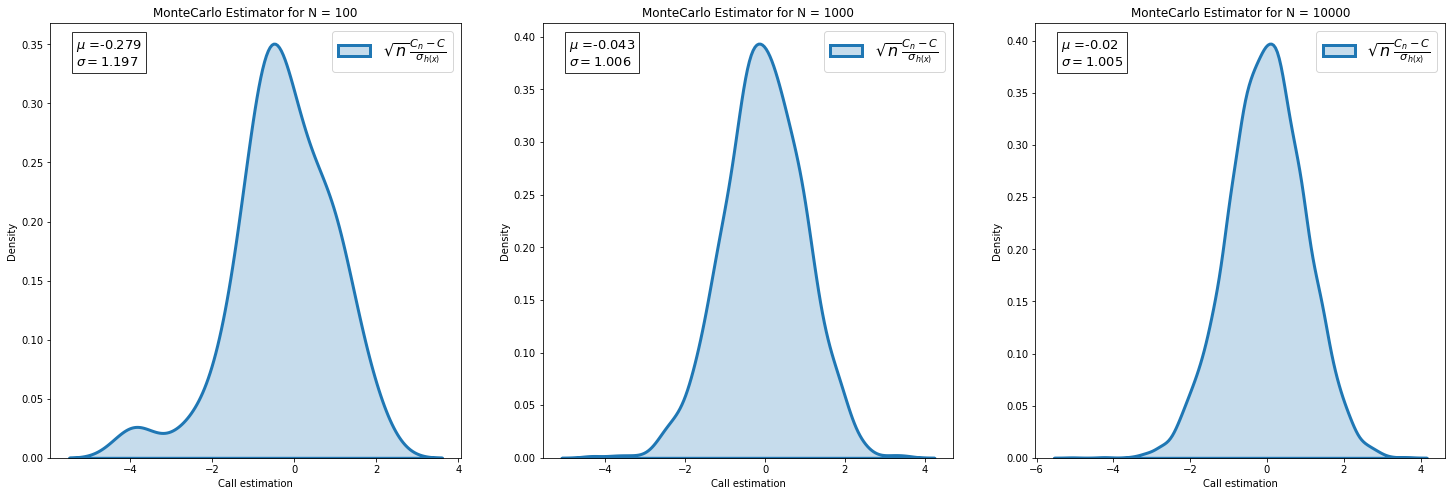

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(25,8))
N = 100
for toplot in tqdm(range(3)): # N=100,1000,10000
    asymp = list()
    for i in tqdm(range(10,N+1)): 
        mc = MonteCarloBS_European(N=int(i))
        var = mc.var_est(mc.h_x)
        # On calcule la valeur asymptotique afin de démontrer la convergence vers la loi normale
        asymp.append(np.sqrt(i)*(mc.res - Call().price())/np.sqrt(var))
    # On affiche la densité pour chaque maximum de N
    sns.distplot(asymp, hist = False, kde = True, kde_kws = {'shade':True, 'linewidth': 3}, label = r"$\sqrt{n} \, \frac{C_{n}-C}{\sigma_{h(x)}}$", ax=ax[toplot])
    ax[toplot].legend(prop={'size': 16})
    ax[toplot].set_title(f"MonteCarlo Estimator for N = {mc.N}")
    ax[toplot].set_xlabel("Call estimation")
    ax[toplot].set_ylabel('Density')
    ax[toplot].annotate(f"$\mu$ ={round(np.average(asymp),3)}\n$\sigma=${round(np.std(asymp),3)}", xy=(0.1, 1), xytext=(-15, -15), fontsize=13,xycoords='axes fraction', textcoords='offset points', bbox=dict(facecolor='white', alpha=0.8), horizontalalignment='left', verticalalignment='top')
    N *= 10

### Log-log scale for convergence speed

Text(-15, -15, 'Slope = -0.5')

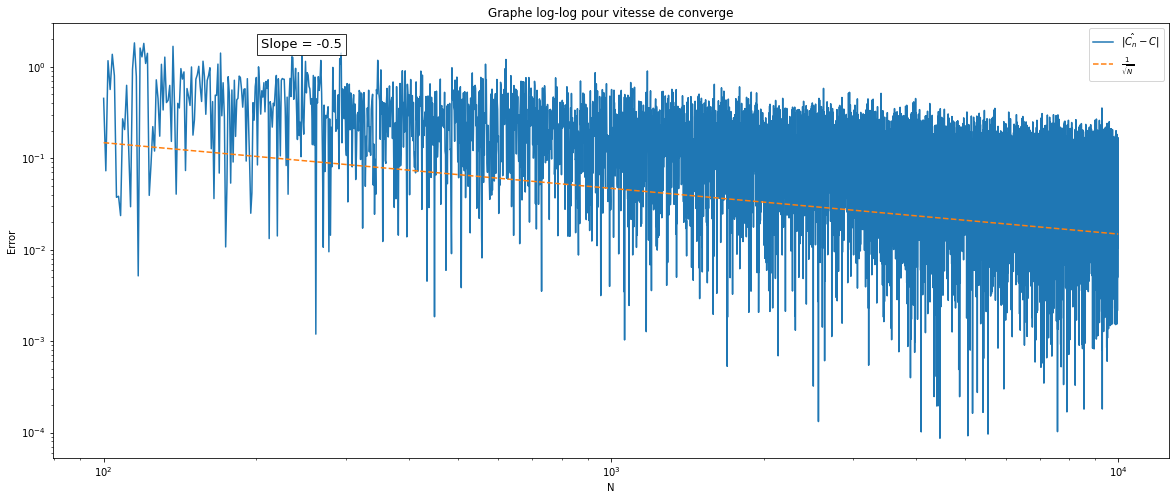

In [ ]:
N = 10000
mcconv = list()
for i in tqdm(range(100,N+1)): 
    mc = MonteCarloBS_European(N=i)
    mcconv.append(mc.res) # Définition de notre liste pour chaque N
# On calcule l'erreur d'estimation
x = np.abs(mcconv - Call().price())
# on calcule notre intercepte et le coefficient de pente
slope, intercept = np.polyfit(np.log(np.linspace(100,mc.N,mc.N-99)),np.log(x), 1)
# On affiche le graphe log-log
plt.subplots(1,1,figsize=(20,8))
plt.loglog(np.linspace(100,mc.N,mc.N-99), x, label=r"$|\hat{C_{n}} - C|$")
plt.loglog(np.linspace(100,mc.N,mc.N-99), intercept*np.linspace(100,mc.N,mc.N-99)**(slope), "--", label=r"$\frac{1}{\sqrt{N}}$")
plt.legend()
plt.xlabel("N")
plt.ylabel("Error")
plt.title("Graphe log-log pour vitesse de converge")
plt.annotate(f"Slope = {round(np.average(slope),3)}", xy=(0.2, 1), xytext=(-15, -15), fontsize=13,xycoords='axes fraction', textcoords='offset points', bbox=dict(facecolor='white', alpha=0.8), horizontalalignment='left', verticalalignment='top')

## Panier d'actifs (exemple avec 4 actifs)

In [ ]:
# On simule notre matrice de corrélation
rho = np.array([1,0.821,-0.285,-0.06,0,1,-0.344,-0.017,0,0,1,0.589,0,0,0,1]).reshape((4,4))
rho += rho.T - np.eye(4)*np.diag(rho)

In [ ]:
# Résultats dans le cas du call
maxcall = MonteCarloBS_Basket(10000, eval="max", So=[100,100,100,100], sigma=[0.25,0.25,0.25,0.25], rho=rho).res
mincall = MonteCarloBS_Basket(10000, eval="min", So=[100,100,100,100], sigma=[0.25,0.25,0.25,0.25], rho=rho).res
moycall = MonteCarloBS_Basket(10000, eval="mean", So=[100,100,100,100], sigma=[0.25,0.25,0.25,0.25], rho=rho).res
print(f"Voici le prix d'un call pour le max de nos 4 actifs : {maxprice}")
print(f"Voici le prix d'un call pour le min de nos 4 actifs : {minprice}")
print(f"Voici le prix d'un call pour la moyenne de nos 4 actifs : {moyprice}")
print(f"Le prix d'un call normal pour les mêmes paramètres : {Call(T=1).price()}")

Voici le prix d'un call pour le max de nos 4 actifs : 29.024580010571356
Voici le prix d'un call pour le min de nos 4 actifs : 1.1713281402629407
Voici le prix d'un call pour la moyenne de nos 4 actifs : 8.304396465070997
Le prix d'un call normal pour les mêmes paramètres : 12.335998930368717


In [ ]:
# Résultats dans le cas du put
maxput = MonteCarloBS_Basket(10000, eval="max", So=[100,100,100,100], sigma=[0.25,0.25,0.25,0.25], rho=rho, call=False, put=True).res
minput = MonteCarloBS_Basket(10000, eval="min", So=[100,100,100,100], sigma=[0.25,0.25,0.25,0.25], rho=rho, call=False, put=True).res
moyput = MonteCarloBS_Basket(10000, eval="mean", So=[100,100,100,100], sigma=[0.25,0.25,0.25,0.25], rho=rho, call=False, put=True).res
print(f"Voici le prix d'un put pour le max de nos 4 actifs : {maxput}")
print(f"Voici le prix d'un put pour le min de nos 4 actifs : {minput}")
print(f"Voici le prix d'un put pour la moyenne de nos 4 actifs : {moyput}")
print(f"Le prix d'un put normal pour les mêmes paramètres : {Put(T=1).price()}")

Voici le prix d'un put pour le max de nos 4 actifs : 0.6381349382194996
Voici le prix d'un put pour le min de nos 4 actifs : 17.39212072489559
Voici le prix d'un put pour la moyenne de nos 4 actifs : 3.6096018133311722
Le prix d'un put normal pour les mêmes paramètres : 7.458941380440123


# <center> QUESTION 2</center>

# Exemple d'instanciation

In [ ]:
MonteCarloBS_Asian(dates=[1,0.2546, "05/06/2021 10:30:30",0.2], T = "18/01/2022", nb_sim_path=1000000, display_text=True);

--------------- MonteCarloBS_Asian(Call) ---------------
Nombre de simulations de trajectoires : 1000000. Aucune réduction de variance.
Pour les dates d'observations : ['01/04/2021', '20/04/2021', '05/06/2021', '18/01/2022']. Maturité: 18/01/2022
Ecart-type h(X): 9.306
Estimation : 6.464194821685318
Intervalle de confiance (95%) : [6.446,6.482]




## Comparaison call asiatique (une date disrète à $T$) et européen pour $T=90d$

In [ ]:
T = 90/365
test = MonteCarloBS_Asian(dates=[pd.to_datetime("today").normalize() + pd.DateOffset(days=T*365)], T=T, nb_sim_path=1000000, display_text=True)
# Call() avec meme paramètres donne 5.55586

--------------- MonteCarloBS_Asiatic(Call) ---------------
Nombre de simulations de trajectoires : 1000000. Aucune réduction de variance.
Pour les dates d'observations : ['04/04/2021']. Maturité: 04/04/2021
Ecart-type h(X): 8.209
Estimation : 5.552380023796031
Intervalle de confiance (95%) : [5.536,5.568]




## Simulation de 1000 trajectoires depuis $S_0 = 100$ d'aujourd'hui au 19-04-2021

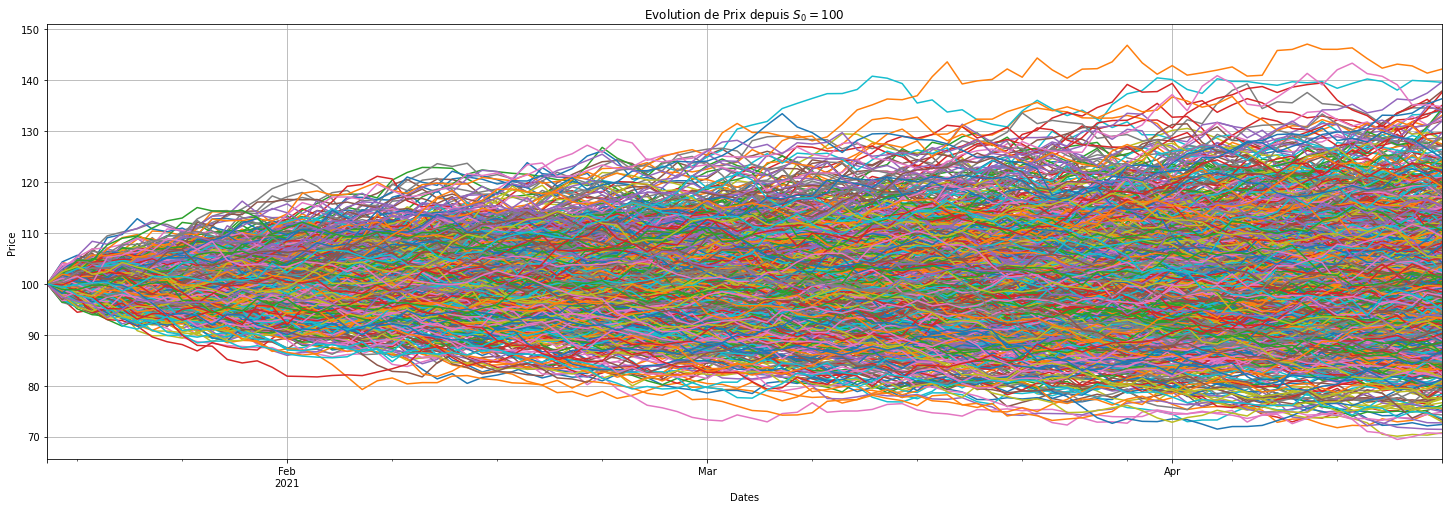

In [ ]:
T = "19/04/2021"
ex_sim_path = MonteCarloBS_Asian(dates=pd.date_range(pd.to_datetime("today"), T), T=T, nb_sim_path=1000).Spath
ex_sim_path.plot(figsize=(25,8), grid=True, legend=False, xlabel="Dates", ylabel="Price", title=r"Evolution de Prix depuis $S_0=100$");

In [ ]:
ex_sim_path

sim_1       sim_2  ...     sim_999    sim_1000
2021-01-16  100.000000  100.000000  ...  100.000000  100.000000
2021-01-17  101.483197  100.846412  ...  102.389486   99.334742
2021-01-18  103.850796  102.979805  ...  103.432808   99.861902
2021-01-19  101.954133  103.396664  ...  101.906710  100.207836
2021-01-20  101.050443  103.625011  ...  102.375144  100.273530
...                ...         ...  ...         ...         ...
2021-04-15  100.719890  107.913737  ...  111.229506   97.338312
2021-04-16  101.237163  109.728004  ...  110.403633   98.822537
2021-04-17  101.172492  110.234746  ...  107.419485   98.023435
2021-04-18  101.321392  109.896824  ...  105.437722   96.869091
2021-04-19   99.962833  111.702486  ...  105.091611   94.900595

[94 rows x 1000 columns]

## Evolution du prix de l'option call asiatique pour $S_0 \in [0,200]$, $T=90/365$ avec $5$ dates discrètes et $10000$ simulations de trajectoires et avec call européen en comparaison

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log


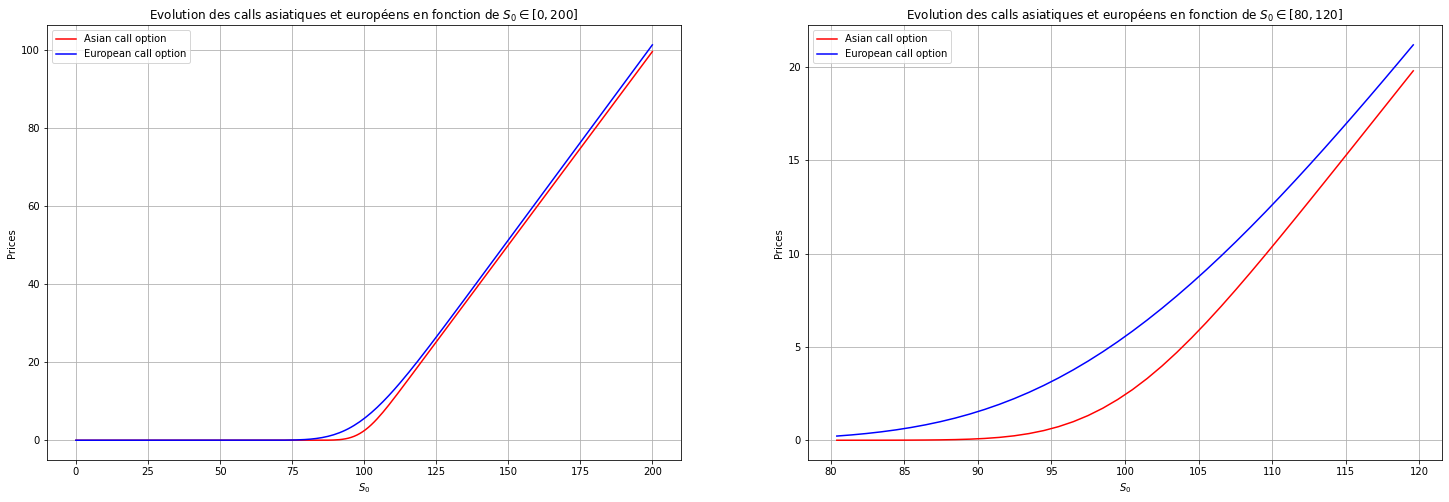

In [ ]:
prices = np.linspace(0,200,200)
asiatcalls = []
eurocalls = []
for price in tqdm(prices):                   # On utilise des dates pandas ici                                                              # fix_seed=True pour avoir les mêmes 10000 trajectoires
  asiatcalls.append(MonteCarloBS_Asian(dates=pd.date_range(pd.to_datetime("today").normalize(), periods=5, freq="10B"), So=price, T=90/365, nb_sim_path=10000, fix_seed=True).res)
  eurocalls.append(Call(St=price).price());

fig, ax = plt.subplots(1,2,figsize=(25,8))
ax[0].plot(prices, asiatcalls, label="Asian call", color="red")
ax[0].plot(prices, eurocalls, label="European call", color="blue")
ax[0].set(xlabel=r"$S_0$", ylabel="Prices", title=r"Evolution des calls asiatiques et européens en fonction de $S_0 \in [0,200]$")
ax[0].grid();ax[1].grid()
ax[0].legend()
ax[1].plot(prices[80:120], asiatcalls[80:120], label="Asian call", color="red")
ax[1].plot(prices[80:120], eurocalls[80:120], label="European call", color="blue")
ax[1].set(xlabel=r"$S_0$", ylabel="Prices", title=r"Evolution des calls asiatiques et européens en fonction de $S_0 \in [80,120]$")
ax[1].legend()

## Evolution du prix de l'option asiatique pour $Nb_{dates} \in [1,100]$ avec 10000 simulations de trajectoires

### En partant de $T$ (décroissant)

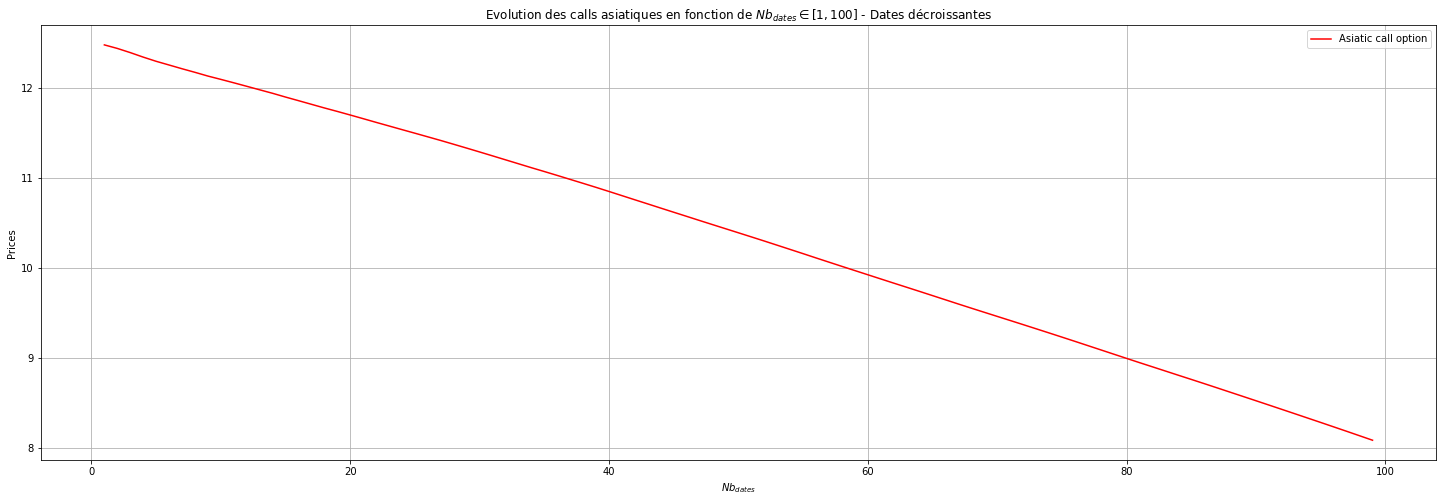

In [ ]:
asiatcalls = []
T = pd.to_datetime("today").normalize() + pd.DateOffset(months=12) # Maturité T=1

for i in tqdm(range(1,100)): 
  dates = pd.date_range(start=T, periods=i, freq="-3D")     # all_days=True pour simuler toutes les dates entre 0 et T -> estimations basées sur les mêmes trajectoires
  asiatcalls.append(MonteCarloBS_Asian(dates=dates, nb_sim_path=10000, all_days=True, fix_seed=True).res)

fig, ax = plt.subplots(figsize=(25,8))
ax.plot(range(1,100), asiatcalls, label="Asian call", color="red");
ax.set(xlabel=r"$Nb_{dates}$", ylabel="Prices", title=r"Evolution des calls asiatiques en fonction de $Nb_{dates} \in [1,100]$ - Dates décroissantes")
ax.grid()
ax.legend()

### En partant de $t_0 + 1$ ($S_0$) pas compris dans la moyenne

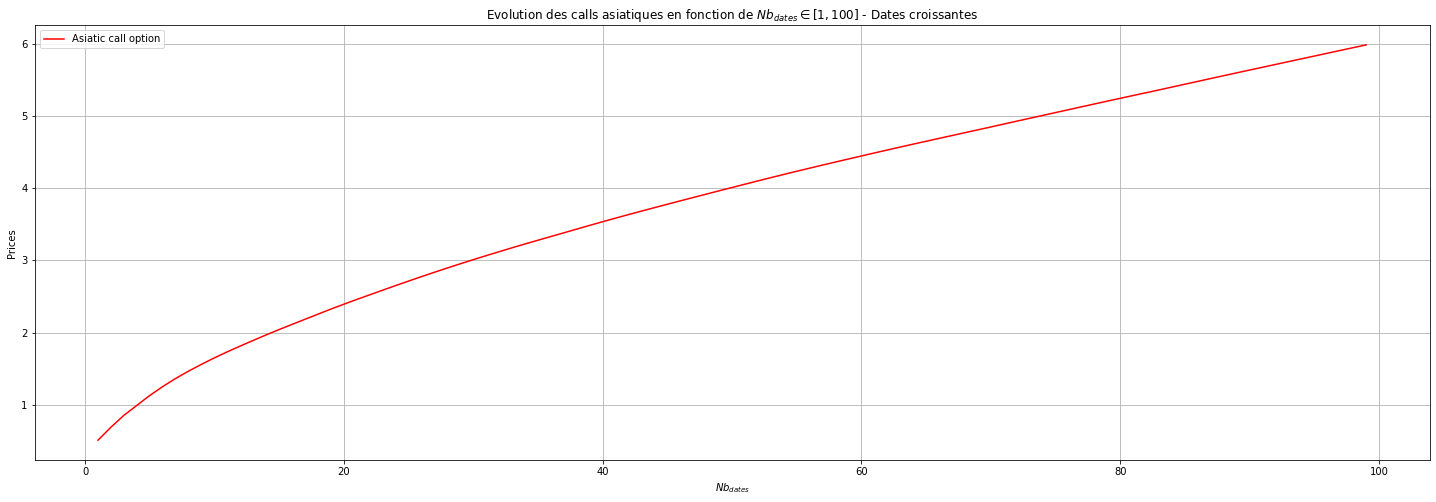

In [ ]:
asiatcalls = []
tomorrow = pd.to_datetime("today").normalize() + pd.DateOffset(days=1)

for i in tqdm(range(1,100)): 
  dates = pd.date_range(start=tomorrow, periods=i, freq="3D")
  asiatcalls.append(MonteCarloBS_Asian(dates=dates, nb_sim_path=10000, all_days=True, fix_seed=True).res)

fig, ax = plt.subplots(figsize=(25,8))
ax.plot(range(1,100), asiatcalls, label="Asian call", color="red");
ax.set(xlabel=r"$Nb_{dates}$", ylabel="Prices", title=r"Evolution des calls asiatiques en fonction de $Nb_{dates} \in [1,100]$ - Dates croissantes")
ax.grid()
ax.legend()

## Convergence du prix de l'option asiatique en fonction du nombres de trajectoires simulées, avec une date discrète à $T$ (comparaison avec call vanille)

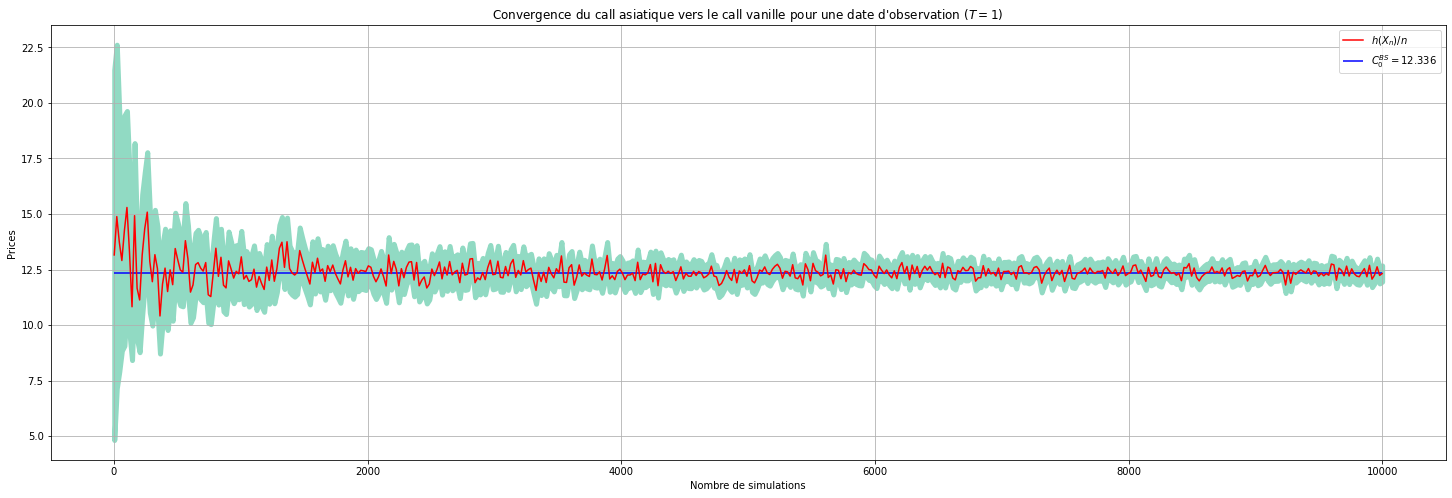

In [ ]:
nb_sim = np.linspace(2, 10000, 500)
asiatcalls = []
conv_lower = []
conv_upper = []
T = pd.to_datetime("today").normalize() + pd.DateOffset(months=12) # Maturité T=1
alpha = 0.05
for nbsim in tqdm(nb_sim):
  mc_A = MonteCarloBS_Asian(dates=[T], nb_sim_path=int(nbsim), T=T)
  asiatcalls.append(mc_A.res)
  conv_lower.append(mc_A.IC(mc_1.h_x, mc_A.res)[0])
  conv_upper.append(mc_A.IC(mc_1.h_x, mc_A.res)[1])

fig, ax = plt.subplots(figsize=(25,8))
ax.set(xlabel="Nombre de simulations", ylabel="Prices", title=r"Convergence du call asiatique vers le call vanille pour une date d'observation ($T=1$)")
ax.plot(nb_sim, asiatcalls, label="Asian call", color="red")
ax.fill_between(nb_sim, conv_lower, conv_upper, color='#91DAC3', linewidth=5) # Intervalles de confiance
# on affiche le prix du call avec formule fermée correspondant
ax.hlines(Call(T=1).price(), 0, 10000, colors="blue", label=r"$C_{0}^{BS} = 12.336$")
ax.grid()
ax.legend()

## Réduction de variance pour call asiatique

### Variable antithétiques

In [ ]:
MonteCarloBS_Asian(dates=[0.2, 0.5, 1], nb_sim_path=1000000, display_text=True, var_antithetic=True);

--------------- MonteCarloBS_Asian(Call) ---------------
Nombre de simulations de trajectoires : 1000000. Réduction de variance par variables antithétiques.
Pour les dates d'observations : ['03/04/2021', '21/07/2021', '20/01/2022']. Maturité: 20/01/2022
Avec variale anthithétiques, 500000 simulations.
Ecart-type m1(X) : 10.899610568178469
Ecart-type m2(X) : 10.89096494660565
Cov(m1,m2) = -56.093807927981395
Ecart-type h(X): 5.595
Estimation : 7.49776172165207
Intervalle de confiance (95%) : [7.487,7.509]


Cas sans réduction : (avec 1000000 simulations):
Ecart-type h(X): 10.894
Estimation : 7.4996235001949545
Intervalle de confiance (95%) : [7.478,7.521]




In [ ]:
# On calcule le prix et les IC pour MC classique et avec var antithétiques
prices = []
prices_anth = []
conv_lower = []; conv_upper = []
conv_lower_anth = []; conv_upper_anth = []
dates=[0.2, 0.5, 1]
nb_sim = np.linspace(100, 100000, 100)
T = 1
alpha = 0.05
for nbsim in tqdm(nb_sim):
  mc_A = MonteCarloBS_Asian(dates=dates, nb_sim_path=int(nbsim), T=T)
  mc_A_anth = MonteCarloBS_Asian(dates=dates, nb_sim_path=int(nbsim), T=T, var_antithetic=True)
  prices.append(mc_A.res)
  prices_anth.append(mc_A_anth.res_m1m2)
  # Intervalles de confiance MC classique
  conv_lower.append(mc_A.IC(alpha, mc_A.h_x, mc_A.res)[0])
  conv_upper.append(mc_A.IC(alpha, mc_A.h_x, mc_A.res)[1])
  # Intervalles de confiance MC var antithétiques
  conv_lower_anth.append(mc_A_anth.IC(alpha, mc_A_anth.h_x_m1m2, mc_A_anth.res_m1m2)[0])
  conv_upper_anth.append(mc_A_anth.IC(alpha, mc_A_anth.h_x_m1m2, mc_A_anth.res_m1m2)[1])

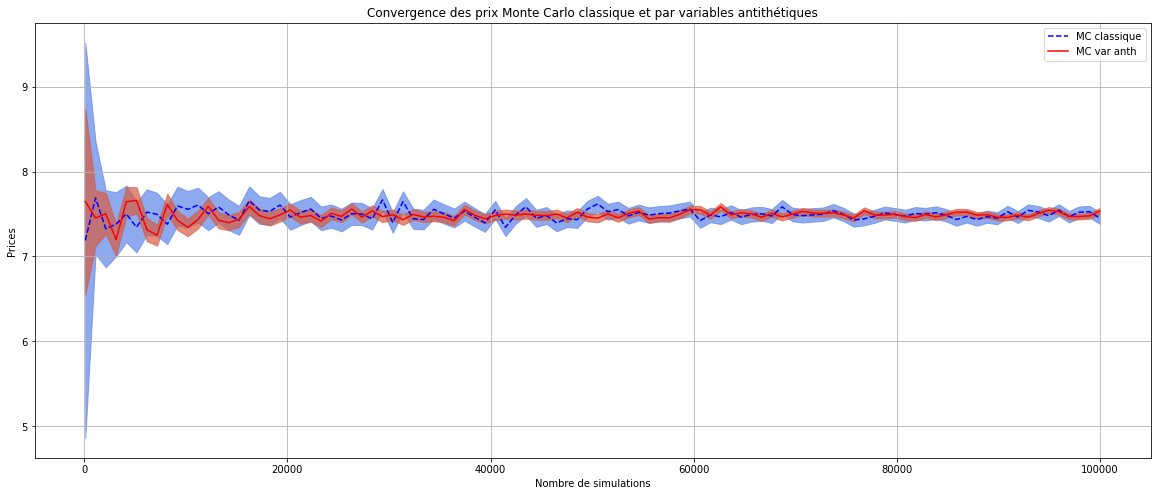

In [ ]:
# On affiche le graphique correspondant
fig, ax = plt.subplots(figsize=(20,8))
ax.set(xlabel="Nombre de simulations", ylabel="Prices", title=r"Convergence des prix Monte Carlo classique et par variables antithétiques")
ax.plot(nb_sim, prices, label="MC classique", color="blue", linestyle="--")
ax.plot(nb_sim, prices_anth, label="MC var anth", color="red")
ax.fill_between(nb_sim, conv_lower, conv_upper, color='#5f86e8', linewidth=1, alpha=0.7)
ax.fill_between(nb_sim, conv_lower_anth, conv_upper_anth, color='#d65b42', linewidth=1, alpha=0.7)
ax.grid()
ax.legend()

### Variable de controles avec $Z_1 = S_T$ et $Z_2 = \frac{1}{N} \sum_{i=1}^{N}S_{t_i}$ et $Z_3 = e^{-rT}(S_T - K)_{+}$ 

#### Avec $\mathbb{E}[Z_1]$, $\mathbb{E}[Z_2]$, $\mathbb{E}[Z_3]$ non connues

In [ ]:
MonteCarloBS_Asian(dates=[0.2, 0.5, 1], nb_sim_path=1000000, display_text=True, fix_seed=True, var_control=True);

--------------- MonteCarloBS_Asian(Call) ---------------
Nombre de simulations de trajectoires : 1000000. Réduction de variance par variables de controles.
Pour les dates d'observations : ['03/04/2021', '21/07/2021', '20/01/2022']. Maturité: 20/01/2022
Pour Z1 : S_T:
E[Z1] = 105.17848262868586
Cov(h_x,Z1) = 247.7812756166112
c1 = -0.34633323600632754
Ecart-type h(X): 5.757
Estimation : 7.5097948107616945
Intervalle de confiance (95%) : [7.499,7.521]


Pour Z2 : 1/N(sum St_i):
E[Z2] = 102.90858312743356
Cov(h_x,Z2) = 162.49940321128489
c2 = -0.6107440127702036
Ecart-type h(X): 4.44
Estimation : 7.509794810761693
Intervalle de confiance (95%) : [7.501,7.518]


Pour Z3 : exp(-rT)(S_T - K)+):
E[Z3] = 12.372247798038671
Cov(h_x,Z3) = 181.47885303022326
c3 = -0.526617862936018
Ecart-type h(X): 4.836
Estimation : 7.509794810761694
Intervalle de confiance (95%) : [7.5,7.519]


Cas sans réduction : 
Ecart-type h(X): 10.907
Estimation : 7.509794810761691
Intervalle de confiance (95%) : [7.488,7.

#### Avec $\mathbb{E}[Z_1] = S_{0}e^{rT}$, $\mathbb{E}[Z_2] = \frac{1}{N} \sum_{i=1}^{N}S_{0}e^{rt_i}$ et $\mathbb{E}[Z_1] = C_{0}^{BS}$



In [ ]:
MonteCarloBS_Asian(dates=[0.2, 0.5, 1], nb_sim_path=1000000, display_text=True, fix_seed=True, var_control=True, known_Zesp=True);

--------------- MonteCarloBS_Asian(Call) ---------------
Nombre de simulations de trajectoires : 1000000. Réduction de variance par variables de controles.
Pour les dates d'observations : ['03/04/2021', '21/07/2021', '20/01/2022']. Maturité: 20/01/2022
Avec E[Z_1], E[Z_2] et E[Z_3] connues.
Pour Z1 : S_T:
E[Z1] = 105.12710963760242
Cov(h_x,Z1) = 247.7812756166112
c1 = -0.34633323600632754
Ecart-type h(X): 5.757
Estimation : 7.4920026365164425
Intervalle de confiance (95%) : [7.481,7.503]


Pour Z2 : 1/N(sum St_i):
E[Z2] = 102.88787946615405
Cov(h_x,Z2) = 162.49940321128489
c2 = -0.6107440127702036
Ecart-type h(X): 4.44
Estimation : 7.49715017359281
Intervalle de confiance (95%) : [7.488,7.506]


Pour Z3 : exp(-rT)(S_T - K)+):
E[Z3] = 12.335998930368717
Cov(h_x,Z3) = 181.47885303022326
c3 = -0.526617862936018
Ecart-type h(X): 4.836
Estimation : 7.490705509535494
Intervalle de confiance (95%) : [7.481,7.5]


Cas sans réduction : 
Ecart-type h(X): 10.907
Estimation : 7.509794810761691
Int

# <center> Options à barrières </center>

In [ ]:
MonteCarloBS_UpAndOut(dates=pd.date_range(start=pd.to_datetime("today").normalize(), periods=10, freq="D"), So=120, M=120, T=90/365, nb_sim_path=1000, display_text=True)

--------------- MonteCarloBS_UpAndOut(Call) ---------------
Nombre de simulations de trajectoires : 1000. Aucune réduction de variance.
Pour les dates d'observations : ['22/01/2021', '23/01/2021', '24/01/2021', '25/01/2021', '26/01/2021', '27/01/2021', '28/01/2021', '29/01/2021', '30/01/2021']. Maturité: 21/04/2021
Ecart-type h(X): 8.352
Estimation : 2.950997877844187
Intervalle de confiance (95%) : [2.433,3.469]




## Evolution du prix des options Up&Out ($10$ dates) et Down&In ($90$ dates) pour $S_0 \in [0,200]$, $T=90/365$ et $1000$ simulations de trajectoires et avec call européen en comparaison

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log


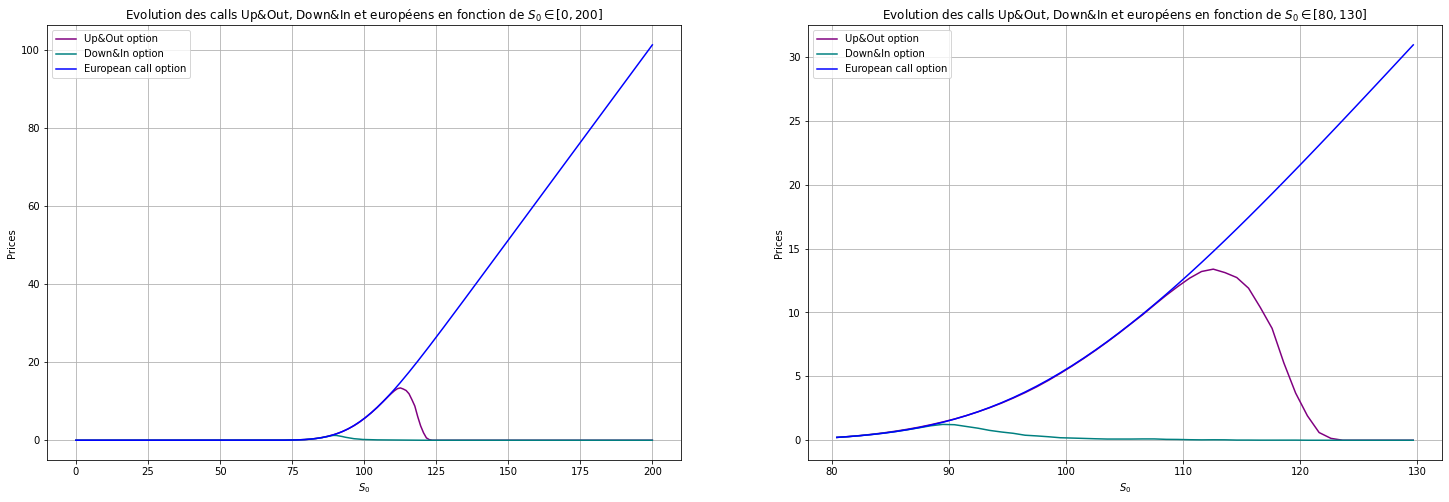

In [ ]:
# Pareil que pour l'option asiatique
prices = np.linspace(0,200,200)
upoutcalls = []
downincalls = []
eurocalls = []
for price in tqdm(prices):
  upoutcalls.append(MonteCarloBS_UpAndOut(dates=pd.date_range(start=pd.to_datetime("today").normalize(), periods=10, freq="D"), So=price, M=120, T=90/365, nb_sim_path=1000, fix_seed=True).res)
  downincalls.append(MonteCarloBS_DownAndIn(dates=pd.date_range(start=pd.to_datetime("today").normalize(), periods=90, freq="D"), So=price, B=90, T=90/365, nb_sim_path=1000, fix_seed=True).res)
  eurocalls.append(Call(St=price).price())

fig, ax = plt.subplots(1,2,figsize=(25,8))
ax[0].plot(prices, upoutcalls, label=r"Up&Out call", color="purple")
ax[0].plot(prices, downincalls, label=r"Down&In call", color="teal")
ax[0].plot(prices, eurocalls, label="European call", color="blue")
ax[0].set(xlabel=r"$S_0$", ylabel="Prices", title=r"Evolution des calls Up&Out, Down&In et européens en fonction de $S_0 \in [0,200]$")
ax[0].grid();ax[1].grid()
ax[0].legend()
ax[1].plot(prices[80:130], upoutcalls[80:130], label=r"Up&Out call", color="purple")
ax[1].plot(prices[80:130], downincalls[80:130], label=r"Down&In call", color="teal")
ax[1].plot(prices[80:130], eurocalls[80:130], label="European call", color="blue")
ax[1].set(xlabel=r"$S_0$", ylabel="Prices", title=r"Evolution des calls Up&Out, Down&In et européens en fonction de $S_0 \in [80,130]$")
ax[1].legend()

## Evolution du prix de l'option barrière pour $Nb_{dates} \in [1,100]$ et $10000$ simulations de trajectoires

### En partant de $T$ (décroissant)

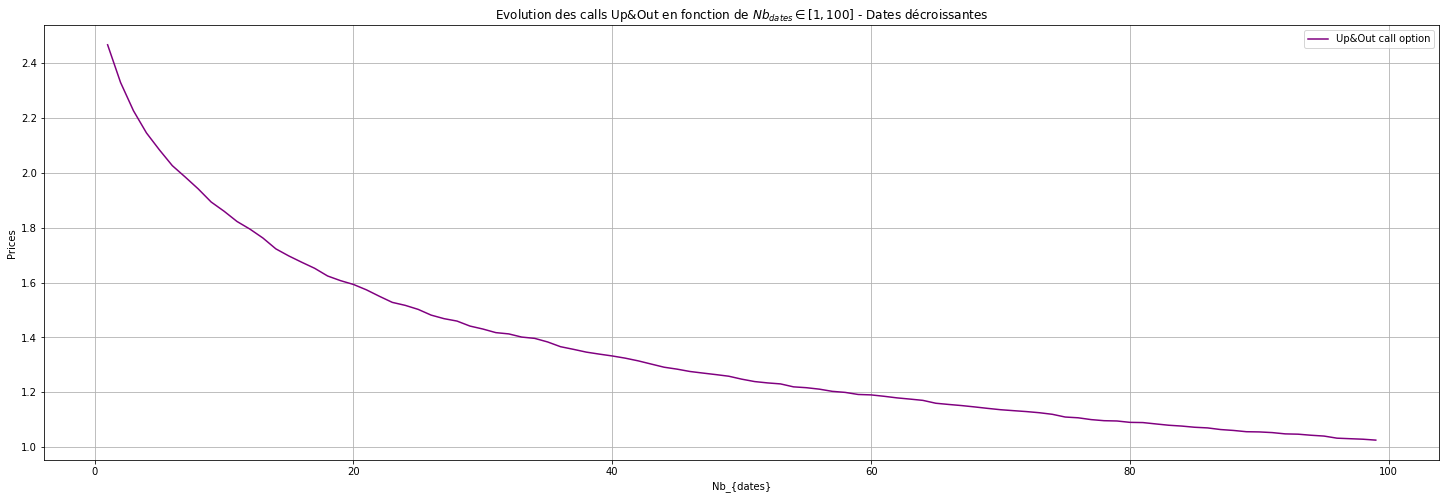

In [ ]:
# Pareil que pour le cas asiatique
T = pd.to_datetime("today").normalize() + pd.DateOffset(months=12) # Maturité T=1
upoutcalls = []

for i in tqdm(range(1,100)):
  dates = pd.date_range(start=T, periods=i, freq="-2D")
  upoutcalls.append(MonteCarloBS_UpAndOut(dates=dates, M=120, nb_sim_path=10000, all_days=True, fix_seed=True).res)

fig, ax = plt.subplots(figsize=(25,8))
ax.set(xlabel=r"$Nb_{dates}$", ylabel="Prices", title="Evolution des calls Up&Out en fonction de $Nb_{dates} \in [1,100]$ - Dates décroissantes")
ax.plot(range(1,100), upoutcalls, label=r"Up&Out call", color="purple")
ax.grid()
ax.legend()

# En partant de $t_0 + 1$ ($S_0$) pas compris dans la moyenne

In [ ]:
# Pareil qu'avec l'option asiatique
tomorrow = pd.to_datetime("today").normalize() + pd.DateOffset(days=1)
upoutcalls = []

for i in tqdm(range(1,100)):
  dates = pd.date_range(start=tomorrow, periods=i, freq="2D")
  upoutcalls.append(MonteCarloBS_UpAndOut(dates=dates, M=120, nb_sim_path=10000, all_days=True, fix_seed=True).res)

fig, ax = plt.subplots(figsize=(25,8))
ax.set(xlabel=r"$Nb_{dates}$", ylabel="Prices", title="Evolution des calls Up&Out en fonction de $Nb_{dates} \in [1,100]$ - Dates croissantes")
ax.plot(range(1,100), upoutcalls, label="Up&Out call", color="purple")
ax.grid()
ax.legend()

# Plot pour $\sigma \in [0.05,1]$

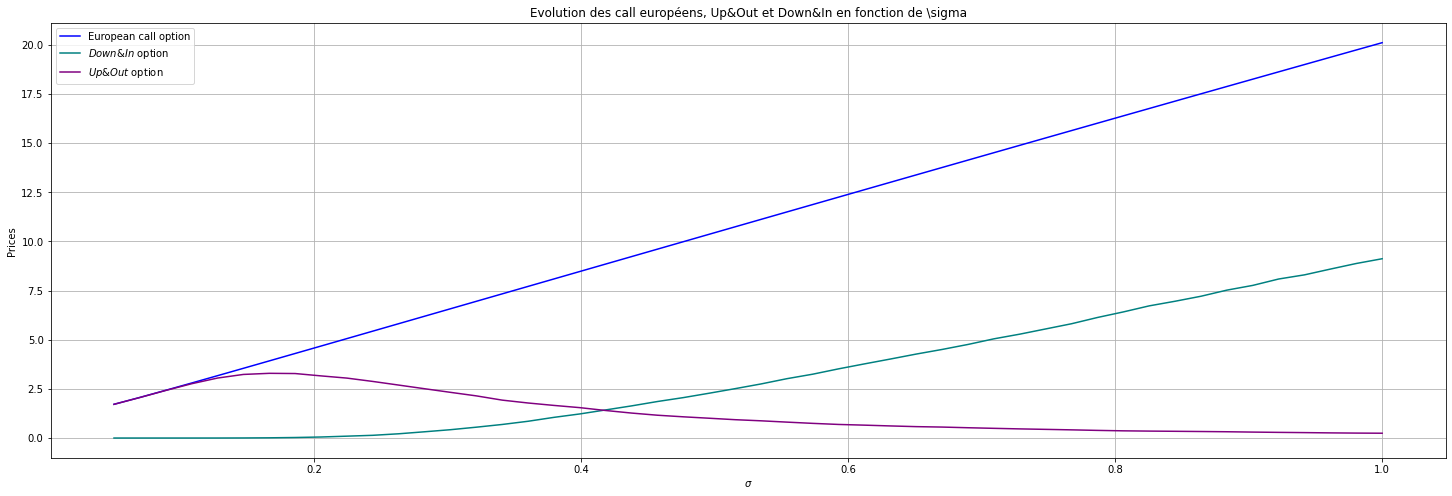

In [ ]:
# on affcihe pour les dates d'observations sur toute la période, en augmentant la volatilité
vols = np.linspace(0.05,1,50)
updowncalls = []
downincalls = []
eurocalls = []
for vol in tqdm(vols):
  updowncalls.append(MonteCarloBS_UpAndOut(dates=pd.date_range(start=pd.to_datetime("today").normalize(), periods=30, freq="D"), sigma=vol, M=120, T=90/365, nb_sim_path=10000, fix_seed=True).res)
  downincalls.append(MonteCarloBS_DownAndIn(dates=pd.date_range(start=pd.to_datetime("today").normalize(), periods=90, freq="D"), sigma=vol, B=90, T=90/365, nb_sim_path=10000, fix_seed=True).res)
  eurocalls.append(Call(sigma=vol).price())

fig, ax = plt.subplots(figsize=(25,8))
ax.set(xlabel=r"$\sigma$", ylabel="Prices", title=r"Evolution des call européens, Up&Out et Down&In en fonction de $\sigma$")
ax.plot(vols, eurocalls, label="European call", color="blue")
ax.plot(vols, downincalls, label="$Down&In$ call", color="teal")
ax.plot(vols, updowncalls, label="$Up&Out$ call", color="purple");
ax.grid()
ax.legend()

## Surveillance continue de la barrière

In [ ]:
def upout_continous_barrier(nb_sim_path, So, K, M, T, r, sigma):
  # On simule nos XT
  XT = (r/sigma - 0.5*sigma)*T + np.sqrt(T)*np.random.normal(0,1,size=nb_sim_path)
  # On en déduit les ST correspondants
  ST = So*np.exp(sigma*XT)
  # On calcule notre payoff pour chaque ST < M, ST > K, et MTs < M
  h_x_cont = np.zeros(ST.shape[0])
  for i in range(ST.shape[0]):
    if ST[i] > K and ST[i] < M:
      # Calcul du sup de X
      Xsup = (XT[i] + np.sqrt(XT[i]**2 - 2*T*np.log(np.random.uniform(0,1))))/2 
      Ssup = So*np.exp(sigma*Xsup)
      if Ssup < M:
        h_x_cont[i] = ST[i] - K
  # On en déduit le résultat de notre estimation
  return np.exp(-r*T)*np.average(h_x_cont)

In [ ]:
outputcalls = []
conv_lower = []
conv_upper = []
T = 1
alpha = 0.05
for i in tqdm(np.logspace(1,4,100)):
  dates = np.linspace(0,1,int(i))
  mc_uo = MonteCarloBS_UpAndOut(dates=dates, nb_sim_path=10000, T=T, fix_seed=True, kind_pandas=False)
  outputcalls.append(mc_uo.res)
  # Intervalles de confiance - auraient aussi pu être calculés avec la méthode IC de la classe
  conv_lower.append(outputcalls[-1] - (stats.norm.ppf(1-(alpha/2), loc=0, scale=1) * np.sqrt(mc_uo.var_est(mc_uo.h_x)/mc_uo.N)))
  conv_upper.append(outputcalls[-1] + (stats.norm.ppf(1-(alpha/2), loc=0, scale=1) * np.sqrt(mc_uo.var_est(mc_uo.h_x)/mc_uo.N)))

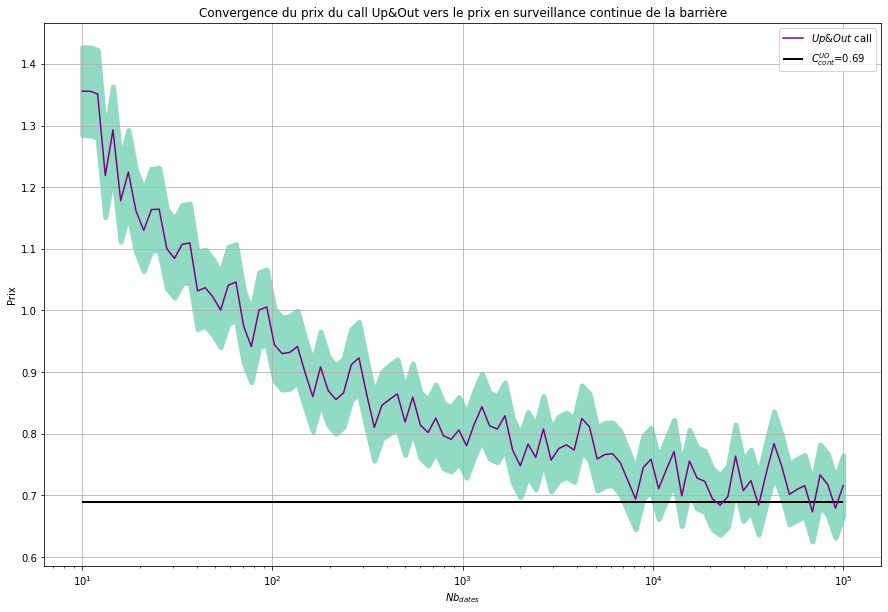

In [ ]:
# On calcule le prix de notre barrière continue
price_cont = upout_continous_barrier(nb_sim_path=1000000, So=100, K=100, M=120, T=1, r=0.05, sigma=0.25)
# On affiche le graphique représentant la convergence
fig, ax = plt.subplots(figsize=(15,10))
ax.grid()
ax.set(title="Convergence du prix du call Up&Out vers le prix en surveillance continue de la barrière", xlabel="$Nb_{dates}$", ylabel="Prix", xscale="log")
ax.hlines(price_cont, np.logspace(1,5,100)[0], np.logspace(1,5,100)[-1], label="$C^{UO}_{cont}$="+f"{np.round(price_cont,3)}", linewidth=2);
ax.fill_between(np.logspace(1,5,100), conv_lower, conv_upper, color='#91DAC3', linewidth=5) # Intervalles de confiance
ax.plot(np.logspace(1,5,100), outputcalls, color="purple", label="$Up&Out$ call")
ax.legend()

## Réduction de variance par Monte Carlo Conditionnel - Option Down&in

### Première comparaison

In [ ]:
# MC classique
T=1
MonteCarloBS_DownAndIn(nb_sim_path=1000000, dates=np.linspace(0,T,10), T=T, display_text=True);

--------------- MonteCarloBS_DownAndIn(Call) ---------------
Nombre de simulations de trajectoires : 1000000. Aucune réduction de variance.
Pour les dates d'observations : ['01/03/2021', '11/04/2021', '21/05/2021', '01/07/2021', '10/08/2021', '20/09/2021', '30/10/2021', '10/12/2021', '20/01/2022']. Maturité: 20/01/2022
Ecart-type h(X): 5.94
Estimation : 1.496275171480172
Intervalle de confiance (95%) : [1.485,1.508]




In [ ]:
# MC conditionnel
MonteCarloBS_DownAndIn(nb_sim_path=1000000, dates=np.linspace(0,T,10), T=T, display_text=True, mc_cond=True);

--------------- MonteCarloBS_DownAndIn(Call) ---------------
Nombre de simulations de trajectoires : 1000000. Réduction de variance par Monte Carlo conditionnel.
Pour les dates d'observations : ['01/03/2021', '11/04/2021', '21/05/2021', '01/07/2021', '10/08/2021', '20/09/2021', '30/10/2021', '10/12/2021', '20/01/2022']. Maturité: 20/01/2022
Ecart-type h(X): 1.905
Estimation : 1.4961063438122075
Intervalle de confiance (95%) : [1.492,1.5]




### Convergence

In [ ]:
prices = []
prices_cond = []
conv_lower = []; conv_upper = []
conv_lower_cond = []; conv_upper_cond = []
nb_sim = np.linspace(100, 100000, 100) # 100 simulations entre 100 et 100000
T = 1
alpha = 0.05
for nbsim in tqdm(nb_sim):
  mc_DI = MonteCarloBS_DownAndIn(dates=np.linspace(0,T,10), nb_sim_path=int(nbsim), T=T)
  mc_DI_cond = MonteCarloBS_DownAndIn(dates=np.linspace(0,T,10), nb_sim_path=int(nbsim), T=T, mc_cond=True)
  prices.append(mc_DI.res)
  prices_cond.append(mc_DI_cond.res)
  # Intervalles de confiance pour MC classique
  conv_lower.append(mc_DI.IC(alpha, mc_DI.h_x, mc_DI.res)[0])
  conv_upper.append(mc_DI.IC(alpha, mc_DI.h_x, mc_DI.res)[1])
  # Intervalles de confiance pour MC conditionnel
  conv_lower_cond.append(mc_DI_cond.IC(alpha, mc_DI_cond.h_x, mc_DI_cond.res)[0])
  conv_upper_cond.append(mc_DI_cond.IC(alpha, mc_DI_cond.h_x, mc_DI_cond.res)[1])

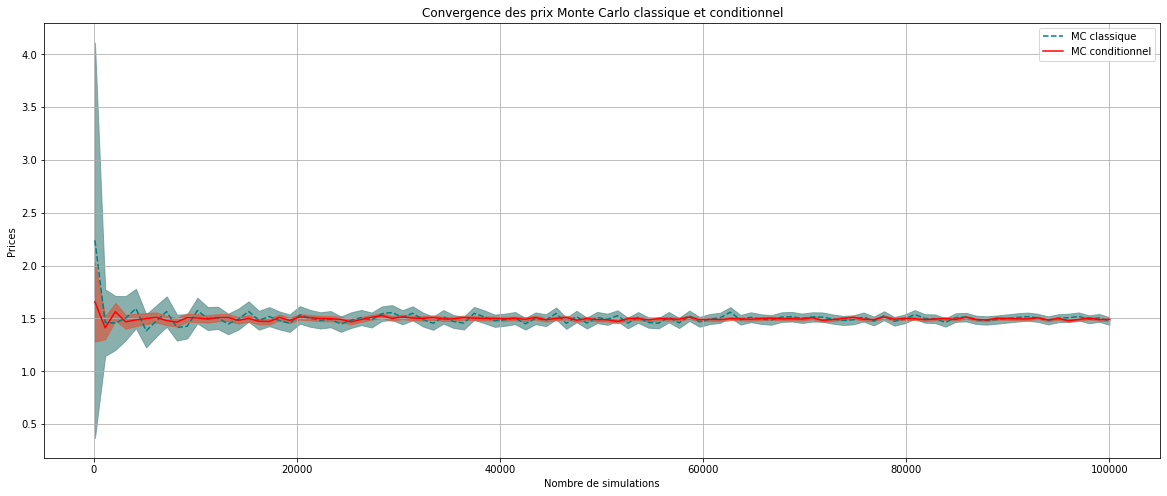

In [ ]:
# On affiche notre graphique de convergence avec les deux méthodes
fig, ax = plt.subplots(figsize=(20,8))
ax.set(xlabel="Nombre de simulations", ylabel="Prices", title=r"Convergence des prix Monte Carlo classique et conditionnel")
ax.plot(nb_sim, prices, label="MC classique", color="teal", linestyle="--")
ax.plot(nb_sim, prices_cond, label="MC conditionnel", color="red")
ax.fill_between(nb_sim, conv_lower, conv_upper, color='#598f8c', linewidth=1, alpha=0.7)
ax.fill_between(nb_sim, conv_lower_cond, conv_upper_cond, color='#d65b42', linewidth=1, alpha=0.7)
ax.grid()
ax.legend()

# <center> EDP </center>

# Classes 

In [ ]:
class BS_PDE_FinitDiff(BS):
     
    def __init__(self, St, K, T,t, sigma,r,a,op_type,Ndt,Nx):
        super().__init__(St, K, T, t, sigma, r, a)
        self.mesh = "None" ; self.discret_time = "None" ; self.discret_stock = "None"
        self.payoff = "None" ; self.Consist_err = "None" ; self.Ndt = Ndt ; self.Nx = Nx
        self.Analytic_sols = "None";self.op_type = op_type


    def Analytic_Sol(self):
          ### Donne le prix BS exact pour un vecteur de prix 

        Analytic_Vect = np.zeros((len(self.discret_stock)))
        for i in range(len(self.discret_stock)):

          if op_type == "c":

            call = Call(self.discret_stock[i], self.K, self.T,self.t,self.sigma,self.r,self.a)
            Analytic_Vect[i] = call.price() 
          
          if op_type == "p":

            put = Put(self.discret_stock[i], self.K, self.T,self.t,self.sigma,self.r,self.a)
            Analytic_Vect[i] =  put.price()  

        return np.reshape(Analytic_Vect,(len(self.discret_stock),1))

    def ErrorL1(self):
          ### Analytic Solution vs numeric sol  en Norme L1
        Exact_sol = self.Analytic_Sol()
        Approx = np.reshape(self.mesh[:,0],(self.mesh[:,0].shape[0],1))
        Err = np.sum(np.abs(Exact_sol - Approx))
        return Err

    def ErrorL2(self):
          ### Analytic Solution vs numeric sol en Norme L2
        Exact_sol = self.Analytic_Sol()
        Approx = np.reshape(self.mesh[:,0],(self.mesh[:,0].shape[0],1))
        Err = np.sum((Exact_sol - Approx)**2)**(0.5)
        return Err

    def ErrorL_inf(self):
          ### Analytic Solution vs numeric sol en Norme L_inf
        Exact_sol = self.Analytic_Sol()
        Approx = np.reshape(self.mesh[:,0],(self.mesh[:,0].shape[0],1))
        Err = max(np.abs(Exact_sol - Approx))
        return Err



    def Consistance_error (self):
      ### Erreur entre la solution exacte et la soltion PDE pour toute la grille (Constistance ou erreur ponctuelle , erreur de troncature)
      if self.mesh == "None":
        raise ValueError(" is not a valid , must compute numercial solution before.")

      Ndt = self.Ndt; Nx = self.Nx ; Analytic_Vect = np.zeros((len(self.discret_stock),Ndt)) 
      
      if self.op_type == "p":

        for n in tqdm(range(len(self.discret_time))):
          for i in range(len(self.discret_stock)):
            
                put = Put(self.discret_stock[i], self.K, self.T,self.discret_time[n],self.sigma,self.r,self.a)
                Analytic_Vect[i,n] =  put.price()
          
        self.Consist_err = np.abs(Analytic_Vect  - self.mesh)     
        return self.Consist_err

      if self.op_type == "c":

        for n in tqdm(range(len(self.discret_time))):
          for i in range(len(self.discret_stock)):
                
                call = Call(self.discret_stock[i], self.K, self.T,self.discret_time[n],self.sigma,self.r,self.a)
                Analytic_Vect[i,n] = call.price() 
          
        self.Consist_err = np.abs(Analytic_Vect  - self.mesh)     
        return self.Consist_err

    def plot_prices(self): ### Tracé du prix de B&S et du prix PDE

        fig = plt.figure(figsize=(15,6))
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122, projection='3d')
        #ax1.plot(self.discret_stock, self.payoff, color='blue',label="Payoff")
        #ax1.plot(self.discret_stock, self.mesh[:,0], color='red',label=" PDE BS price")
        Pbs = []
        for i in self.discret_stock:
          if self.op_type == "c":
            call = Call(float(i), self.K, self.T,self.t,self.sigma,self.r,self.a)
            Pbs.append(call.price())
          if self.op_type == "p":
            put = Put(float(i), self.K, self.T,self.t,self.sigma,self.r,self.a)
            Pbs.append(put.price())
        ax1.plot(self.discret_stock,Pbs,color='green',linewidth=2 ,label="BS price formula")
        ax1.plot(self.discret_stock, self.mesh[:,0], color='red',label=" PDE BS price")
        ax1.grid()
        ax1.set_xlim(0,350),ax1.set_ylim(0,150)
        ax1.set_xlabel("S0"); ax1.set_ylabel("price")
        ax1.legend(loc='upper left'); ax1.set_title("PDE BS price at t=0")
        X, Y = np.meshgrid(self.discret_time[::-1],self.discret_stock)  
        ax2.plot_surface(Y, X,self.mesh, cmap="viridis")
        ax2.set_title("BS price surface")
        ax2.set_xlabel("S0"); ax2.set_ylabel("Time to maturity : T- t "); ax2.set_zlabel("grid")
        ax2.view_init(30, 50) # this function rotates the 3d plot

        plt.show()

    def plot_Tronc_err(self):
      
        fig = plt.figure(figsize=(15,6))
        ax1 = fig.add_subplot(111, projection='3d')
        X, Y = np.meshgrid(self.discret_time[::-1],self.discret_stock)
        ax1.plot_surface(Y, X, self.Consist_err, cmap="viridis")
        ax1.set_title("Err price surface")
        ax1.set_xlabel("S0"); ax1.set_ylabel("Time to maturity : T- t "); ax1.set_zlabel("Price")
        ax1.view_init(30,45) # this function rotates the 3d plot
      
        plt.show()


In [ ]:
class BS_finitDiff_Schemes(BS_PDE_FinitDiff):


    def Crank_Nickolson(self):

      if op_type not in ("c","p"):
        raise ValueError("{} is not a valid option type, should be 'c' or 'p'.".format(op_type))
        
      alpha = self.sigma**2 / 2
      beta = self.r - (self.sigma**2)/2
      gamma = -self.r

      Ndt = self.Ndt ; Nx = self.Nx ; n = Nx-2
      S_max = 3*self.K; S_min = self.K/10 ; x_max = np.log(S_max) ; x_min = np.log(S_min)
      x, dx = np.linspace(x_min, x_max, Nx, retstep=True)
      t, dt = np.linspace(0, self.T, Ndt, retstep=True)
      S = np.exp(x[1:-1]) 

      psi_1 = -(dt*alpha/(2*(dx**2))) - ((beta*dt)/(4*dx)) ; psi_2 = 1 + ((alpha*dt)/(dx**2)) - (gamma*dt/2) ; psi_3 = -(dt*alpha/(2*(dx**2))) + ((beta*dt)/(4*dx))
      ksi_1 =  (dt*alpha/(2*(dx**2))) + ((beta*dt)/(4*dx)) ; ksi_2 = 1 - ((alpha*dt)/(dx**2)) + (gamma*dt/2) ; ksi_3 =  (dt*alpha/(2*(dx**2))) - ((beta*dt)/(4*dx))      
      A = np.eye(n,n,k=-1)*ksi_3 + np.eye(n,n)*ksi_2 + np.eye(n,n,k=1)*ksi_1 ;
      B = np.eye(n,n,k=-1)*psi_3 + np.eye(n,n)*psi_2 + np.eye(n,n,k=1)*psi_1 ; 
      C = np.zeros((Nx-2,)) ; Vect = np.zeros((Nx-2,Ndt))

      if self.op_type == "p":

        payoff = np.maximum(self.K - S,0) ; Vect[:,-1] = payoff 

        for n in tqdm(range(1,Ndt)):
          Time_to_Mat= self.T - n*dt
          C[0] = (ksi_3*(self.K*np.exp(-self.r*(self.T - Time_to_Mat)) -S_min) - psi_3*(self.K*np.exp(-self.r*(self.T - Time_to_Mat))*np.exp(self.r*dt) -S_min))
          A_phi_n = A.dot(Vect[:,-n]) ; D = A_phi_n +  C  
          Vect[:,-n-1] = np.linalg.solve(B,D)
        
        self.mesh = Vect ; self.discret_time = t
        self.discret_stock = S ; self.payoff = payoff
        
        return self.mesh , self.discret_time , self.discret_stock , self.payoff

      if self.op_type == "c":

        payoff = np.maximum(S - self.K,0)  ; Vect[:,-1] = payoff 

        for n in range(1,Ndt):
          Time_to_Mat= self.T - n*dt
          C[Nx-3] = (ksi_1*(S_max - self.K*np.exp(-self.r*(self.T - Time_to_Mat))) - psi_1*(S_max - self.K*np.exp(-self.r*(self.T - Time_to_Mat))*np.exp(self.r*dt)))
          A_phi_n = A.dot(Vect[:,-n]) ; D = A_phi_n +  C  
          Vect[:,-n-1] = np.linalg.solve(B,D)
        
        self.mesh = Vect ; self.discret_time = t
        self.discret_stock = S ; self.payoff = payoff
        
        return self.mesh , self.discret_time , self.discret_stock , self.payoff


    def Implicit(self):

          if op_type not in ("c","p"):
            raise ValueError("{} is not a valid option type, should be 'c' or 'p'.".format(op_type))
            
          alpha = self.sigma**2 / 2 ; beta = self.r - self.sigma**2 / 2 ; gamma = -self.r
          Ndt = self.Ndt ; Nx = self.Nx ; n = Nx-2

          
          S_max = 3*self.K; S_min = self.K/10
          x_max = np.log(S_max); x_min = np.log(S_min)
          x, dx = np.linspace(x_min, x_max, Nx, retstep=True)
          t, dt = np.linspace(0, self.T, Ndt, retstep=True)
          S = np.exp(x)

          psi_1 = -(dt*alpha/(dx**2)) - ((beta*dt)/(2*dx)) ; psi_2 = 1 + ((2*alpha*dt)/(dx**2)) - (gamma*dt) ; psi_3 = -(dt*alpha/(dx**2)) + ((beta*dt)/(2*dx))
          B = np.eye(n,n,k=-1)*psi_3 + np.eye(n,n)*psi_2 + np.eye(n,n,k=1)*psi_1 ;
          C = np.zeros((n,)) ; Vect = np.zeros((Nx,Ndt))
          
          if self.op_type == "p":

            payoff = np.maximum(self.K - S,0)  ; Vect[:,-1] = payoff ; Vect[0,0] = self.K*np.exp(-self.r*(self.T)) - S_min
            for n in range(1,Ndt):
              Time_to_Mat= self.T - n*dt
              Vect[0,-n-1] = self.K*np.exp(-self.r*(self.T - Time_to_Mat)) - S_min
              C[0] = psi_3*(self.K*np.exp(-self.r*(self.T - Time_to_Mat)) - S_min)
              Y = Vect[1:-1,-n] - C ; Vect[1:-1,-n-1] = np.linalg.solve(B,Y)
            
            self.mesh = Vect ; self.discret_time = t ; self.discret_stock = S ; self.payoff = payoff
            return self.mesh , self.discret_time , self.discret_stock , self.payoff


          if self.op_type == "c":

            payoff = np.maximum(S - self.K,0)  ; Vect[:,-1] = payoff  ; Vect[-1,0] = S_max - self.K * np.exp(-self.r*self.T)
            for n in range(1,Ndt):
              Time_to_Mat= self.T - n*dt
              Vect[-1,-n-1] = S_max - self.K*np.exp(-self.r*(self.T - Time_to_Mat))
              C[0] = 0  ; C[Nx-3] = psi_1*(S_max - self.K*np.exp(-self.r*(self.T - Time_to_Mat)))
              Y = Vect[1:-1,-n] - C ; Vect[1:-1,-n-1] = np.linalg.solve(B,Y)
            
            self.mesh = Vect ; self.discret_time = t ; self.discret_stock = S ; self.payoff = payoff
            return self.mesh , self.discret_time , self.discret_stock , self.payoff




    def Explicit(self):

      if op_type not in ("c","p"):
        raise ValueError("{} is not a valid option type, should be 'c' or 'p'.".format(op_type))
        
      alpha = (self.sigma**2) / 2 ; beta = self.r - alpha ; gamma = -self.r
      Ndt = self.Ndt ; Nx = self.Nx ; n = Nx-2

      S_max = 3*self.K; S_min = self.K/10
      x_max = np.log(S_max); x_min = np.log(S_min)
      x, dx = np.linspace(x_min, x_max, Nx, retstep=True)
      t, dt = np.linspace(0, self.T, Ndt, retstep=True)
      S = np.exp(x)
      cfl = (alpha*(dt/(dx**2)))
      print(cfl)
      if cfl > 0.5:
                raise ValueError(
                    "{} is not a statisfying CFL condition, should be inferior to 0.5 .".format(cfl))
                

      ksi_1 = (dt*alpha/((dx**2))) + ((beta*dt)/(2*dx)) ; ksi_2 = 1 - 2*alpha*(dt/(dx**2)) + (gamma*dt);ksi_3 = (dt*alpha/(dx**2)) - ((beta*dt)/(2*dx))
      A = np.eye(n,n,k=-1)*ksi_3 + np.eye(n,n)*ksi_2 + np.eye(n,n,k=1)*ksi_1 ; #A[-1,-1] = ksi_1 + ksi_2
      C = np.zeros((n,)) ; Vect = np.zeros((Nx,Ndt))
      
      if self.op_type == "p":

        payoff = np.maximum(self.K - S,0)  ; Vect[:,-1] = payoff

        for n in range(1,Ndt):
          Time_to_Mat= self.T - n*dt
          Vect[-1,-n-1] = 0 ; Vect[0,-n-1] = self.K*np.exp(-self.r*(self.T - Time_to_Mat)) - S_min
          C[0] = ksi_3*Vect[0,-n] ; C[Nx-3] = ksi_1*Vect[-1,-n] 
          Vect[1:-1,-n-1] = A.dot(Vect[1:-1,-n]) ; Vect[1:-1,-n-1] = Vect[1:-1,-n-1] +  C


        self.mesh = Vect ; self.discret_time = t ; self.discret_stock = S ; self.payoff = payoff
        return self.mesh , self.discret_time , self.discret_stock , self.payoff

      if self.op_type == "c":

        payoff = np.maximum(S - self.K,0)  ; Vect[:,-1] = payoff

        for n in range(1,Ndt):
          Time_to_Mat= self.T - n*dt
          Vect[-1,-n-1] = S_max - self.K*np.exp(-self.r*(self.T - Time_to_Mat))  ; Vect[0,-n-1] = 0
          C[0] = ksi_3*Vect[0,-n] ; C[Nx-3] = ksi_1*Vect[-1,-n]
          Vect[1:-1,-n-1] = A.dot(Vect[1:-1,-n]) ; Vect[1:-1,-n-1] = Vect[1:-1,-n-1] +  C
        
        self.mesh = Vect ; self.discret_time = t ; self.discret_stock = S ; self.payoff = payoff
        return self.mesh , self.discret_time , self.discret_stock , self.payoff



## Plots Call and Put  PDE Prices  

### Call : Explicit , Implicit and Crank Nickolson Schemes 

#### <center> Explicite </center>

0.09627733158546735


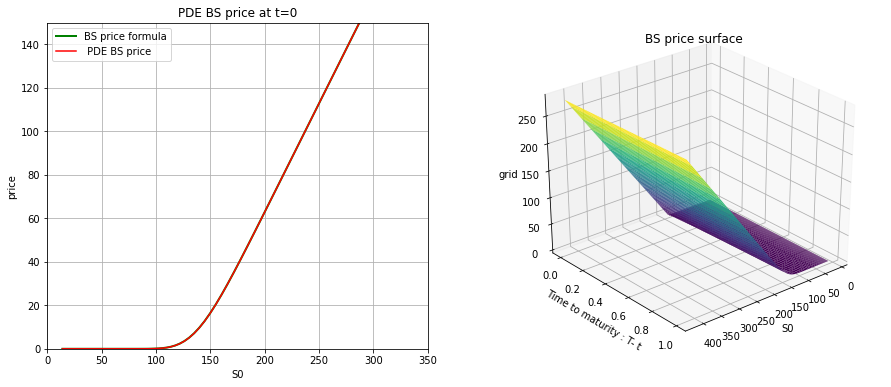

In [ ]:
S0 = 100 ; K = 140 ; T = "1y" ; t=0 ;  r=0.02 ; a = 0 ; sigma = 0.15 ; op_type = "c" 
Nx  = 100 ; Ndt = 100
call = BS_finitDiff_Schemes(S0, K, T,t, sigma,r,a,op_type,Ndt,Nx)
call.Explicit();call.plot_prices()

#### <center> Implicite </center>

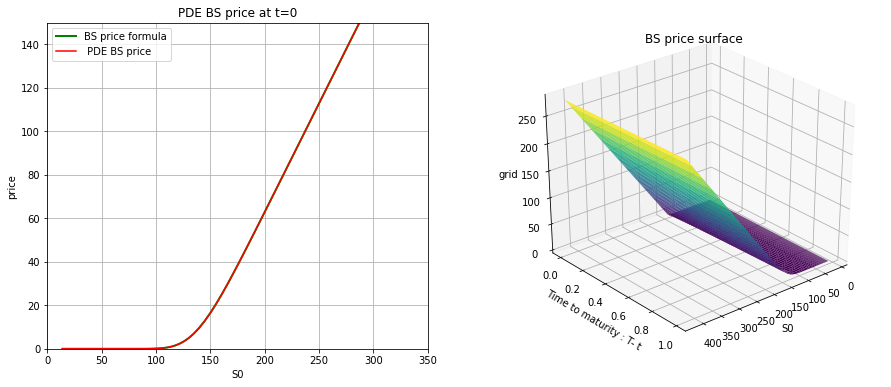

In [ ]:
S0 = 100 ; K = 140 ; T = "1y" ; t=0 ;  r=0.02 ; a = 0 ; sigma = 0.15 ; op_type = "c" 
Nx  = 100 ; Ndt = 100
call = BS_finitDiff_Schemes(S0, K, T,t, sigma,r,a,op_type,Ndt,Nx)
call.Implicit();call.plot_prices()

#### <center> Crank Nickolson </center>

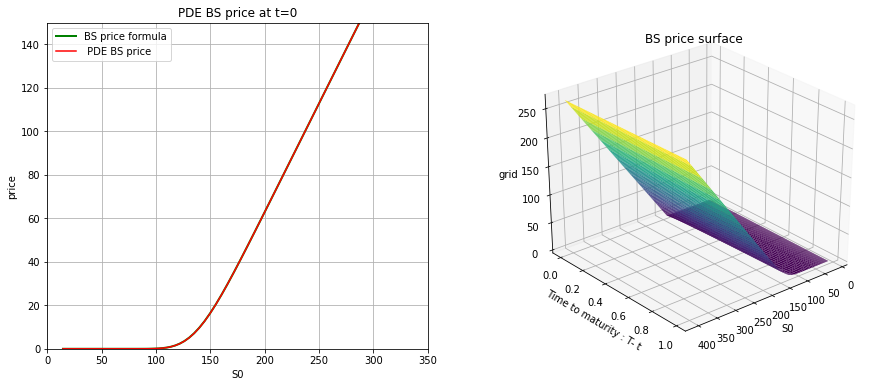

In [ ]:
S0 = 100 ; K = 140 ; T = "1y" ; t=0 ;  r=0.02 ; a = 0 ; sigma = 0.15 ; op_type = "c" 
Nx  = 100 ; Ndt = 100
call = BS_finitDiff_Schemes(S0, K, T,t, sigma,r,a,op_type,Ndt,Nx)
call.Crank_Nickolson();call.plot_prices()

### Put : Explicit , Implicit and Crank Nickolson Schemes 

#### <center> Explicite </center>

0.09627733158546735


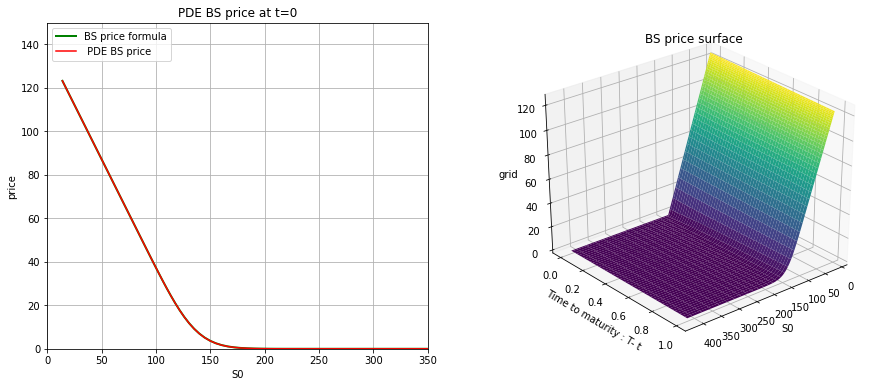

In [ ]:
S0 = 100 ; K = 140 ; T = "1y" ; t=0 ;  r=0.02 ; a = 0 ; sigma = 0.15 ; op_type = "p" 
Nx  = 100 ; Ndt = 100
put = BS_finitDiff_Schemes(S0, K, T,t, sigma,r,a,op_type,Ndt,Nx)
put.Explicit();put.plot_prices()

#### <center> Implicite </center>

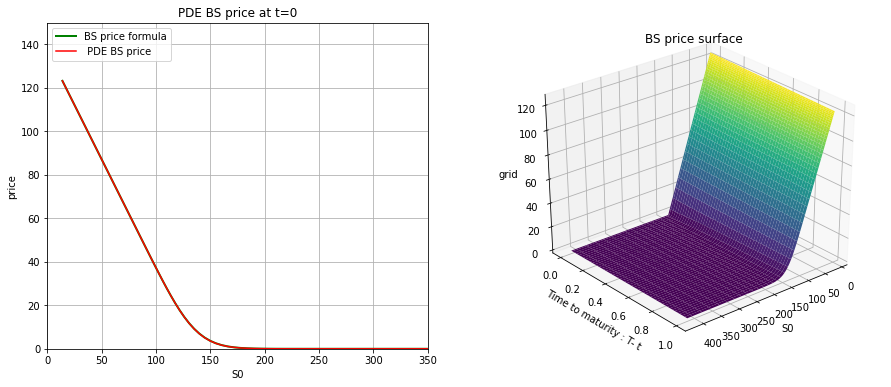

In [ ]:
S0 = 100 ; K = 140 ; T = "1y" ; t=0 ;  r=0.02 ; a = 0 ; sigma = 0.15 ; op_type = "p" 
Nx  = 100 ; Ndt = 100
put = BS_finitDiff_Schemes(S0, K, T,t, sigma,r,a,op_type,Ndt,Nx)
put.Implicit();put.plot_prices()

#### <center> Crank Nickolson </center>

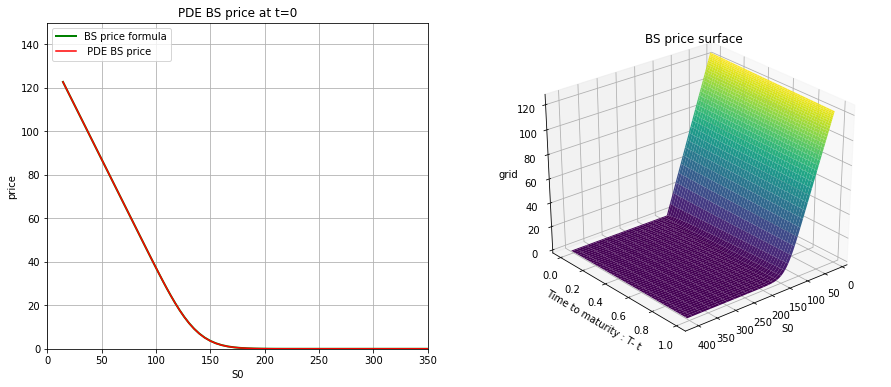

In [ ]:
S0 = 100 ; K = 140 ; T = "1y" ; t=0 ;  r=0.02 ; a = 0 ; sigma = 0.15 ; op_type = "p" 
Nx  = 100 ; Ndt = 100
put = BS_finitDiff_Schemes(S0, K, T,t, sigma,r,a,op_type,Ndt,Nx)
put.Crank_Nickolson();put.plot_prices()

## Erreurs ( $ L_{1} $ , $L_{2}$ , $L_{\infty}$ )  en Temps 

### <center> Implicite Scheme </center>

In [ ]:
#N = 1000 ;Lb = 10 ;  step = 100 
S0 = 100 ; K = 140 ; T = "1y" ; t=0 ;  r=0.02 ; a = 0 ; sigma = 0.15 ; op_type = "c"
Err_watch_L1 = list() ; Err_watch_L2 = list() ; Err_watch_L_inf = list()
x = [10,20,30,40,50,60,70,80,90,100,120,150,250,400,800]
for i in tqdm(x): 
    Derivative_prod = BS_finitDiff_Schemes(S0, K, T,t, sigma,r,a,op_type,Ndt = i,Nx = 2000)
    Derivative_prod.Implicit()
    Err_watch_L1.append(Derivative_prod.ErrorL1())
    Err_watch_L2.append(Derivative_prod.ErrorL2())
    Err_watch_L_inf.append(Derivative_prod.ErrorL_inf())

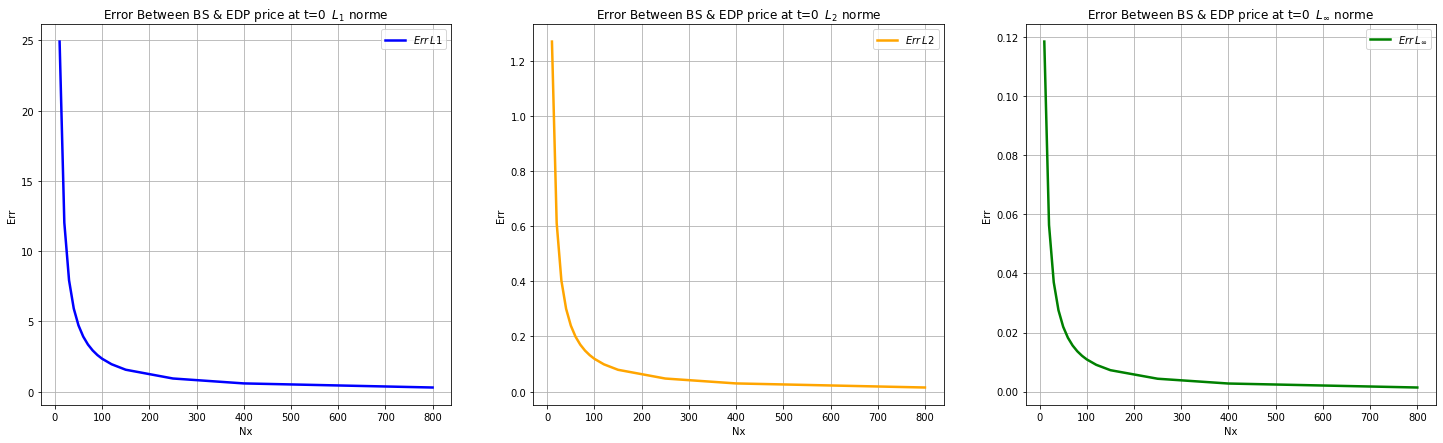

In [ ]:
fig = plt.figure(figsize=(25,7))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.plot(x,Err_watch_L1,linewidth=2.5,color='blue',label=r'$Err \: L1$')
ax2.plot(x,Err_watch_L2,linewidth=2.5,color='orange',label=r'$Err \: L2$')
ax3.plot(x,Err_watch_L_inf,linewidth=2.5,color='green',label=r'$Err \: L_{\infty}$')
ax1.set_xlabel("Nx"); ax1.set_ylabel("Err")
ax2.set_xlabel("Nx"); ax2.set_ylabel("Err")
ax3.set_xlabel("Nx"); ax3.set_ylabel("Err")
ax1.legend(loc='upper right'); ax1.set_title("Error Between BS & EDP price at t=0 "+ r'$\: L_{1}$' + " norme" )
ax2.legend(loc='upper right'); ax2.set_title("Error Between BS & EDP price at t=0 "+ r'$\: L_{2}$' + " norme")
ax3.legend(loc='upper right'); ax3.set_title("Error Between BS & EDP price at t=0 "+ r'$\: L_{\infty}$' + " norme")
ax1.grid()
ax2.grid()
ax3.grid()
plt.show()

### <center> Crank Nickolson  Scheme </center>

In [ ]:
#N = 1000 ;Lb = 10 ;  step = 100 
S0 = 100 ; K = 140 ; T = "1y" ; t=0 ;  r=0.02 ; a = 0 ; sigma = 0.15 ; op_type = "c"
Err_watch_L1 = list() ; Err_watch_L2 = list() ; Err_watch_L_inf = list()
x = [10,20,30,40,50,60,70,80,90,100,120,150,250,400,800]
for i in tqdm(x): 
    Derivative_prod = BS_finitDiff_Schemes(S0, K, T,t, sigma,r,a,op_type,Ndt = i,Nx = 2000)
    Derivative_prod.Crank_Nickolson()
    Err_watch_L1.append(Derivative_prod.ErrorL1())
    Err_watch_L2.append(Derivative_prod.ErrorL2())
    Err_watch_L_inf.append(Derivative_prod.ErrorL_inf())

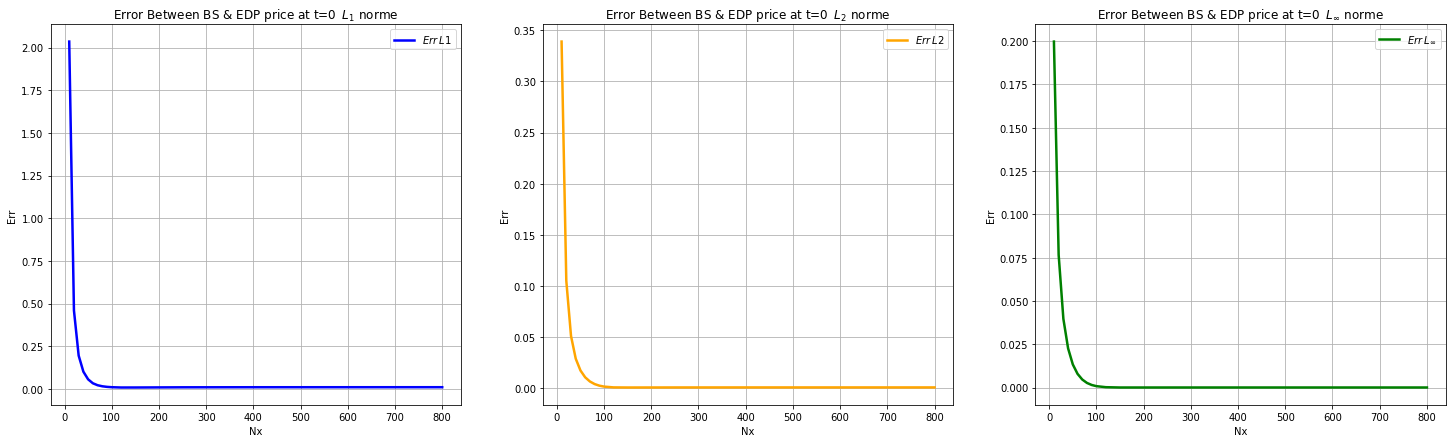

In [ ]:
fig = plt.figure(figsize=(25,7))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.plot(x,Err_watch_L1,linewidth=2.5,color='blue',label=r'$Err \: L1$')
ax2.plot(x,Err_watch_L2,linewidth=2.5,color='orange',label=r'$Err \: L2$')
ax3.plot(x,Err_watch_L_inf,linewidth=2.5,color='green',label=r'$Err \: L_{\infty}$')
ax1.set_xlabel("Nx"); ax1.set_ylabel("Err")
ax2.set_xlabel("Nx"); ax2.set_ylabel("Err")
ax3.set_xlabel("Nx"); ax3.set_ylabel("Err")
ax1.legend(loc='upper right'); ax1.set_title("Error Between BS & EDP price at t=0 "+ r'$\: L_{1}$' + " norme" )
ax2.legend(loc='upper right'); ax2.set_title("Error Between BS & EDP price at t=0 "+ r'$\: L_{2}$' + " norme")
ax3.legend(loc='upper right'); ax3.set_title("Error Between BS & EDP price at t=0 "+ r'$\: L_{\infty}$' + " norme")
ax1.grid()
ax2.grid()
ax3.grid()
plt.show()

### <center> Explicit Scheme </center>

In [ ]:
###### Impossible car Cond CFL >  0.5 dans ce cas 

## Erreurs ( $ L_{1} $ , $L_{2}$ , $L_{\infty}$ )  en Espace

### <center> Implicite Scheme </center>

In [ ]:
S0 = 100 ; K = 140 ; T = "1y" ; t=0 ;  r=0.02 ; a = 0 ; sigma = 0.15 ; op_type = "c"
Err_watch_L1 = list() ; Err_watch_L2 = list() ; Err_watch_L_inf = list()
x = [10,20,30,80,120,250,400,800]
for i in tqdm(x): 
    Derivative_prod = BS_finitDiff_Schemes(S0, K, T,t, sigma,r,a,op_type,Ndt = 2000,Nx = i)
    Derivative_prod.Implicit()
    Err_watch_L1.append(Derivative_prod.ErrorL1())
    Err_watch_L2.append(Derivative_prod.ErrorL2())
    Err_watch_L_inf.append(Derivative_prod.ErrorL_inf())

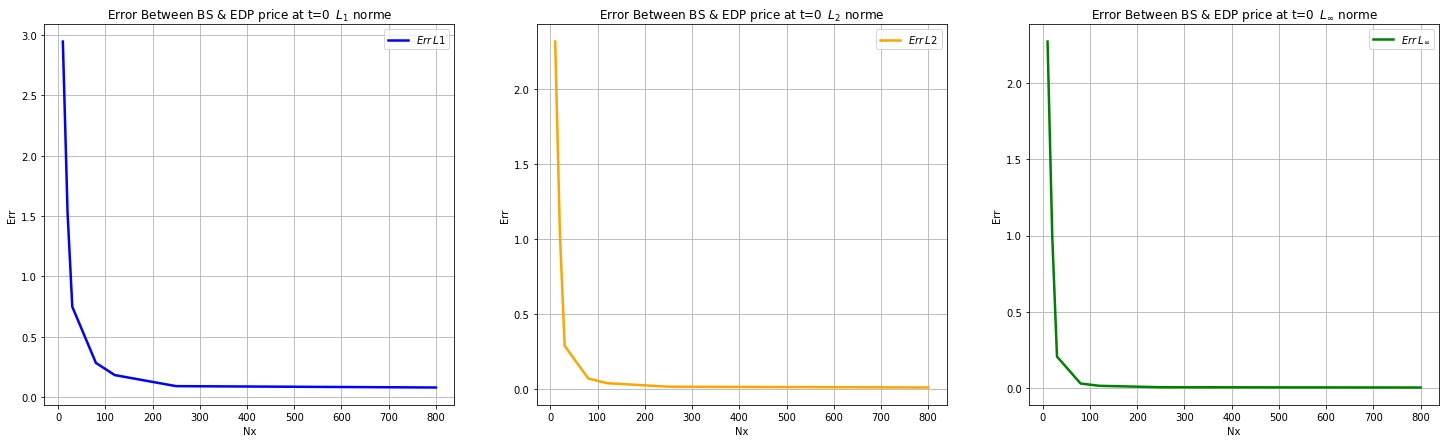

In [ ]:
fig = plt.figure(figsize=(25,7))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.plot(x,Err_watch_L1,linewidth=2.5,color='blue',label=r'$Err \: L1$')
ax2.plot(x,Err_watch_L2,linewidth=2.5,color='orange',label=r'$Err \: L2$')
ax3.plot(x,Err_watch_L_inf,linewidth=2.5,color='green',label=r'$Err \: L_{\infty}$')
ax1.set_xlabel("Nx"); ax1.set_ylabel("Err")
ax2.set_xlabel("Nx"); ax2.set_ylabel("Err")
ax3.set_xlabel("Nx"); ax3.set_ylabel("Err")
ax1.legend(loc='upper right'); ax1.set_title("Error Between BS & EDP price at t=0 "+ r'$\: L_{1}$' + " norme" )
ax2.legend(loc='upper right'); ax2.set_title("Error Between BS & EDP price at t=0 "+ r'$\: L_{2}$' + " norme")
ax3.legend(loc='upper right'); ax3.set_title("Error Between BS & EDP price at t=0 "+ r'$\: L_{\infty}$' + " norme")
ax1.grid()
ax2.grid()
ax3.grid()
plt.show()

### <center> Crank Nickolson  Scheme </center>

In [ ]:
S0 = 100 ; K = 140 ; T = "1y" ; t=0 ;  r=0.02 ; a = 0 ; sigma = 0.15 ; op_type = "c"
Err_watch_L1 = list() ; Err_watch_L2 = list() ; Err_watch_L_inf = list()
x = [10,20,30,80,120,250,400,800]
for i in tqdm(x): 
    Derivative_prod = BS_finitDiff_Schemes(S0, K, T,t, sigma,r,a,op_type,Ndt = 2000,Nx = i)
    Derivative_prod.Crank_Nickolson()
    Err_watch_L1.append(Derivative_prod.ErrorL1())
    Err_watch_L2.append(Derivative_prod.ErrorL2())
    Err_watch_L_inf.append(Derivative_prod.ErrorL_inf())

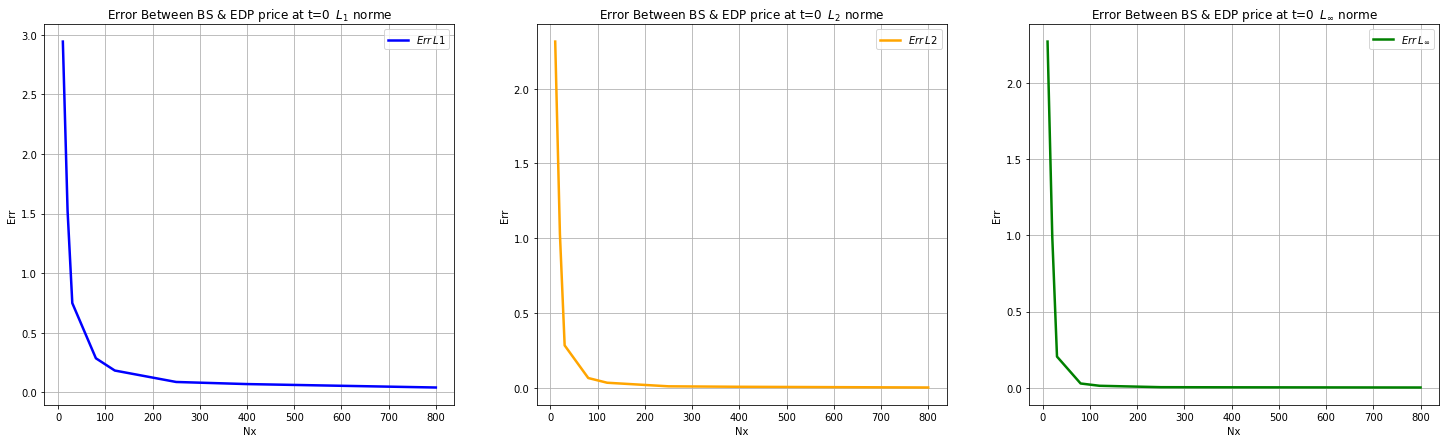

In [ ]:
fig = plt.figure(figsize=(25,7))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.plot(x,Err_watch_L1,linewidth=2.5,color='blue',label=r'$Err \: L1$')
ax2.plot(x,Err_watch_L2,linewidth=2.5,color='orange',label=r'$Err \: L2$')
ax3.plot(x,Err_watch_L_inf,linewidth=2.5,color='green',label=r'$Err \: L_{\infty}$')
ax1.set_xlabel("Nx"); ax1.set_ylabel("Err")
ax2.set_xlabel("Nx"); ax2.set_ylabel("Err")
ax3.set_xlabel("Nx"); ax3.set_ylabel("Err")
ax1.legend(loc='upper right'); ax1.set_title("Error Between BS & EDP price at t=0 "+ r'$\: L_{1}$' + " norme" )
ax2.legend(loc='upper right'); ax2.set_title("Error Between BS & EDP price at t=0 "+ r'$\: L_{2}$' + " norme")
ax3.legend(loc='upper right'); ax3.set_title("Error Between BS & EDP price at t=0 "+ r'$\: L_{\infty}$' + " norme")
ax1.grid()
ax2.grid()
ax3.grid()
plt.show()

### <center> Explicite Scheme </center>

In [ ]:
S0 = 100 ; K = 140 ; T = "1y" ; t=0 ;  r=0.02 ; a = 0 ; sigma = 0.15 ; op_type = "c"
Err_watch_L1 = list() ; Err_watch_L2 = list() ; Err_watch_L_inf = list()
x = [10,20,30,80,120,250,400,800]
for i in tqdm(x): 
    Derivative_prod = BS_finitDiff_Schemes(S0, K, T,t, sigma,r,a,op_type,Ndt = 2000,Nx = i)
    Derivative_prod.Explicit()
    Err_watch_L1.append(Derivative_prod.ErrorL1())
    Err_watch_L2.append(Derivative_prod.ErrorL2())
    Err_watch_L_inf.append(Derivative_prod.ErrorL_inf())


3.940588404516832e-05
0.0001756237548185897
0.00040914010471588343
0.0030361990410604374
0.006889218814365785
0.030163015020796064
0.07745007587499807
0.31057723185579633



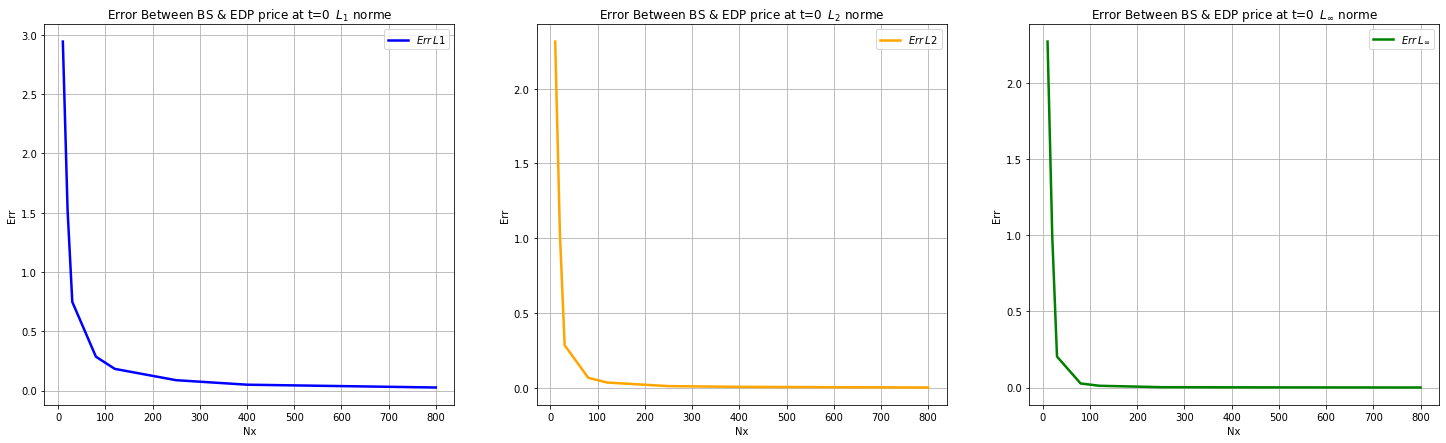

In [ ]:
fig = plt.figure(figsize=(25,7))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.plot(x,Err_watch_L1,linewidth=2.5,color='blue',label=r'$Err \: L1$')
ax2.plot(x,Err_watch_L2,linewidth=2.5,color='orange',label=r'$Err \: L2$')
ax3.plot(x,Err_watch_L_inf,linewidth=2.5,color='green',label=r'$Err \: L_{\infty}$')
ax1.set_xlabel("Nx"); ax1.set_ylabel("Err")
ax2.set_xlabel("Nx"); ax2.set_ylabel("Err")
ax3.set_xlabel("Nx"); ax3.set_ylabel("Err")
ax1.legend(loc='upper right'); ax1.set_title("Error Between BS & EDP price at t=0 "+ r'$\: L_{1}$' + " norme" )
ax2.legend(loc='upper right'); ax2.set_title("Error Between BS & EDP price at t=0 "+ r'$\: L_{2}$' + " norme")
ax3.legend(loc='upper right'); ax3.set_title("Error Between BS & EDP price at t=0 "+ r'$\: L_{\infty}$' + " norme")
ax1.grid()
ax2.grid()
ax3.grid()
plt.show()

## Convergence Schemas 

### <center> Explicite </center>

#### Temps 

In [ ]:
### Impossible de simuler en respectant la condition cfl .

#### Espace

In [ ]:
Err_watch_L_inf = list()
lb = 10 ; N = 100 ; step = 10
S0 = 100 ; K = 140 ; T = "1y" ; t=0 ;  r=0.02 ; a = 0 ; sigma = 0.15 ; op_type = "c"
for i in tqdm(range(lb,N+step,step)): 
    Derivative_prod = BS_finitDiff_Schemes(S0, K, T,t, sigma,r,a,op_type,Ndt = 10000  ,Nx = i)
    Derivative_prod.Explicit()
    Err_watch_L_inf.append(Derivative_prod.ErrorL_inf())


slope, intercept = np.polyfit(np.log(range(lb,N+step,step)),np.log(Err_watch_L_inf), 1)

7.878024023031451e-06
3.5110699658201907e-05
8.179528646135123e-05
0.00014793178443247947
0.00023352019357158655
0.00033856051387867264
0.00046305274535373754
0.0006069968879967812
0.0007703929418078039
0.0009532409067868054



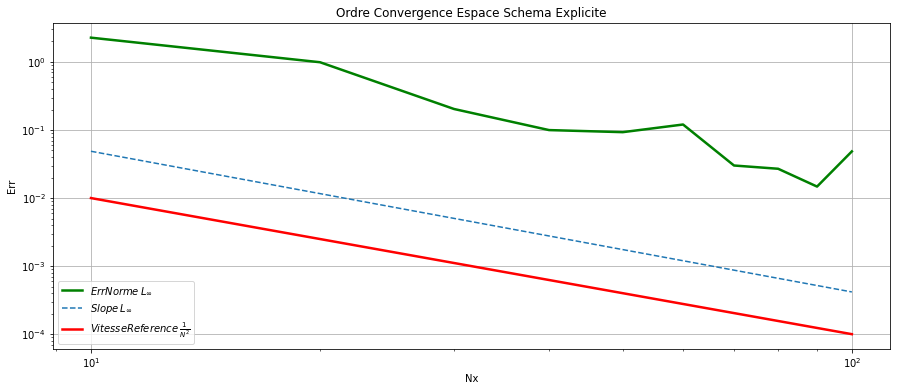

In [ ]:
xlog = range(lb,N+step,step)
ref = 1/(np.arange(lb,N+step,step)**2)
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(111)
ax1.loglog(xlog,Err_watch_L_inf,linewidth=2.5,color='green',label=r'$Err Norme  \: L_{\infty}$')
ax1.loglog(range(lb,N+step,step), intercept*range(lb,N+step,step)**(slope), "--", label=r"$Slope \: L_{\infty}$")
ax1.loglog(xlog,ref,linewidth=2.5,color='red',label=r'$ Vitesse Reference  \: \frac{1}{N^2}$')
ax1.set_xlabel("Nx"); ax1.set_ylabel("Err")
ax1.legend(loc='lower left'); ax1.set_title("Ordre Convergence Espace Schema Explicite")
ax1.grid()
plt.show()

### <center> Implicite </center>

#### Temps 

In [ ]:
Err_watch_L_inf = list()
lb = 10 ; N = 100 ; step = 10
S0 = 100 ; K = 140 ; T = "1y" ; t=0 ;  r=0.02 ; a = 0 ; sigma = 0.15 ; op_type = "c"
for i in tqdm(range(lb,N+step,step)): 
    Derivative_prod = BS_finitDiff_Schemes(S0, K, T,t, sigma,r,a,op_type,Ndt = i  ,Nx = 2000)
    Derivative_prod.Implicit()
    Err_watch_L_inf.append(Derivative_prod.ErrorL_inf())


slope, intercept = np.polyfit(np.log(range(lb,N+step,step)),np.log(Err_watch_L_inf), 1)

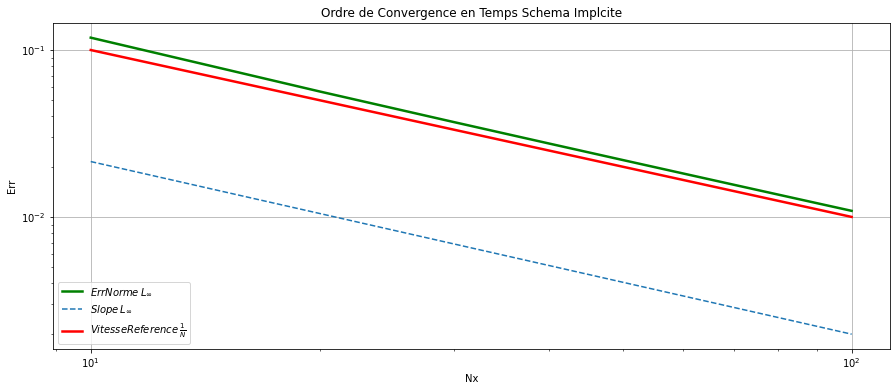

In [ ]:
xlog = range(lb,N+step,step)
ref = 1/np.arange(lb,N+step,step)
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(111)
ax1.loglog(xlog,Err_watch_L_inf,linewidth=2.5,color='green',label=r'$Err Norme  \: L_{\infty}$')
ax1.loglog(range(lb,N+step,step), intercept*range(lb,N+step,step)**(slope), "--", label=r"$Slope \: L_{\infty}$")
ax1.loglog(xlog,ref,linewidth=2.5,color='red',label=r'$ Vitesse Reference  \: \frac{1}{N}$')
ax1.set_xlabel("Nx"); ax1.set_ylabel("Err")
ax1.legend(loc='lower left'); ax1.set_title("Ordre de Convergence en Temps Schema Implcite")
ax1.grid()
plt.show()

#### Espace

In [ ]:
Err_watch_L_inf = list()
lb = 10 ; N = 100 ; step = 10
S0 = 100 ; K = 140 ; T = "1y" ; t=0 ;  r=0.02 ; a = 0 ; sigma = 0.15 ; op_type = "c"
for i in tqdm(range(lb,N+step,step)): 
    Derivative_prod = BS_finitDiff_Schemes(S0, K, T,t, sigma,r,a,op_type,Ndt = 10000  ,Nx = i)
    Derivative_prod.Implicit()
    Err_watch_L_inf.append(Derivative_prod.ErrorL_inf())


slope, intercept = np.polyfit(np.log(range(lb,N+step,step)),np.log(Err_watch_L_inf), 1)

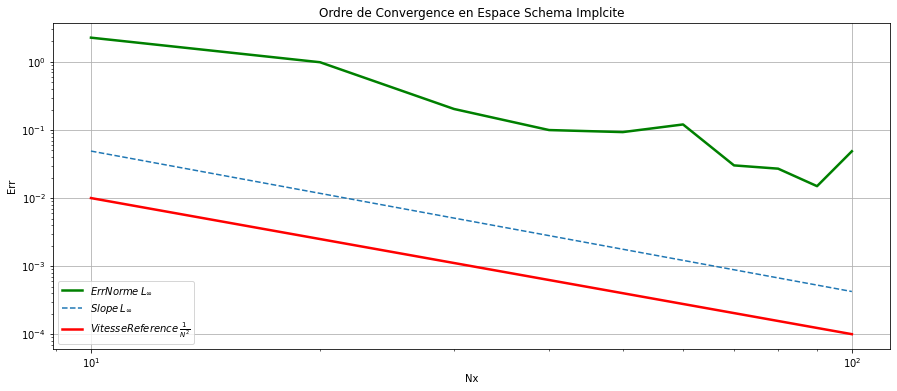

In [ ]:
xlog = range(lb,N+step,step)
ref = 1/(np.arange(lb,N+step,step)**2)
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(111)
ax1.loglog(xlog,Err_watch_L_inf,linewidth=2.5,color='green',label=r'$Err Norme  \: L_{\infty}$')
ax1.loglog(range(lb,N+step,step), intercept*range(lb,N+step,step)**(slope), "--", label=r"$Slope \: L_{\infty}$")
ax1.loglog(xlog,ref,linewidth=2.5,color='red',label=r'$ Vitesse Reference  \: \frac{1}{N^2}$')
ax1.set_xlabel("Nx"); ax1.set_ylabel("Err")
ax1.legend(loc='lower left'); ax1.set_title("Ordre de Convergence en Espace Schema Implcite")
ax1.grid()
plt.show()

### <center> Crank Nickolson  </center>

#### Temps 

In [ ]:
Err_watch_L_inf = list()
lb = 10 ; N = 100 ; step = 10
S0 = 100 ; K = 140 ; T = "1y" ; t=0 ;  r=0.02 ; a = 0 ; sigma = 0.15 ; op_type = "c"
for i in tqdm(range(lb,N+step,step)): 
    Derivative_prod = BS_finitDiff_Schemes(S0, K, T,t, sigma,r,a,op_type,Ndt = i  ,Nx = 2000)
    Derivative_prod.Crank_Nickolson()
    Err_watch_L_inf.append(Derivative_prod.ErrorL_inf())


slope, intercept = np.polyfit(np.log(range(lb,N+step,step)),np.log(Err_watch_L_inf), 1)

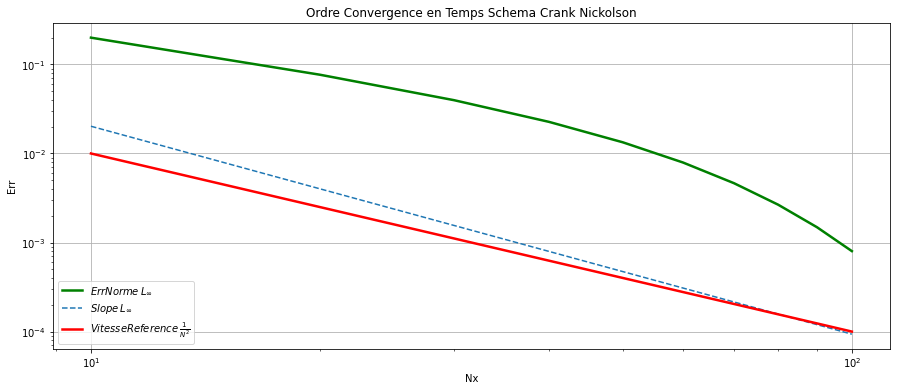

In [ ]:
xlog = range(lb,N+step,step)
ref = 1/(np.arange(lb,N+step,step)**2)
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(111)
ax1.loglog(xlog,Err_watch_L_inf,linewidth=2.5,color='green',label=r'$Err Norme  \: L_{\infty}$')
ax1.loglog(range(lb,N+step,step), intercept*range(lb,N+step,step)**(slope), "--", label=r"$Slope \: L_{\infty}$")
ax1.loglog(xlog,ref,linewidth=2.5,color='red',label=r'$ Vitesse Reference  \: \frac{1}{N^2}$')
ax1.set_xlabel("Nx"); ax1.set_ylabel("Err")
ax1.legend(loc='lower left'); ax1.set_title("Ordre Convergence en Temps Schema Crank Nickolson")
ax1.grid()
plt.show()

#### Espace

In [ ]:
Err_watch_L_inf = list()
lb = 10 ; N = 100 ; step = 10
S0 = 100 ; K = 140 ; T = "1y" ; t=0 ;  r=0.02 ; a = 0 ; sigma = 0.15 ; op_type = "c"
for i in tqdm(range(lb,N+step,step)): 
    Derivative_prod = BS_finitDiff_Schemes(S0, K, T,t, sigma,r,a,op_type,Ndt = 10000  ,Nx = i)
    Derivative_prod.Crank_Nickolson()
    Err_watch_L_inf.append(Derivative_prod.ErrorL_inf())


slope, intercept = np.polyfit(np.log(range(lb,N+step,step)),np.log(Err_watch_L_inf), 1)

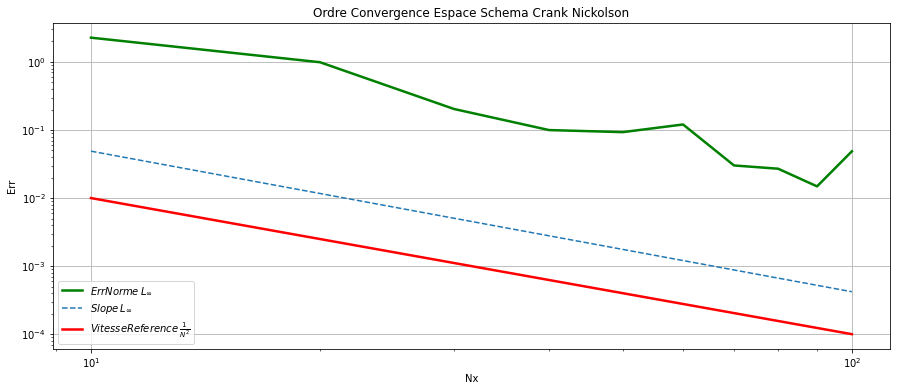

In [ ]:
xlog = range(lb,N+step,step)
ref = 1/(np.arange(lb,N+step,step)**2)
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(111)
ax1.loglog(xlog,Err_watch_L_inf,linewidth=2.5,color='green',label=r'$Err Norme  \: L_{\infty}$')
ax1.loglog(range(lb,N+step,step), intercept*range(lb,N+step,step)**(slope), "--", label=r"$Slope \: L_{\infty}$")
ax1.loglog(xlog,ref,linewidth=2.5,color='red',label=r'$ Vitesse Reference  \: \frac{1}{N^2}$')
ax1.set_xlabel("Nx"); ax1.set_ylabel("Err")
ax1.legend(loc='lower left'); ax1.set_title("Ordre Convergence Espace Schema Crank Nickolson")
ax1.grid()
plt.show()

## Erreur Ponctuelle ; Ndt = 400 ; Nx = 400

### Call : Explicit , Implicit and Crank Nickolson Schemes 

0.3880268212383989


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars


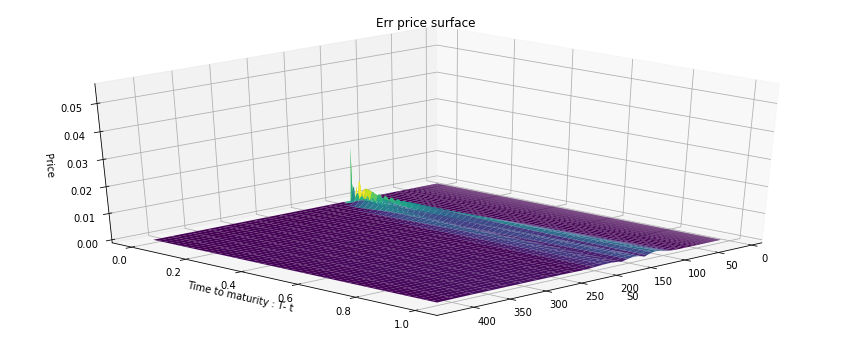

In [ ]:
S0 = 100 ; K = 140 ; T = "1y" ; t=0 ;  r=0.02 ; a = 0 ; sigma = 0.15 ; op_type = "c" 
Nx  = 400 ;Ndt = 400
call = BS_finitDiff_Schemes(S0, K, T,t, sigma,r,a,op_type,Ndt,Nx)
call.Explicit();call.Consistance_error();call.plot_Tronc_err()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars


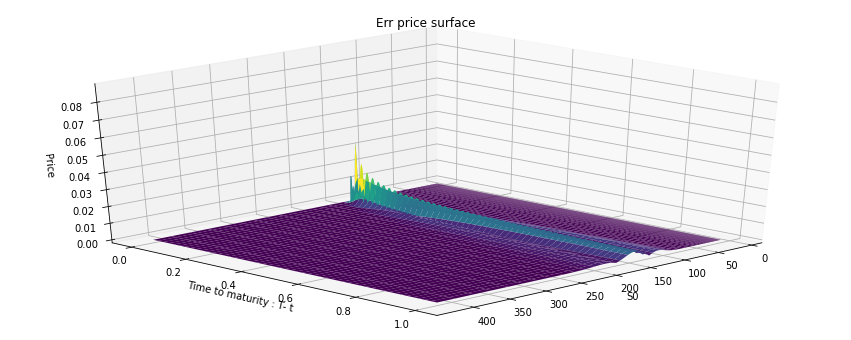

In [ ]:
S0 = 100 ; K = 140 ; T = "1y" ; t=0 ;  r=0.02 ; a = 0 ; sigma = 0.15 ; op_type = "c" 
Nx  = 400 ;Ndt = 400
call = BS_finitDiff_Schemes(S0, K, T,t, sigma,r,a,op_type,Ndt,Nx)
call.Implicit();call.Consistance_error();call.plot_Tronc_err()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars


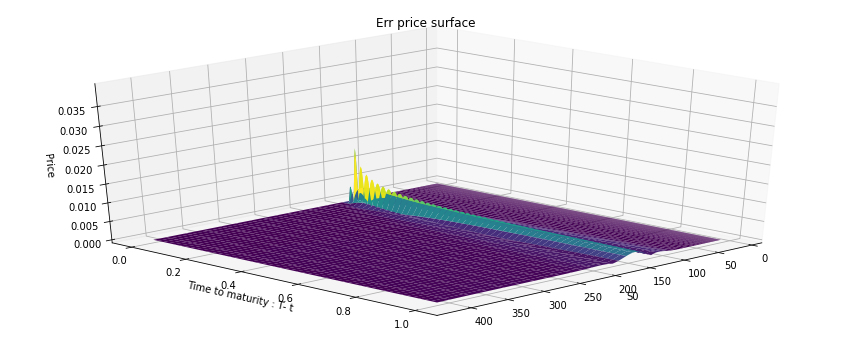

In [ ]:
S0 = 100 ; K = 140 ; T = "1y" ; t=0 ;  r=0.02 ; a = 0 ; sigma = 0.15 ; op_type = "c" 
Nx  = 400 ;Ndt = 400
call = BS_finitDiff_Schemes(S0, K, T,t, sigma,r,a,op_type,Ndt,Nx)
call.Crank_Nickolson();call.Consistance_error();call.plot_Tronc_err()

### Put : Explicit , Implicit and Crank Nickolson Schemes 

0.3880268212383989


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars


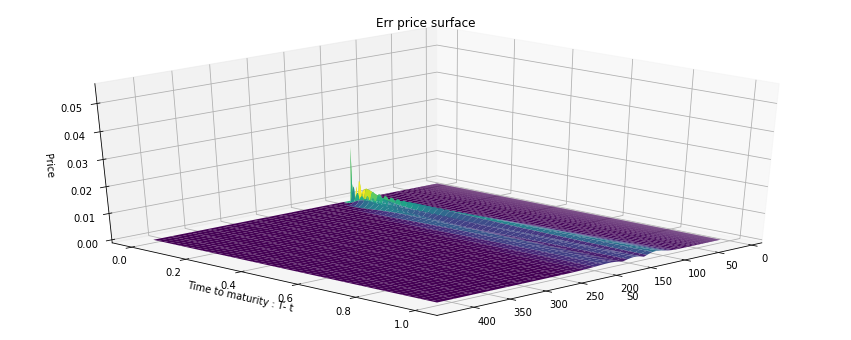

In [ ]:
S0 = 100 ; K = 140 ; T = "1y" ; t=0 ;  r=0.02 ; a = 0 ; sigma = 0.15 ; op_type = "p" 
Nx  = 400 ;Ndt = 400
put = BS_finitDiff_Schemes(S0, K, T,t, sigma,r,a,op_type,Ndt,Nx)
put.Explicit();put.Consistance_error();put.plot_Tronc_err()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars


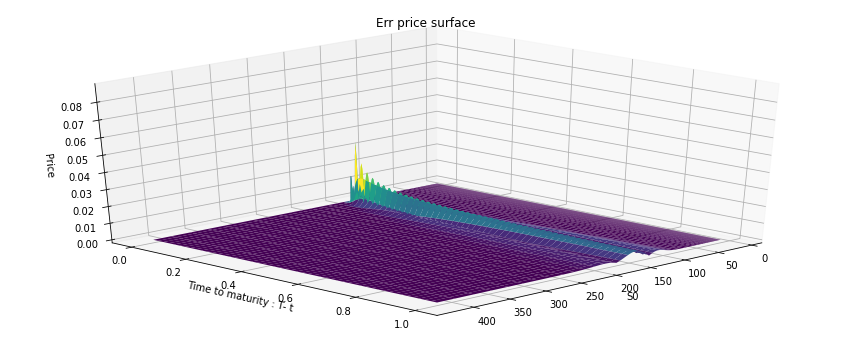

In [ ]:
S0 = 100 ; K = 140 ; T = "1y" ; t=0 ;  r=0.02 ; a = 0 ; sigma = 0.15 ; op_type = "p" 
Nx  = 400 ;Ndt = 400
put = BS_finitDiff_Schemes(S0, K, T,t, sigma,r,a,op_type,Ndt,Nx)
put.Implicit();put.Consistance_error();put.plot_Tronc_err()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars


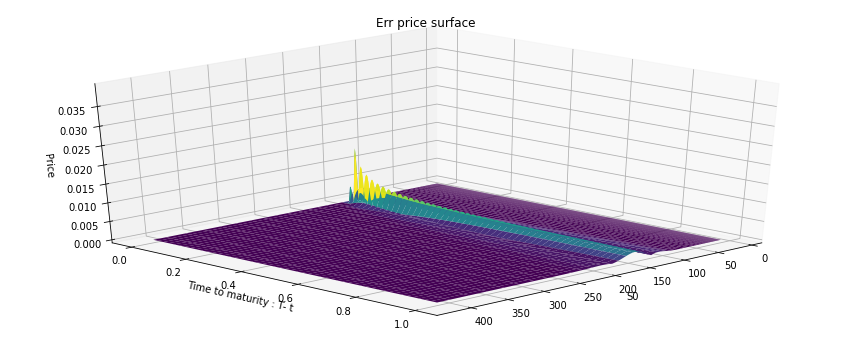

In [ ]:
S0 = 100 ; K = 140 ; T = "1y" ; t=0 ;  r=0.02 ; a = 0 ; sigma = 0.15 ; op_type = "p" 
Nx  = 400 ;Ndt = 400
put = BS_finitDiff_Schemes(S0, K, T,t, sigma,r,a,op_type,Ndt,Nx)
put.Crank_Nickolson();put.Consistance_error();put.plot_Tronc_err()

# <center> EDS & Heston </center>

# Classe EDS générale

In [ ]:
class EDS(object):
  """ Classe parente pour discretisation et resolution d'une équation : dXt = a(Xt, t)dt + b(Xt, t)dBt """
  def __init__(self):
    # Notre vecteur de pas de temps
    self.t, self.dt = np.linspace(0, self.T, self.Ndt, retstep=True)

  def euler_maruyama(self, x):
    """ Retourne une trajectoire selon le schéma d'Euler-Maruyama """
    S = np.zeros(self.t.shape[0])
    S[0] = self.Spath[0,0] # On initialise à So 
    for i in range(self.t.shape[0] - 1):
      S[i+1] = S[i] + self.a(S[i], self.t[i])*self.dt + self.b(S[i], self.t[i])*np.sqrt(self.dt)*x[i]
    return S
  
  def milstein(self, x):
    """ Retourne une trajectoire selon le schéma de milstein """
    S = np.zeros(self.t.shape[0])
    S[0] = self.Spath[0,0] 
    for i in range(self.t.shape[0] - 1):
      S[i+1] = S[i] + self.a(S[i], self.t[i])*self.dt + self.b(S[i], self.t[i])*np.sqrt(self.dt)*x[i] + 0.5*self.b(S[i], self.t[i])*self.bprim(S[i], self.t[i])*self.dt*(x[i]**2 - 1)
    return S

# EDS pour BS

In [ ]:
class EDS_BS(EDS):
  """ Discretisation de l'EDS de Black&Scholes"""
  def __init__(self, Ndt=1000, nb_sim_path=1000, So=100, K=100, T=1, sigma=0.25, r=0.05, scheme="Euler", calc_order=False): 
    self.nb_sim_path = nb_sim_path
    self.So = So
    self.Ndt = Ndt
    self.K = K
    self.T = T
    self.sigma = sigma
    self.r = r
    self.calc_order = calc_order
    self.Spath = np.zeros((self.Ndt, self.nb_sim_path)); self.Spath[0,:] = self.So
    super().__init__()
    
    # Notre vecteur de va normales
    x = np.random.normal(0,1,size=(self.Ndt, self.nb_sim_path))

    # Trajectoires de la solution de l'EDS de BS
    if calc_order:
      self.X_sol = np.zeros((self.Ndt, self.nb_sim_path)); self.X_sol[0,:] = self.So
      for sim in range(nb_sim_path):
        for i in range(0, self.t.shape[0] - 1):
          self.X_sol[i+1,sim] = self.X_sol[i,sim]*np.exp((self.r - 0.5*self.sigma**2)*self.dt + self.sigma*np.sqrt(self.dt)*x[i,sim])

    # Trajectoires avec les schemas
    if scheme.lower() == "euler":
      for sim in range(nb_sim_path):
        self.Spath[:,sim] = self.euler_maruyama(x[:,sim])
    elif scheme.lower() == "milstein":
      for sim in range(nb_sim_path):
        self.Spath[:,sim] = self.milstein(x[:,sim])

    # On calcule notre estimation
    self.h_x = np.array([np.exp(self.r*self.T)*np.maximum(self.Spath[-1,sim] - self.K,0) for sim in range(nb_sim_path)])
    self.res = np.average(self.h_x)

    # On calcule notre vecteur d'erreur forte/faible ainsi que les esperances associées
    if calc_order:
      # Erreur forte
      self.strong_err = np.array([np.abs(self.Spath[-1,sim] - self.X_sol[-1,sim]) for sim in range(nb_sim_path)])
      self.esp_strong_err = np.average(self.strong_err)
      # Erreur faible
      self.weak_err = np.abs(self.res - np.average(np.array([np.exp(self.r*self.T)*np.maximum(self.X_sol[-1,sim] - self.K,0) for sim in range(nb_sim_path)])))

  def a(self, S, t):
    return self.r*S

  def b(self, S, t):
    return self.sigma*S

  def bprim(self, S, t):
    return self.sigma

## Schéma Euler - ordres fort et faible 

Text(-15, -15, 'Slope = -0.507')

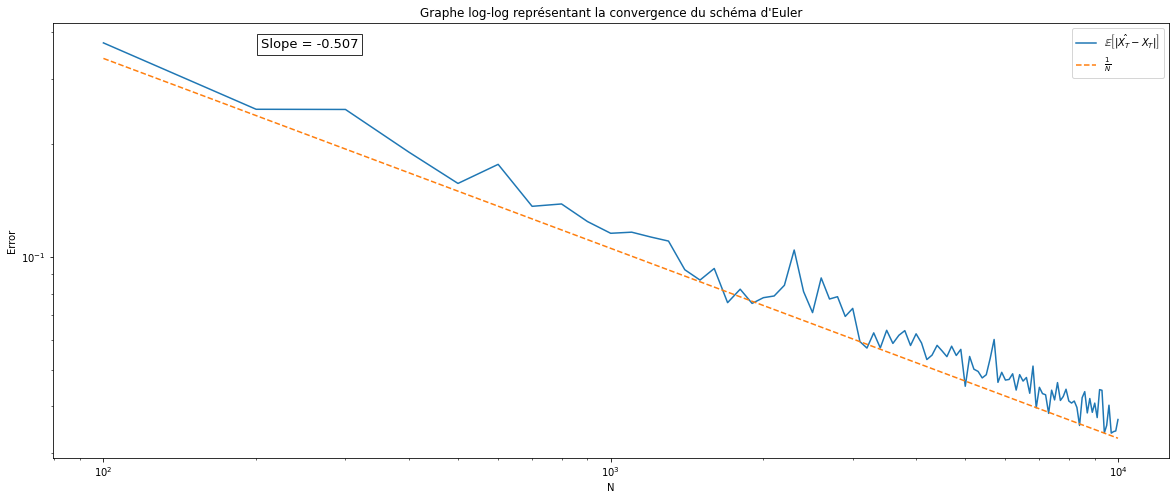

In [ ]:
# Ordre fort
N = 10000
step = int(N/100) # step du nombre de pas de discrétisation
strong_errs = []
Nlist = np.arange(100, N+step, step)
for i in tqdm(Nlist):
    a = EDS_BS(Ndt=i, calc_order=True, nb_sim_path=100 , scheme="euler")
    strong_errs.append(a.esp_strong_err)

# On calcule l'intercept et le coefficient de pente
slope, intercept = np.polyfit(np.log(Nlist),np.log(strong_errs), 1)

# On affiche le graphique représentant l'ordre de convergence
fig, ax = plt.subplots(1,1,figsize=(20,8))
ax.set(xlabel="N", ylabel="Error", title="Graphe log-log représentant la convergence du schéma d'Euler")
ax.loglog(Nlist, strong_errs, label=r"$\mathbb{E}\left[|\hat{X_T} - X_T|\right]$")
ax.loglog(Nlist, 3.5*Nlist**(slope), "--", label=r"$\frac{1}{N}$") #3.5 pour avoir une droite moyennant l'erreur
ax.legend()
ax.annotate(f"Slope = {round(np.average(slope),3)}", xy=(0.2, 1), xytext=(-15, -15), fontsize=13,xycoords='axes fraction', textcoords='offset points', bbox=dict(facecolor='white', alpha=0.8), horizontalalignment='left', verticalalignment='top')

In [ ]:
# Ordre faible
N = 1000
step = int(N/10)
weak_errs = []
Nlist = np.arange(10, N+step, step)
for i in tqdm(Nlist):
    a = EDS_BS(Ndt=i, calc_order=True, nb_sim_path=10000 , scheme="euler")
    weak_errs.append(a.weak_err)

slope, intercept = np.polyfit(np.log(Nlist),np.log(weak_errs), 1)

fig, ax = plt.subplots(1,1,figsize=(20,8))
ax.set(xlabel="N", ylabel="Error", title="Graphe log-log représentant la convergence du schéma d'Euler")
ax.loglog(Nlist, weak_errs, label=r"$\mathbb{E}\left[|\hat{X_T} - X_T|\right]$")
ax.loglog(Nlist, Nlist**(slope), "--", label=r"$\frac{1}{N}$")
ax.legend()
ax.annotate(f"Slope = {round(np.average(slope),3)}", xy=(0.2, 1), xytext=(-15, -15), fontsize=13,xycoords='axes fraction', textcoords='offset points', bbox=dict(facecolor='white', alpha=0.8), horizontalalignment='left', verticalalignment='top')

## Schéma Milstein - ordres fort et faible 

In [ ]:
# Ordre fort
N = 10000
step = int(N/100)
strong_errs = []
Nlist = np.arange(100, N+step, step)
for i in tqdm(Nlist):
    a = EDS_BS(Ndt=i, calc_order=True, nb_sim_path=100 , scheme="milstein")
    strong_errs.append(a.esp_strong_err)

slope, intercept = np.polyfit(np.log(Nlist),np.log(strong_errs), 1)

fig, ax = plt.subplots(1,1,figsize=(20,8))
ax.set(xlabel="N", ylabel="Error", title="Graphe log-log représentant la convergence du schéma d'Euler")
ax.loglog(Nlist, strong_errs, label=r"$\mathbb{E}\left[|\hat{X_T} - X_T|\right]$")
ax.loglog(Nlist, intercept*Nlist**(slope), "--", label=r"$\frac{1}{N}$")
ax.legend()
ax.annotate(f"Slope = {round(np.average(slope),3)}", xy=(0.2, 1), xytext=(-15, -15), fontsize=13,xycoords='axes fraction', textcoords='offset points', bbox=dict(facecolor='white', alpha=0.8), horizontalalignment='left', verticalalignment='top')

Text(-15, -15, 'Slope = -0.994')

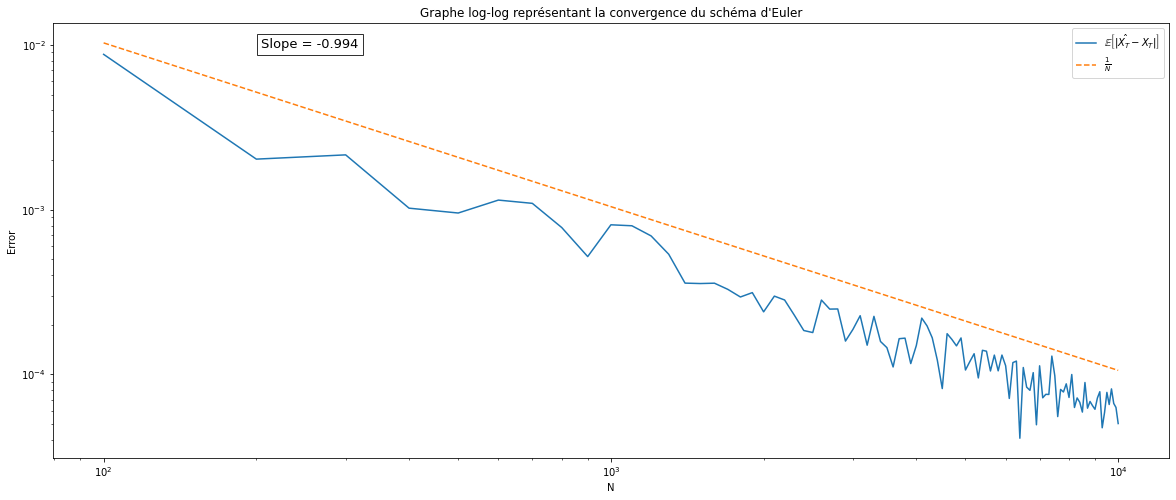

In [ ]:
# Ordre faible
N = 10000
step = int(N/100)
weak_errs = []
Nlist = np.arange(100, N+step, step)
for i in tqdm(Nlist):
    a = EDS_BS(Ndt=i, calc_order=True, nb_sim_path=100 , scheme="milstein")
    weak_errs.append(a.weak_err)

slope, intercept = np.polyfit(np.log(Nlist),np.log(weak_errs), 1)

fig, ax = plt.subplots(1,1,figsize=(20,8))
ax.set(xlabel="N", ylabel="Error", title="Graphe log-log représentant la convergence du schéma d'Euler")
ax.loglog(Nlist, weak_errs, label=r"$\mathbb{E}\left[|\hat{X_T} - X_T|\right]$")
ax.loglog(Nlist, Nlist**(slope), "--", label=r"$\frac{1}{N}$")
ax.legend()
ax.annotate(f"Slope = {round(np.average(slope),3)}", xy=(0.2, 1), xytext=(-15, -15), fontsize=13,xycoords='axes fraction', textcoords='offset points', bbox=dict(facecolor='white', alpha=0.8), horizontalalignment='left', verticalalignment='top')

# Modèle de Heston

In [ ]:
class Heston(EDS, MonteCarloBS):
  """ Classe pour modèle de Heston. Dérivant de la classe EDS pour schéma et de la classe de MonteCarlo. 
      Discrétisation du processus CIR."""
  def __init__(self, Ndt=1000, nb_sim_path=1000, So=100, K=100, T=1, r=0.05, vbar=0.2**2, lambd=5, eta=0.5, rho=-0.7, cond_bords="refl", display_text=False, fix_seed=False):
    if np.abs(rho) > 1:
      raise ValueError("On doit avoir |rho| <= 1.")
    elif eta < 0 or lambd < 0 or vbar < 0:
      raise ValueError("Les paramètres ne peuvent pas être négatifs.")
                                                 # None car pas de sigma ici
    MonteCarloBS.__init__(self, nb_sim_path, So, K, T, None, r, False, False, display_text)
    self.Ndt = Ndt
    self.nb_sim_path = nb_sim_path
    self.vbar = vbar
    self.lambd = lambd
    self.eta = eta
    self.rho = rho
    self.cond_bords = cond_bords
    EDS.__init__(self)

    # On initialise nos trajectoires ave cle changement de variable log pour St
    self.Spath = np.zeros((self.Ndt, self.nb_sim_path)); self.Spath[0,:] = np.log(self.So)
    self.vpath = np.zeros((self.Ndt, self.nb_sim_path)); self.vpath[0,:] = self.vbar # le CIR partira toujours de sa moyenne long-terme

    # Matrice de covariance
    self.Mcov = np.array([1, self.rho, self.rho, 1]).reshape((2,2))

    # On simule nos browniens corrélés, <W_1, W_2> = \rho dt
    if fix_seed: np.random.seed(25)
    corr_B = np.random.multivariate_normal([0,0], self.Mcov, size=(self.nb_sim_path, self.Ndt))
    
    for sim in tqdm(range(self.nb_sim_path), desc="Simulations"):
      B_S = corr_B[sim][:,0]
      B_v = corr_B[sim][:,1]
    # On calcule nos trajectoires en utilisant directement euler ici
      for i in range(self.t.shape[0] - 1):
        self.Spath[i+1,sim] = self.Spath[i,sim] + (self.r - 0.5*self.vpath[i,sim])*self.dt + np.sqrt(self.vpath[i,sim])*np.sqrt(self.dt)*B_S[i]
        if self.cond_bords == "refl":
          self.vpath[i+1,sim] = np.abs(self.vpath[i,sim] - self.lambd*(self.vpath[i,sim] - self.vbar)*self.dt + self.eta*np.sqrt(self.vpath[i,sim])*np.sqrt(self.dt)*B_v[i])
        elif self.cond_bords == "abs":
          self.vpath[i+1,sim] = np.maximum(self.vpath[i,sim] - self.lambd*(self.vpath[i,sim] - self.vbar)*self.dt + self.eta*np.sqrt(self.vpath[i,sim])*np.sqrt(self.dt)*B_v[i], 0)

    # On repasse a l'exponentielle pour les prix
    self.Spath = np.exp(self.Spath)

    # On calcule notre prix de Monte-Carlo
    self.h_x = np.array([np.exp(-self.r*self.T)*np.maximum(self.Spath[-1, sim] - self.K, 0) for sim in range(self.nb_sim_path)])
    self.res = np.average(self.h_x)
    self.display_results(self.h_x, self.res)
    
    # Volatilité implicite du modèle
    self.vol_impl = self.vol_implicite()
    
  def vol_implicite(self):
    """ Calcul de la volatilité implicite par dichotomie (avec bisect de scipy)"""
    def objective(vol):
      return self.res - Call(St=self.So, K=self.K, T=self.T, r=self.r, sigma=vol).price()
    
    return optimize.bisect(objective,0, 10000)

In [ ]:
a = Heston(eta=0, K=70, display_text=True)

--------------- Heston(Call) ---------------
Nombre de simulations de trajectoires : 1000. Aucune réduction de variance.



Ecart-type h(X): 20.279
Estimation : 33.574516435432145
Intervalle de confiance (95%) : [32.318,34.831]




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars


In [ ]:
a.vol_impl

0.20776751855522413

## Evolution de $S_t$ et $v_t$

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in double_scalars


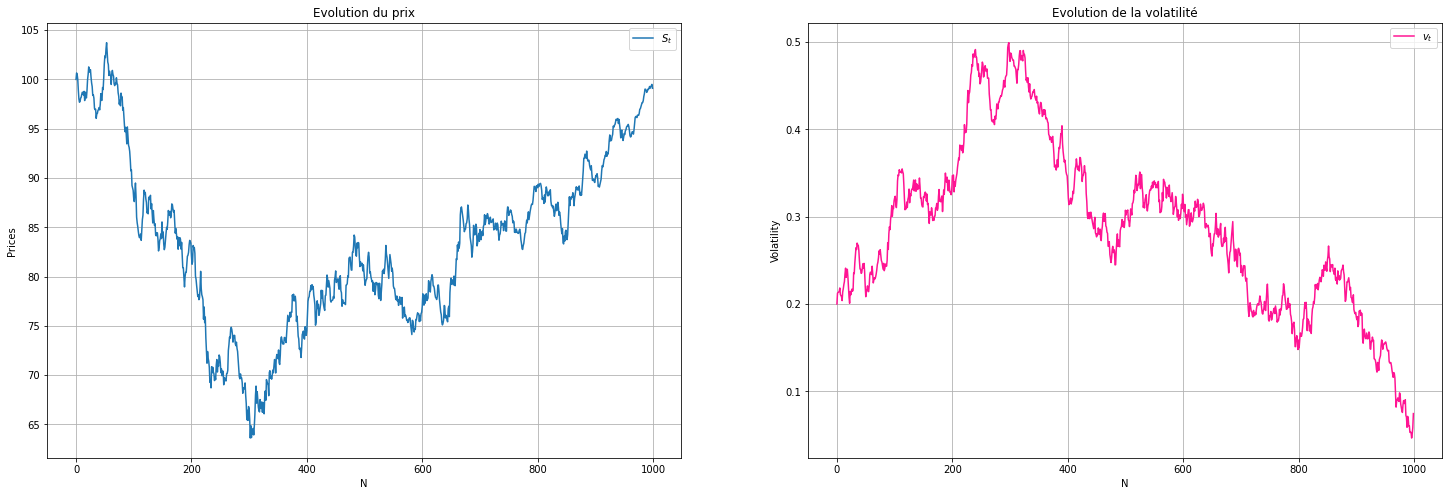

In [ ]:
Hs = Heston(display_text=False, lambd=1, nb_sim_path=10);
fig, ax = plt.subplots(1,2,figsize=(25,8))
ax[0].set(xlabel="N", ylabel="Prices", title="Evolution du prix")
ax[1].set(xlabel="N", ylabel="Volatility", title="Evolution de la volatilité")
# On affiche les premières simulations St et vt
Spath = pd.DataFrame(Hs.Spath[:,0], columns=[r"$S_t$"])
vpath = pd.DataFrame(Hs.vpath[:,0], columns=[r"$v_t$"])
Spath.plot(grid=True, ax=ax[0])
np.sqrt(vpath).plot(grid=True, ax=ax[1], color="deeppink");

## Smile de volatilité

In [ ]:
# On calcule notre volatilité implicite pour plusieurs strikes
strikes = np.arange(60,180,10)
vols_impl = []
for K in tqdm(strikes, desc="Strikes"):
  vols_impl.append(Heston(K=K, nb_sim_path=10000, lambd=1, rho=-0.7, eta=0.5, fix_seed=True).vol_impl)

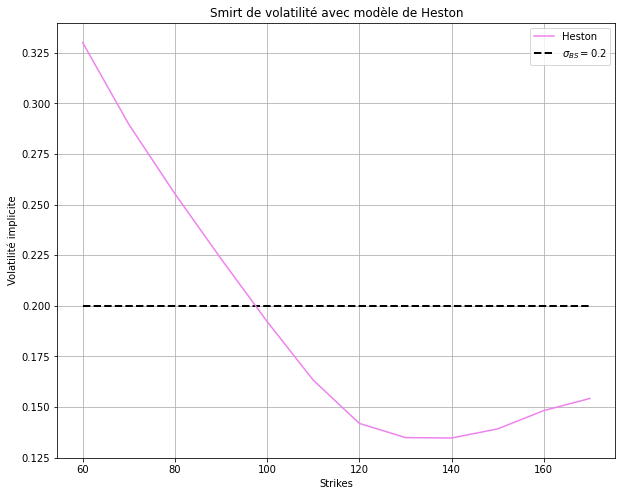

In [ ]:
# On affiche le smile
fig, ax = plt.subplots(figsize=(10,8))
ax.set(xlabel="Strikes", ylabel="Volatilité implicite", title="Smirt de volatilité avec modèle de Heston")
ax.grid()
# On affiche également la volatilité de 0.2 dans le cas de BS 
ax.hlines(0.2,60,170,colors="black", linestyle="--", linewidth=2, label=r"$\sigma_{BS}=0.2$")
ax.plot(strikes, vols_impl, color="violet", label="Heston");
ax.legend()

## En fonction de $\lambda \in \{1,10,100,1000\}$

In [ ]:
lambdas = np.logspace(0, 3,4)
strikes = np.arange(60,150,10)
vols_lambdtot = []

for lambd in tqdm(lambdas, desc="Lambdas"):
  vols_impl=[]
  for K in tqdm(strikes, desc="Strikes"):
    vols_impl.append(Heston(K=K, nb_sim_path=1000, lambd=lambd, fix_seed=True).vol_impl)
  vols_lambdtot.append(vols_impl)

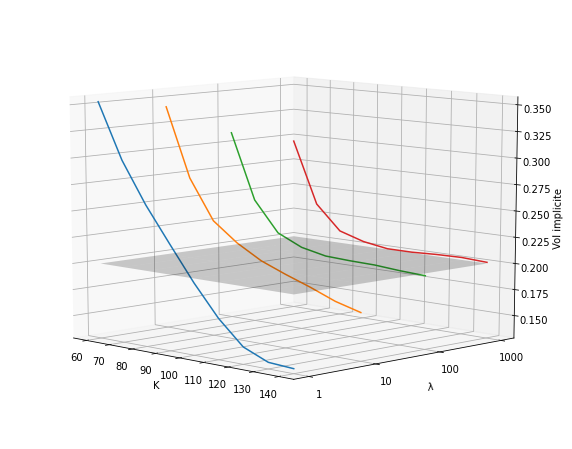

In [ ]:
fig = plt.figure(figsize=(10,8))
ax = fig.gca(projection='3d')

for i, vol_lambd in enumerate(vols_lambdtot):
  ax.plot(strikes, vol_lambd, zs=i+1, zdir="y", label=f"T={lambdas[i]}")

# Pour la surface représentant le sigma_BS = 0.2
xx, yy = np.meshgrid(strikes, range(1,5))
zz = 0*yy + 0.2

ax.plot_surface(xx,yy, zz, alpha=0.2, color="black", label=r"$\sigma_{BS}$")
ax.set(xlabel="K", ylabel=r"$\lambda", zlabel="Vol implicite", yticks=[1,2,3,4], yticklabels=('1','10', '100','1000'))
ax.view_init(elev=10., azim=-45)

## En fonction de $\eta$

In [ ]:
etas = np.arange(0, 1,0.3)
strikes = np.arange(60,150,10)
vols_etatot = []

for eta in tqdm(etas, desc="Etas"):
  vols_impl=[]
  for K in tqdm(strikes, desc="Strikes"):
    vols_impl.append(Heston(K=K, nb_sim_path=1000, eta=eta, fix_seed=True).vol_impl)
  vols_etatot.append(vols_impl)

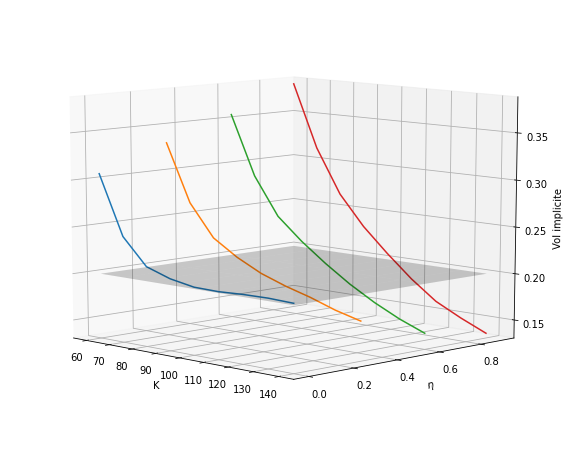

In [ ]:
fig = plt.figure(figsize=(10,8))
ax = fig.gca(projection='3d')

for i, vol_eta in enumerate(vols_etatot):
  ax.plot(strikes, vol_eta, zs=etas[i], zdir="y", label=f"T={etas[i]}")

# Pour la surface représentant le sigma_BS = 0.2
xx, yy = np.meshgrid(strikes, etas)
zz = 0*yy + 0.2

ax.plot_surface(xx,yy, zz, alpha=0.2, color="black", label=r"$\sigma_{BS}$")
ax.set(xlabel="K", ylabel=r"$\eta", zlabel="Vol implicite")
ax.view_init(elev=10., azim=-45)

## En fonction de $\rho$

In [ ]:
rhos = np.array([-0.8,-0.2,0.2,0.8])
strikes = np.arange(60,150,10)
vols_rhotot = []

for rho in tqdm(rhos, desc="Rhos"):
  vols_impl=[]
  for K in tqdm(strikes, desc="Strikes"):
    vols_impl.append(Heston(K=K, rho=rho, nb_sim_path=1000, fix_seed=True).vol_impl)
  vols_rhotot.append(vols_impl)

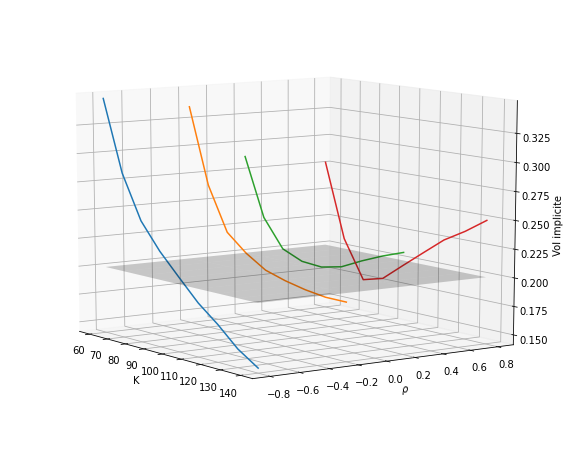

In [ ]:
fig = plt.figure(figsize=(10,8))
ax = fig.gca(projection='3d')

for i, vol_rho in enumerate(vols_rhotot):
  ax.plot(strikes, vol_rho, zs=rhos[i], zdir="y", label=f"T={rhos[i]}")

# Pour la surface représentant le sigma_BS = 0.2
xx, yy = np.meshgrid(strikes, rhos)
zz = 0*yy + 0.2

ax.plot_surface(xx,yy, zz, alpha=0.2, color="black", label=r"$\sigma_{BS}$")
ax.set(xlabel="K", ylabel=r"$\rho", zlabel="Vol implicite")
ax.view_init(elev=10., azim=-35)

## Densité de transition du processus racine carrée et comparaison

In [ ]:
class CIR(EDS):
  """ Classe implementant le processus CIR par schéma d'Euler et de manière exacte.
      Classe non fille de Heston par choix de garder un modèle de Heston par initialisation."""
  def __init__(self, Ndt=1000, nb_sim_path=1000, T=1, vbar=0.2**2, lambd=5, eta=0.5, cond_bords="refl", fix_seed=False, display_text=False):
    self.Ndt = Ndt
    self.nb_sim_path = nb_sim_path
    self.T = T
    self.vbar = vbar
    self.lambd = lambd
    self.eta = eta
    EDS.__init__(self)
    if fix_seed: np.random.seed(25)
    x = np.random.normal(0,1,size=(self.Ndt, self.nb_sim_path))

    # Initialisation de nos trajectoires CIR
    self.vpath_ex = np.zeros((self.Ndt, self.nb_sim_path)); self.vpath_ex[0,:] = self.vbar
    self.vpath_eul = np.zeros((self.Ndt, self.nb_sim_path)); self.vpath_eul[0,:] = self.vbar 

    # On calcule le CIR de manière exacte
    a = self.eta**2*(1 - np.exp(-self.lambd*self.dt))/(4*self.lambd)
    self.d = (4*self.lambd*self.vbar)/(self.eta**2)
    if self.d > 1:
      if display_text: print("d > 1, calcul selon chi2 et loi normale")
      for i in range(self.t.shape[0] - 1):
        b = self.vpath_ex[i]*np.exp(-self.lambd*self.dt)/a
        self.vpath_ex[i+1] = a*(np.random.chisquare(self.d-1, self.nb_sim_path) + (x[i] + np.sqrt(b))**2)
    else:
      if display_text: print("d < 1, calcul selon chi2 avoir loi de poisson en dlib")
      for i in range(self.t.shape[0] - 1):
        b = self.vpath_ex[i]*np.exp(-self.lambd*self.dt)/a
        dlib = self.d + 2*np.random.poisson(b/2, self.nb_sim_path)
        self.vpath_ex[i+1] = a*np.random.chisquare(dlib, self.nb_sim_path)

    # On calcule le CIR avec le schéma d'Euler (comme pour Heston)
    for i in range(self.t.shape[0] - 1):
        if cond_bords == "refl":
          self.vpath_eul[i+1] = np.abs(self.vpath_eul[i] - self.lambd*(self.vpath_eul[i] - self.vbar)*self.dt + self.eta*np.sqrt(self.vpath_eul[i])*np.sqrt(self.dt)*x[i])
        elif cond_bords == "abs":
          self.vpath_eul[i+1] = np.maximum(self.vpath_eul[i] - self.lambd*(self.vpath_eul[i] - self.vbar)*self.dt + self.eta*np.sqrt(self.vpath_eul[i])*np.sqrt(self.dt)*x[i], 0)


### En fonction de $N \in [100,1000,10000]$

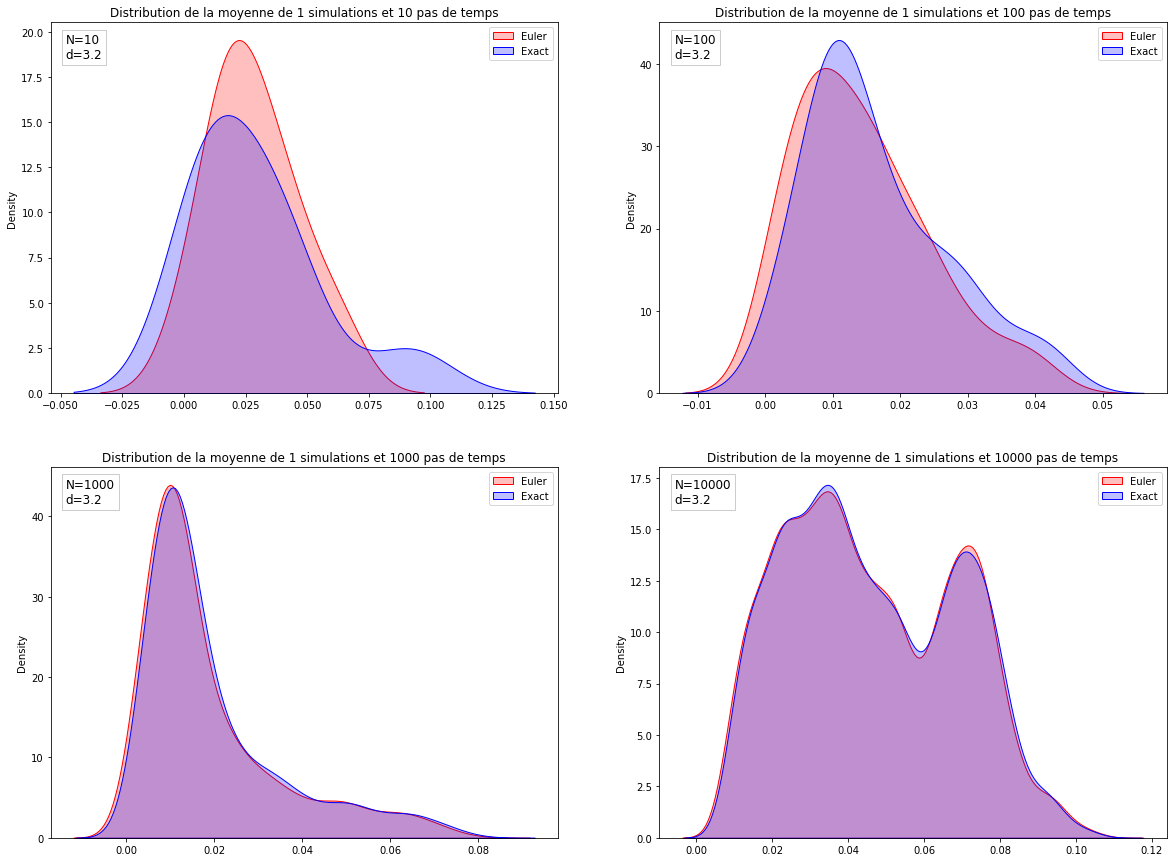

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(20,15))
ax = ax.ravel()
for i, N in enumerate([10,100,1000,10000]):
  cir = CIR(Ndt=N, nb_sim_path=1000, fix_seed=True)
  ax[i].set(title=f"Distribution de la moyenne de 1 simulations et {N} pas de temps")
  # On affiche la densité seulement pour les premières simulations de trajectoires -> très variable
  sns.kdeplot(cir.vpath_eul[:,0], fill=True, label = "Euler", ax=ax[i], color="red")
  sns.kdeplot(cir.vpath_ex[:,0], fill=True, label = "Exact", ax=ax[i], color="blue")
  ax[i].annotate(f"N={N}\nd={np.round(cir.d,2)}", xy=(0.03,0.97), xycoords='axes fraction', bbox=dict(facecolor='white', alpha=0.2), fontsize=12, horizontalalignment='left', verticalalignment='top')
  ax[i].legend()

### En fonction de $\lambda \in \{1,5,100,1000\}$ ( le mettre ? )

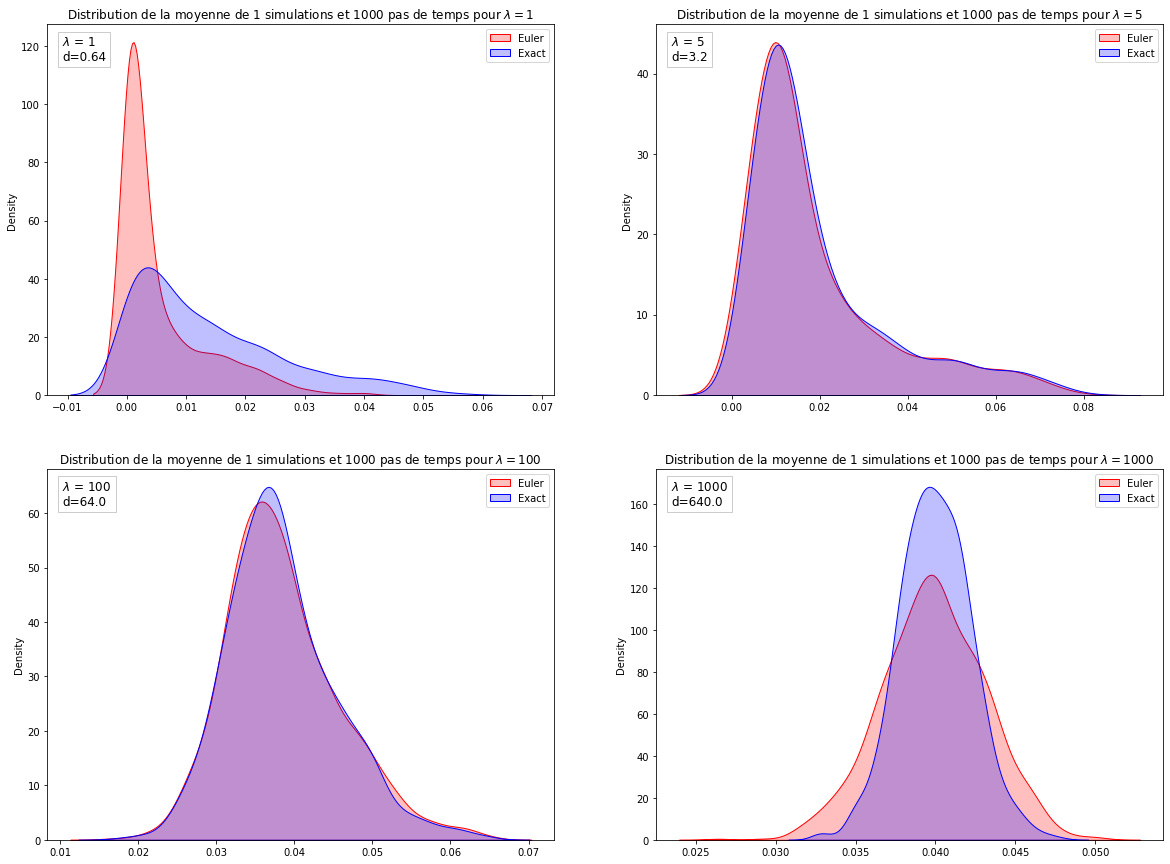

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(20,15))
ax = ax.ravel()
for i, lambd in enumerate([1,5,100,1000]):
  cir = CIR(Ndt=1000, nb_sim_path=1000, lambd=lambd, fix_seed=True)
  ax[i].set(title=f"Distribution de la moyenne de $1$ simulations et $1000$ pas de temps pour $\lambda={lambd}$")
  sns.kdeplot(cir.vpath_eul[:,0], fill=True, label = "Euler", ax=ax[i], color="red")
  sns.kdeplot(cir.vpath_ex[:,0], fill=True, label = "Exact", ax=ax[i], color="blue")
  ax[i].annotate(f"$\lambda$ = {lambd}\nd={np.round(cir.d,2)}", xy=(0.03,0.97), xycoords='axes fraction', bbox=dict(facecolor='white', alpha=0.2), fontsize=12, horizontalalignment='left', verticalalignment='top')
  ax[i].legend()

### En fonction de $\eta$



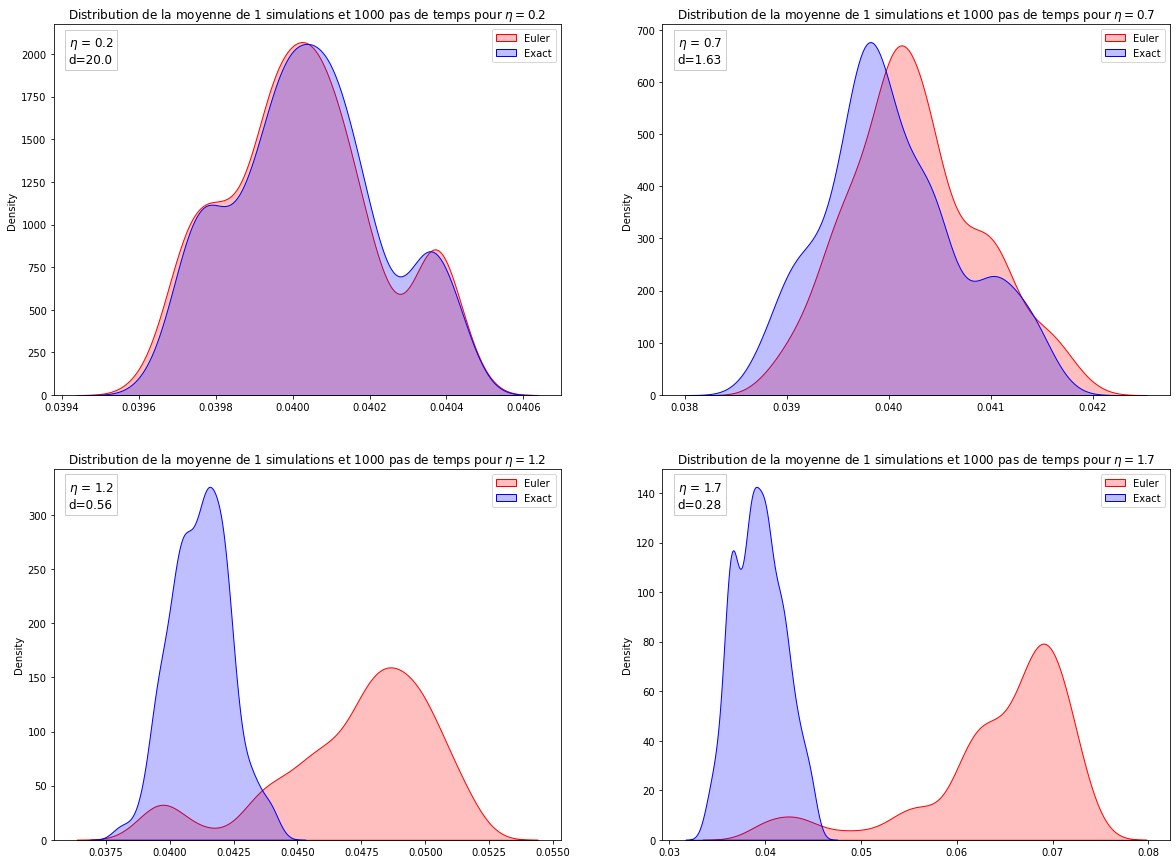

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(20,15))
etas = np.arange(0.2, 2,0.5)
ax = ax.ravel()
for i, eta in enumerate(etas):
  cir = CIR(Ndt=1000, nb_sim_path=1000, eta=eta, fix_seed=True)
  ax[i].set(title=f"Distribution de la moyenne de 1 simulations et $1000$ pas de temps pour $\eta={np.round(eta,1)}$")
  sns.kdeplot(np.apply_along_axis(np.average,1,cir.vpath_eul), fill=True, label = "Euler", ax=ax[i], color="red")
  sns.kdeplot(np.apply_along_axis(np.average,1,cir.vpath_ex), fill=True, label = "Exact", ax=ax[i], color="blue")
  ax[i].annotate(f"$\eta$ = {np.round(eta,1)}\nd={np.round(cir.d,2)}", xy=(0.03,0.97), xycoords='axes fraction', bbox=dict(facecolor='white', alpha=0.2), fontsize=12, horizontalalignment='left', verticalalignment='top')
  ax[i].legend()